# Pre-Examination #1 - New York City Taxi Trip Duration

### Dataset Description:
#### Dataset Kaggle Link:
Dataset: [Kaggle NYC Taxi Trip Duration](https://www.kaggle.com/competitions/nyc-taxi-trip-duration/overview)

#### Features:
1. `id` - a unique identifier for each trip;
2. `vendor_id` - a code indicating the provider associated with the trip record;
3. `pickup_datetime` - date and time when the meter was engaged;
4. `dropoff_datetime` - date and time when the meter was disengaged (not available in test subset);
5. `passenger_count` - the number of passengers in the vehicle (driver entered value);
6. `pickup_longitude` - the longitude where the meter was engaged;
7. `pickup_latitude` - the latitude where the meter was engaged;
8. `dropoff_longitude` - the longitude where the meter was disengaged;
9. `dropoff_latitude` - the latitude where the meter was disengaged;
10. `store_and_fwd_flag` - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - `Y` = store and forward; `N` = not a store and forward trip;
11. `trip_duration` - duration of the trip in seconds.

#### Target:
Since there is a column with continuous numerical values that will offer true label values for each record in the dataset - `trip_duration`, this dataset is designed for a Supervised Machine Learning Problem. This column holds information about the duration of each trip.

#### `dropoff_datetime`:
Since `dropoff_datetime` and `pickup_datetime` together may give the trip duration by themselves, without the need of training a model, test subset does not include this column, which disables the possibility to use this column as a feature. However, since training subset contains this column, it may be used only for analysis part of the work.

### Problem Description:
This dataset was collected by an taxi agency in New York City - [New York City Taxi and Limousine Commission (NYC TLC)](https://www.nyc.gov/site/tlc/index.page) offers information about total ride duration of taxi trips in New York City. Besides that, on Kaggle page was mentioned that this dataset was sampled and cleaned, with no additional information about what procedures were done on this dataset, which is a subject of further analysis to determine the applied methods. The task is to train a **Regression Model**, that will predict the **duration of the trip** based on several factors, such as: **passenger count**, **date** and **time** when **meter was engaged** and **disengaged**, and so on.


In [1]:
# Import Data Structures
import pandas as pd
import dask.dataframe as dd

# Import Data Manipulation Libraries
import numpy as np
import math

# Import Distance Calculation Methods
from geopy.distance import geodesic
import osmnx as ox

# Import Base Classes for Type Annotation
from sklearn.base import TransformerMixin, BaseEstimator

# Import Structure Manipulation Methods
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, TargetEncoder, OrdinalEncoder, FunctionTransformer
from sklearn.decomposition import PCA

# Import Visualization Libs
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
sns.set_style(style="whitegrid")
sns.set_palette('bright')
# from dtreeviz import model

# Import Outlier Detection
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest

# Import Feature Selection Methods
from kydavra import PValueSelector, LassoSelector, SpearmanCorrelationSelector

# Import Hyperparameter Tuning
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

# Import ML Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Import Interpretation Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error, r2_score, root_mean_squared_log_error, make_scorer
# from lime.lime_tabular import LimeTabularExplainer
# import shap

# Import Time
# import time
# from tqdm import tqdm
# tqdm.pandas()

# Import Custom Utils
from utils import get_percentage_cat_col, get_distance_osmnx, get_distance_api, get_distance_haversine, measure_time_function, \
    extract_datetime_features, extract_distance_features, get_outliers_by_boxplot, FeatureSelectorWrapper
import swifter

## Dataset Loading

In [2]:
taxi_duration_df: pd.DataFrame = pd.read_csv(filepath_or_buffer='dataset/train.csv', 
                                             sep=',')

In [3]:
taxi_duration_df_copy = taxi_duration_df.copy(deep=True)

In [4]:
taxi_duration_df.head(n=10)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435
5,id0801584,2,2016-01-30 22:01:40,2016-01-30 22:09:03,6,-73.982857,40.742195,-73.992081,40.749184,N,443
6,id1813257,1,2016-06-17 22:34:59,2016-06-17 22:40:40,4,-73.969017,40.757839,-73.957405,40.765896,N,341
7,id1324603,2,2016-05-21 07:54:58,2016-05-21 08:20:49,1,-73.969276,40.797779,-73.922470,40.760559,N,1551
8,id1301050,1,2016-05-27 23:12:23,2016-05-27 23:16:38,1,-73.999481,40.738400,-73.985786,40.732815,N,255
9,id0012891,2,2016-03-10 21:45:01,2016-03-10 22:05:26,1,-73.981049,40.744339,-73.973000,40.789989,N,1225


In [5]:
taxi_duration_df.tail(n=10)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
1458634,id3445276,1,2016-04-03 13:51:25,2016-04-03 14:07:37,2,-73.989075,40.730465,-73.963882,40.773739,N,972
1458635,id3027038,2,2016-05-19 14:46:55,2016-05-19 14:50:52,1,-73.985390,40.763020,-73.989708,40.767502,N,237
1458636,id0405770,2,2016-02-12 10:13:06,2016-02-12 10:26:26,1,-73.863815,40.769684,-73.864395,40.761326,N,800
1458637,id1920898,1,2016-04-17 18:48:16,2016-04-17 19:00:56,1,-73.975357,40.751705,-73.949478,40.776764,N,760
1458638,id1454193,2,2016-02-02 00:39:39,2016-02-02 00:46:33,5,-73.988823,40.736553,-73.989166,40.757393,N,414
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373
1458643,id1209952,1,2016-04-05 14:44:25,2016-04-05 14:47:43,1,-73.979538,40.781750,-73.972809,40.790585,N,198


In [6]:
print(f'Dataset shape: {taxi_duration_df.shape[0]} rows and {taxi_duration_df.shape[1]} columns')

Dataset shape: 1458644 rows and 11 columns


As it may be seen, this dataset contains information about $\approx$ 1.46 million rows and contains 11 columns - 10 features and 1 target, as it was specified above.

In [7]:
taxi_duration_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


There are several features that are of `object` type, which are of `String` data type, such as: `id`, `pickup_datetime`, `dropoff_datetime`, `store_and_fwd_flag`. However, as it was seen above, by direct observations, `pickup_datetime` and `dropoff_datetime` are of `DateTime` data type, to which they will be converted further. Besides them, there is another column that contained only two unique values when the dataset head and tail were analyzed, therefore, there may be needed an evaluation of unique values of other columns as well. Rest of the columns should be analyzed closely to verify their actual data type for numerical conversion.

In [8]:
for column in taxi_duration_df.columns:
    unique_values_col: np.ndarray = taxi_duration_df[column].unique()
    print(f'Column {column}: {unique_values_col} - {len(unique_values_col)}')
    del unique_values_col

Column id: ['id2875421' 'id2377394' 'id3858529' ... 'id2304944' 'id2714485'
 'id1209952'] - 1458644
Column vendor_id: [2 1] - 2
Column pickup_datetime: ['2016-03-14 17:24:55' '2016-06-12 00:43:35' '2016-01-19 11:35:24' ...
 '2016-01-10 07:35:15' '2016-04-22 06:57:41' '2016-01-05 15:56:26'] - 1380222
Column dropoff_datetime: ['2016-03-14 17:32:30' '2016-06-12 00:54:38' '2016-01-19 12:10:48' ...
 '2016-04-22 07:10:25' '2016-01-05 16:02:39' '2016-04-05 14:47:43'] - 1380377
Column passenger_count: [1 6 4 2 3 5 0 7 9 8] - 10
Column pickup_longitude: [-73.98215485 -73.98041534 -73.97902679 ... -73.84746552 -73.89477539
 -73.84131622] - 23047
Column pickup_latitude: [40.76793671 40.73856354 40.7639389  ... 40.69665146 40.83586502
 40.82304382] - 45245
Column dropoff_longitude: [-73.96463013 -73.9994812  -74.00533295 ... -73.85946655 -74.04266357
 -73.76462555] - 33821
Column dropoff_latitude: [40.76560211 40.73115158 40.71008682 ... 40.65151978 40.64244461
 40.62860489] - 62519
Column store_a

As it may be noticed, the column of `store_and_fwd_flag` contains only two unique values, which means that this column may be converted into a binary feature using numerical values - `0` for `N` and `1` - for `Y`. `id` column contains unique values for each record in the dataset, and can be dropped since this column contains no valuable information and is used to give a unique Identifier for each row in the dataset. `pickup_datetime` and `dropoff_datetime` are `datetime` variables and will be converted accordingly. Similarly, `vendor_id` contains information about specific trip record vendor, which contained only 2 values.

In [9]:
columns_to_drop_eda: list[str] = ['id', 'dropoff_datetime']
columns_to_drop_model: list[str] = ['id', 'dropoff_datetime', 'pickup_datetime']
datetime_columns: list[str] = ['pickup_datetime', 'dropoff_datetime']
binary_columns: list[str] = ['store_and_fwd_flag', 'vendor_id']
location_columns: list[str] = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']

At the same time, there were trips with no passengers. As it was mentioned in [Features Description](#features), the `passenger_count` is the value entered by driver, which could indicate that driver did not enter the number of passengers during taxi trip, but further analysis is required.

In [10]:
taxi_duration_df.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


Dataset is not standardized and contains values in their original form. At the same time, it may be noticed that `trip_duration` column minimal value is 1 second, which may show an anomaly in records and should be treated accordingly. At the same time, `passenger_count` minimum is $0$ which also may lead to an anomaly.

## Feature Engineering
Since there are several columns that contain important information, such as: period of the day when trip was recorded, road distance and so on, several new features may be formed using them.

### Data Conversion
First, `String` to `DateTime` was done using built-in `pandas` function - `to_datetime`.

In [11]:
taxi_duration_df[datetime_columns] = taxi_duration_df[datetime_columns].swifter.progress_bar(enable=True, desc='Convert to DateTime').apply(pd.to_datetime, format='%Y-%m-%d %H:%M:%S')

Convert to DateTime:   0%|          | 0/2 [00:00<?, ?it/s]

In [12]:
taxi_duration_df.head(n=5)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


### New Features

#### Distance Feature
An API ([DistanceMatrix.AI](https://account.distancematrix.ai/)) was used to determine the Road Distance between Pickup Latitude and Longitude and Dropoff Latidude and Longitude. However, due to API usage limitation, a library - [OSMNX](https://osmnx.readthedocs.io/en/stable/index.html) was tried, that is using OpenStreetMap and find the path between points using Graphs and Path Finding Algorithms. In this case, the problem of the dataset appears - since it is quite big, computation takes a lot of time. Was decided to use straight-forward, not always close to truth, but still useful way of computing distance between points - Harversine Formula, which takes into consideration the curvature of the Earth:
$$
\begin{align*}
a &= \sin^2\left(\frac{\Delta\phi}{2}\right) + \cos \phi_1 \cdot \cos \phi_2 \cdot \sin^2\left(\frac{\Delta\lambda}{2}\right) \\
c &= 2 \cdot \arctan2(\sqrt{a}, \sqrt{1-a}) \\
d &= R \cdot c
\end{align*}
$$
Also, there is a possibility to use Manhattan Formula, that is also called taxicab formula, which is a good choice to use in determination of distance between two points in a grid-like city structure. Besides that, `geopy` offers another method of calculation of distance, based on the actual form of the Earth - geoid.

In [13]:
taxi_duration_df[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']]

,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
0,40.767937,-73.982155,40.765602,-73.964630
1,40.738564,-73.980415,40.731152,-73.999481
2,40.763939,-73.979027,40.710087,-74.005333
3,40.719971,-74.010040,40.706718,-74.012268
4,40.793209,-73.973053,40.782520,-73.972923
...,...,...,...,...
1458639,40.745522,-73.982201,40.740170,-73.994911
1458640,40.747379,-74.000946,40.796547,-73.970184
1458641,40.768799,-73.959129,40.707371,-74.004433
1458642,40.749062,-73.982079,40.757107,-73.974632


In [14]:
# north = taxi_duration_df[['pickup_latitude', 'dropoff_latitude']].max().max()
# south = taxi_duration_df[['pickup_latitude', 'dropoff_latitude']].min().min()
# east  = taxi_duration_df[['pickup_longitude', 'dropoff_longitude']].max().max()
# west  = taxi_duration_df[['pickup_longitude', 'dropoff_longitude']].min().min()

# bbox = (west - 0.01, south - 0.01, east + 0.01, north + 0.01)

G = ox.graph_from_place("New York City, New York, USA", network_type="drive")
print(f'Graph created with {len(G.nodes)} nodes and {len(G.edges)} edges')
# G = ox.truncate.truncate_graph_bbox(G, bbox)
# print(f'Graph truncated to bbox with {len(G.nodes)} nodes and {len(G.edges)} edges')

Graph created with 55262 nodes and 139294 edges


In [15]:
def get_distance_manhattan(row: pd.Series) -> float:
    lat_dist = abs(row['dropoff_latitude'] - row['pickup_latitude']) * 111320  # Convert degrees to kilometers
    lon_dist = abs(row['dropoff_longitude'] - row['pickup_longitude']) * 111320 * math.cos(row['pickup_latitude'] * math.pi / 180)
    return lat_dist + lon_dist

In [16]:
# taxi_duration_df['road_distance'] = taxi_duration_df[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']].swifter.progress_bar(enable=True, desc='Duration Calculation').apply(
#     lambda rec: get_distance_osmnx(
#         row=rec,
#         G=G
#     ), axis=1
# )

taxi_duration_df['road_distance'] = taxi_duration_df[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']].swifter.progress_bar(enable=True, desc='Duration Calculation').apply(
    lambda rec: get_distance_manhattan(row=rec), 
    axis=1
)

Duration Calculation:   0%|          | 0/33 [00:00<?, ?it/s]

In [17]:
taxi_duration_df

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,road_distance
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,1737.385329
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2433.239937
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,8212.802551
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,1663.199924
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,1200.805926
...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778,1667.768688
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655,8067.644541
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764,10657.620193
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373,1523.561588


In [18]:
taxi_duration_df[taxi_duration_df['road_distance'] == 0]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,road_distance
246,id3487442,2,2016-02-29 18:39:12,2016-02-29 18:42:59,1,-73.981819,40.768963,-73.981819,40.768963,N,227,0.0
291,id0924324,2,2016-05-10 18:07:52,2016-05-10 18:26:21,2,-73.959068,40.775661,-73.959068,40.775661,N,1109,0.0
407,id1145809,2,2016-05-16 23:15:13,2016-05-16 23:31:00,6,-73.808487,40.687336,-73.808487,40.687336,N,947,0.0
702,id3499387,1,2016-01-25 19:45:12,2016-01-25 19:54:52,1,-73.786720,40.647041,-73.786720,40.647041,N,580,0.0
1620,id0753277,1,2016-01-27 22:29:31,2016-01-27 22:29:58,1,-74.209854,40.816853,-74.209854,40.816853,N,27,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1456399,id0618137,2,2016-02-17 08:57:04,2016-02-17 09:18:28,1,-73.978859,40.756721,-73.978859,40.756721,N,1284,0.0
1456627,id1048767,2,2016-02-06 22:01:40,2016-02-06 22:03:47,1,-73.963554,40.768517,-73.963554,40.768517,N,127,0.0
1456989,id2595295,2,2016-03-12 07:37:16,2016-03-12 07:46:42,1,-73.984848,40.728222,-73.984848,40.728222,N,566,0.0
1457114,id0051314,2,2016-04-09 20:34:21,2016-04-09 20:44:53,1,-73.965981,40.770988,-73.965981,40.770988,N,632,0.0


In [19]:
print(f"Anomaly Taxi Trips: {taxi_duration_df[taxi_duration_df['road_distance'] == 0].shape[0]}")
print(f"Total Taxi Trips: {taxi_duration_df.shape[0]}")
print(f"Percentage of Anomaly Taxi Trips: {(taxi_duration_df[taxi_duration_df['road_distance'] == 0].shape[0] / taxi_duration_df.shape[0] * 100):.5f}%")

Anomaly Taxi Trips: 5897
Total Taxi Trips: 1458644
Percentage of Anomaly Taxi Trips: 0.40428%


As it may be seen, there are several cases when `road_distance` is equal to zero. By further analysis, was concluded that both pickup and dropoff coordinates are the same, which resulted in values equal to 0. 

In order to compare the above mentioned methods, below is provided the calculated road lengths using all 5 methods.

In [20]:
def get_distance_vincenty(row: pd.Series) -> float:
    coords_1 = (row['pickup_latitude'], row['pickup_longitude'])
    coords_2 = (row['dropoff_latitude'], row['dropoff_longitude'])
    return geodesic(coords_1, coords_2).meters

In [21]:
for i in range(5):
    rec = taxi_duration_df.iloc[i]
    print(f"\nData Sample Point - {i}")

    print("Road Distance using API Call:")
    result, elapsed_time = measure_time_function(get_distance_api, row=rec)
    print(f"Distance: {result} meters, Time: {elapsed_time:.2f} seconds")

    print("Road Distance using OSMNX Library:")
    result, elapsed_time = measure_time_function(get_distance_osmnx, row=rec, G=G)
    print(f"Distance: {result} meters, Time: {elapsed_time:.2f} seconds")

    print("Road Distance using Haversine Formula:")
    result, elapsed_time = measure_time_function(get_distance_haversine, row=rec)
    print(f"Distance: {result} meters, Time: {elapsed_time:.2f} seconds")

    print("Road Distance using Manhattan Formula:")
    result, elapsed_time = measure_time_function(get_distance_manhattan, row=rec)
    print(f"Distance: {result} meters, Time: {elapsed_time:.2f} seconds")

    print("Road Distance using Geopy.Geodesic:")
    result, elapsed_time = measure_time_function(get_distance_vincenty, row=rec)
    print(f"Distance: {result} meters, Time: {elapsed_time:.2f} seconds")


Data Sample Point - 0
Road Distance using API Call:
Distance: 1916 meters, Time: 0.35 seconds
Road Distance using OSMNX Library:
Distance: 1967.5906469194654 meters, Time: 0.27 seconds
Road Distance using Haversine Formula:
Distance: 1.498522849490913 meters, Time: 0.46 seconds
Road Distance using Manhattan Formula:
Distance: 1737.385329291822 meters, Time: 0.00 seconds
Road Distance using Geopy.Geodesic:
Distance: 1502.1718368830568 meters, Time: 0.00 seconds

Data Sample Point - 1
Road Distance using API Call:
Distance: 2516 meters, Time: 0.21 seconds
Road Distance using OSMNX Library:
Distance: 2500.1114033177855 meters, Time: 0.29 seconds
Road Distance using Haversine Formula:
Distance: 1.805509662669238 meters, Time: 0.00 seconds
Road Distance using Manhattan Formula:
Distance: 2433.2399366205264 meters, Time: 0.00 seconds
Road Distance using Geopy.Geodesic:
Distance: 1808.6599689816733 meters, Time: 0.00 seconds

Data Sample Point - 2
Road Distance using API Call:
Distance: 9899

#### Time-based Features
Since there is one significant feature that is of data type `DateTime`, several options may be selected in order to represent those values in a more useful format. For example, `pickup_datetime`, which is the feature that should be taken in consideration for Model Training, may hold information about the specific day of the week, when the taxi trip was done, as well the period of the day, which also influences the duration of the trip, since in different periods of the day different road traffic may be encountered.

In [22]:
pickup_rounded = taxi_duration_df['pickup_datetime'].dt.round('H')
dropoff_rounded = taxi_duration_df['dropoff_datetime'].dt.round('H')


taxi_duration_df['pickup_month'] = pickup_rounded.dt.month
taxi_duration_df['pickup_day'] = pickup_rounded.dt.weekday
taxi_duration_df['pickup_hour'] = pickup_rounded.dt.hour
taxi_duration_df['pickup_period_of_day'] = taxi_duration_df['pickup_hour'].swifter.progress_bar(enable=True, desc=f'Period of Day').apply(
            lambda x: 'Morning' if 5 <= x < 12 else
                      'Afternoon' if 12 <= x < 17 else
                      'Evening' if 17 <= x < 22 else
                      'Night'
        )
taxi_duration_df['pickup_is_weekend'] = taxi_duration_df['pickup_day'].swifter.progress_bar(enable=True, desc=f'Is Weekend').apply(
            lambda x: 1 if x in [5, 6] else 0
        )
taxi_duration_df['pickup_season'] = taxi_duration_df['pickup_month'].swifter.progress_bar(enable=True, desc=f'Season').apply(
    lambda x: 'Winter' if x in [12, 1, 2] else
                'Spring' if x in [3, 4, 5] else
                'Summer' if x in [6, 7, 8] else
                'Autumn'
)

Period of Day:   0%|          | 0/33 [00:00<?, ?it/s]

Is Weekend:   0%|          | 0/1458644 [00:00<?, ?it/s]

Season:   0%|          | 0/1458644 [00:00<?, ?it/s]

In [23]:
taxi_duration_df['dropoff_month'] = dropoff_rounded.dt.month
taxi_duration_df['dropoff_day'] = dropoff_rounded.dt.weekday
taxi_duration_df['dropoff_hour'] = dropoff_rounded.dt.hour
taxi_duration_df['dropoff_period_of_day'] = taxi_duration_df['dropoff_hour'].swifter.progress_bar(enable=True, desc=f'Period of Day').apply(
            lambda x: 'Morning' if 5 <= x < 12 else
                      'Afternoon' if 12 <= x < 17 else
                      'Evening' if 17 <= x < 22 else
                      'Night'
        )
taxi_duration_df['dropoff_is_weekend'] = taxi_duration_df['dropoff_day'].swifter.progress_bar(enable=True, desc=f'Is Weekend').apply(
            lambda x: 1 if x in [5, 6] else 0
        )
taxi_duration_df['dropoff_season'] = taxi_duration_df['dropoff_month'].swifter.progress_bar(enable=True, desc=f'Season').apply(
    lambda x: 'Winter' if x in [12, 1, 2] else
                'Spring' if x in [3, 4, 5] else
                'Summer' if x in [6, 7, 8] else
                'Autumn'
)

Period of Day:   0%|          | 0/1458644 [00:00<?, ?it/s]

Is Weekend:   0%|          | 0/1458644 [00:00<?, ?it/s]

Season:   0%|          | 0/1458644 [00:00<?, ?it/s]

Since `dropoff_datetime` column is not avaiable in `test.zip` dataset on Kaggle, this column should not be used as a feature, and may be used only for analysis, therefore newly created features should be dropped afterwards.

In [24]:
# columns_to_drop_model.extend(['dropoff_month', 'dropoff_day', 'dropoff_hour', 'dropoff_period_of_day', 'dropoff_is_weekend', 'dropoff_season', 'pickup_datetime'])
# columns_to_drop_model

In [25]:
taxi_duration_df

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_hour,pickup_period_of_day,pickup_is_weekend,pickup_season,dropoff_month,dropoff_day,dropoff_hour,dropoff_period_of_day,dropoff_is_weekend,dropoff_season
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,17,Evening,0,Spring,3,0,18,Evening,0,Spring
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,1,Night,1,Summer,6,6,1,Night,1,Summer
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,12,Afternoon,0,Winter,1,1,12,Afternoon,0,Winter
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,20,Evening,0,Spring,4,2,20,Evening,0,Spring
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,14,Afternoon,1,Spring,3,5,14,Afternoon,1,Spring
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,...,14,Afternoon,0,Spring,4,4,14,Afternoon,0,Spring
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,...,8,Morning,1,Winter,1,6,8,Morning,1,Winter
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,...,7,Morning,0,Spring,4,4,7,Morning,0,Spring
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,...,16,Afternoon,0,Winter,1,1,16,Afternoon,0,Winter


### Feature Engineering Pipeline

In [26]:
def extract_datetime_features_bp(df: pd.DataFrame, dt_cols: list[str]) -> pd.DataFrame:
    for col in dt_cols:
        df[col] = df[col].swifter.progress_bar(enable=True, desc=f'Convert {col} to DateTime').apply(pd.to_datetime, format='%Y-%m-%d %H:%M:%S')
        col_rounded = df[col].dt.round('H')
        df[f'{col.split(sep="_")[0]}_month'] = col_rounded.dt.month
        df[f'{col.split(sep="_")[0]}_day'] = col_rounded.dt.weekday
        df[f'{col.split(sep="_")[0]}_hour'] = col_rounded.dt.hour

    return df

In [27]:
def extract_datetime_features_fe(df: pd.DataFrame, dt_cols: list[str]) -> pd.DataFrame:
    for col in dt_cols:
        df[col] = df[col].swifter.progress_bar(enable=True, desc=f'Convert {col} to DateTime').apply(pd.to_datetime, format='%Y-%m-%d %H:%M:%S')
        col_rounded = df[col].dt.round('H')
        df[f'{col.split(sep="_")[0]}_month'] = col_rounded.dt.month
        df[f'{col.split(sep="_")[0]}_day'] = col_rounded.dt.weekday
        df[f'{col.split(sep="_")[0]}_hour'] = col_rounded.dt.hour

        df[f'{col.split(sep="_")[0]}_period_of_day'] = df[f'{col.split(sep="_")[0]}_hour'].swifter.progress_bar(enable=True, desc=f'Convert {col} to DateTime').apply(
            lambda x: 'Morning' if 5 <= x < 12 else
                      'Afternoon' if 12 <= x < 17 else
                      'Evening' if 17 <= x < 22 else
                      'Night'
        )
        df[f'{col.split(sep="_")[0]}_is_weekend'] = df[f'{col.split(sep="_")[0]}_day'].swifter.progress_bar(enable=True, desc=f'Convert {col} to DateTime').apply(
            lambda x: 1 if x in [5, 6] else 0
        )
        df[f'{col.split(sep="_")[0]}_season'] = df[f'{col.split(sep="_")[0]}_month'].swifter.progress_bar(enable=True, desc=f'Convert {col} to DateTime').apply(
            lambda x: 'Winter' if x in [12, 1, 2] else
                      'Spring' if x in [3, 4, 5] else
                      'Summer' if x in [6, 7, 8] else
                      'Autumn'
        )

    return df

In [41]:
def extract_distance_features(df: pd.DataFrame) -> pd.DataFrame:
    df['road_distance'] = df[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']].swifter.progress_bar(enable=True, desc='Distance Calculation').apply(
        lambda rec: get_distance_manhattan(row=rec), axis=1
    )
    return df

In [42]:
datetime_transformer_eda = FunctionTransformer(extract_datetime_features_fe, kw_args={'dt_cols': datetime_columns}, validate=False)
distance_transformer = FunctionTransformer(extract_distance_features, validate=False)

In [43]:
feature_engineering_transformer_eda = ColumnTransformer(
    transformers=[
        ('datetime', datetime_transformer_eda, datetime_columns),
        ('distance', distance_transformer, location_columns)
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
).set_output(transform='pandas')

In [44]:
drop_transformer_eda = ColumnTransformer(
    transformers=[
        ('drop', 'drop', columns_to_drop_eda)
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
).set_output(transform='pandas')

In [45]:
feature_engineering_pipeline = Pipeline(
    steps=[
        ('feature_engineering', feature_engineering_transformer_eda),
        ('drop_columns', drop_transformer_eda)
    ]
).set_output(transform='pandas')

In [46]:
taxi_duration_df_copy_transformed_eda = feature_engineering_pipeline.fit_transform(taxi_duration_df_copy)

Convert pickup_datetime to DateTime:   0%|          | 0/1458644 [00:00<?, ?it/s]

Convert pickup_datetime to DateTime:   0%|          | 0/1458644 [00:00<?, ?it/s]

Convert pickup_datetime to DateTime:   0%|          | 0/1458644 [00:00<?, ?it/s]

Convert dropoff_datetime to DateTime:   0%|          | 0/1458644 [00:00<?, ?it/s]

Convert dropoff_datetime to DateTime:   0%|          | 0/1458644 [00:00<?, ?it/s]

Convert dropoff_datetime to DateTime:   0%|          | 0/1458644 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/33 [00:00<?, ?it/s]

In [47]:
taxi_duration_df_copy_transformed_eda

,pickup_datetime,pickup_month,pickup_day,pickup_hour,pickup_period_of_day,pickup_is_weekend,pickup_season,dropoff_month,dropoff_day,dropoff_hour,...,dropoff_season,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,road_distance,vendor_id,passenger_count,store_and_fwd_flag,trip_duration
0,2016-03-14 17:24:55,3,0,17,Evening,0,Spring,3,0,18,...,Spring,40.767937,-73.982155,40.765602,-73.964630,1737.385329,2,1,N,455
1,2016-06-12 00:43:35,6,6,1,Night,1,Summer,6,6,1,...,Summer,40.738564,-73.980415,40.731152,-73.999481,2433.239937,1,1,N,663
2,2016-01-19 11:35:24,1,1,12,Afternoon,0,Winter,1,1,12,...,Winter,40.763939,-73.979027,40.710087,-74.005333,8212.802551,2,1,N,2124
3,2016-04-06 19:32:31,4,2,20,Evening,0,Spring,4,2,20,...,Spring,40.719971,-74.010040,40.706718,-74.012268,1663.199924,2,1,N,429
4,2016-03-26 13:30:55,3,5,14,Afternoon,1,Spring,3,5,14,...,Spring,40.793209,-73.973053,40.782520,-73.972923,1200.805926,2,1,N,435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,2016-04-08 13:31:04,4,4,14,Afternoon,0,Spring,4,4,14,...,Spring,40.745522,-73.982201,40.740170,-73.994911,1667.768688,2,4,N,778
1458640,2016-01-10 07:35:15,1,6,8,Morning,1,Winter,1,6,8,...,Winter,40.747379,-74.000946,40.796547,-73.970184,8067.644541,1,1,N,655
1458641,2016-04-22 06:57:41,4,4,7,Morning,0,Spring,4,4,7,...,Spring,40.768799,-73.959129,40.707371,-74.004433,10657.620193,2,1,N,764
1458642,2016-01-05 15:56:26,1,1,16,Afternoon,0,Winter,1,1,16,...,Winter,40.749062,-73.982079,40.757107,-73.974632,1523.561588,1,1,N,373


In [48]:
list(set(taxi_duration_df.columns) - set(taxi_duration_df_copy_transformed_eda.columns))

['dropoff_datetime', 'id']

## Exploratory Data Analysis
To understand better the dataset, an EDA should be done. This refers to data visualization of the dataset components in order to find some patterns, anomalies or useful observations.

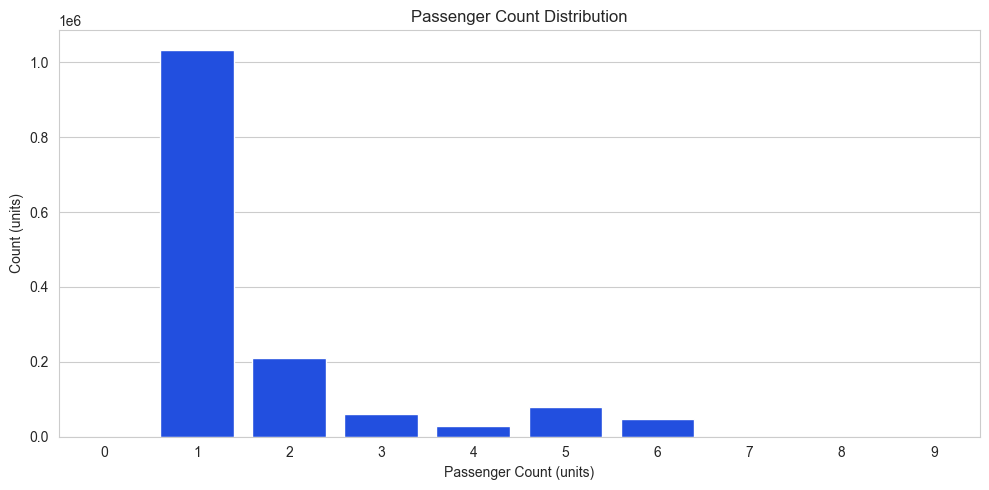

In [49]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
sns.countplot(data=taxi_duration_df_copy_transformed_eda, x='passenger_count', ax=ax)

ax.set_title('Passenger Count Distribution')
ax.set_xlabel('Passenger Count (units)')
ax.set_ylabel('Count (units)')

plt.tight_layout()
plt.show()

In [50]:
get_percentage_cat_col(taxi_duration_df_copy_transformed_eda, 'passenger_count')

passenger_count
1    70.856220
2    14.418734
5     5.353465
3     4.106280
6     3.313557
4     1.947288
0     0.004113
7     0.000206
9     0.000069
8     0.000069
Name: proportion, dtype: float64

Most taxi trips were with one or two passengers. Also, a higher number of trips were with larger companies of people - 5 and 6 persons. Very small number of trips with higher number of passengers and several trips with no passengers at all, which may be an error from driver - by not specifying the number of passengers or registering fake trips.

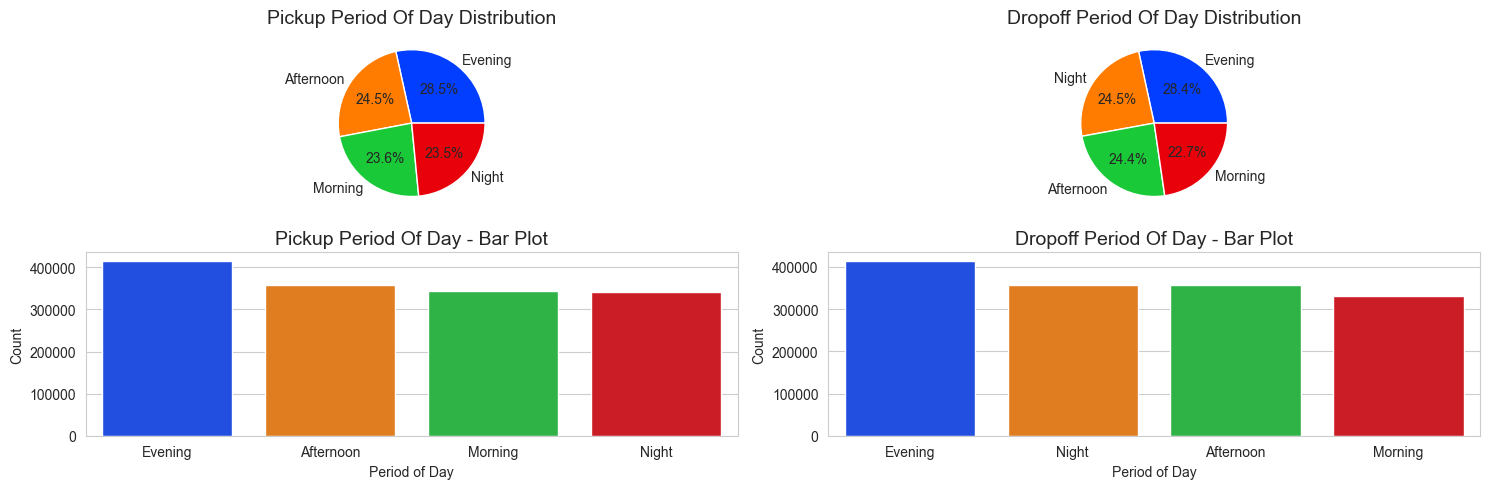

In [51]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 5))
axes = axes.flatten()

for i, col in enumerate(['pickup_period_of_day', 'dropoff_period_of_day']):
    counts = taxi_duration_df_copy_transformed_eda[col].value_counts()
    axes[i].pie(
        counts,
        labels=counts.index,
        autopct='%1.1f%%',
        colors=sns.color_palette('bright', n_colors=len(counts))
    )
    axes[i].set_title(f'{col.replace("_", " ").title()} Distribution', fontsize=14)

    sns.barplot(
        x=counts.index,
        y=counts.values,
        ax=axes[i + 2],
        palette='bright'
    )
    axes[i + 2].set_title(f'{col.replace("_", " ").title()} - Bar Plot', fontsize=14)
    axes[i + 2].set_xlabel('Period of Day')
    axes[i + 2].set_ylabel('Count')

plt.tight_layout()
plt.show()

As it may be seen, most of the taxi trips were done during Evening Time, which is mainly the period of time when people are either finishing their day at work or outside till late night when no public transport is available. Interestingly, based on dropoff period, Night Time Taxi Trips are more common than Afternoon and Morning ones, while at pickup period - it is the least common. Most probably, this is due to the fact that most taxi trips are in the period when Evening switches with Night, that will be investigated below.

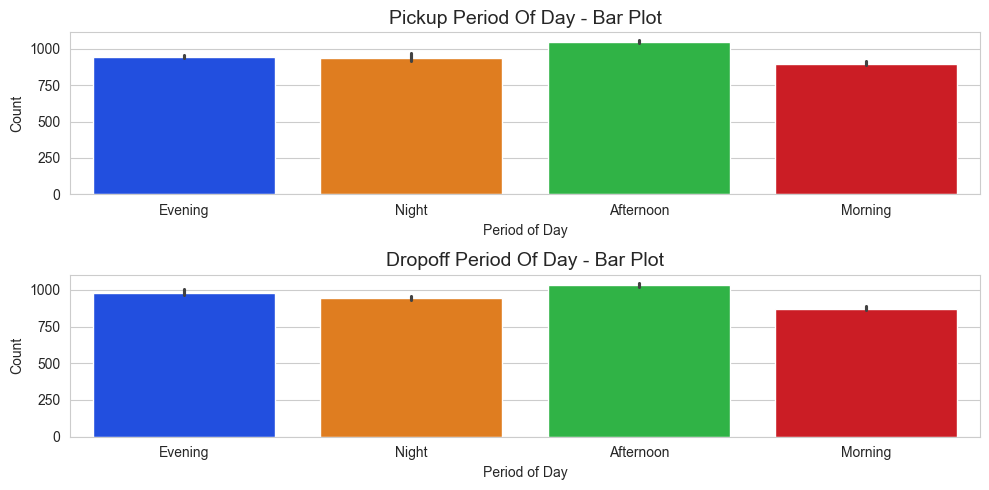

In [52]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 5))
axes = axes.flatten()

for i, col in enumerate(['pickup_period_of_day', 'dropoff_period_of_day']):
    sns.barplot(
        data=taxi_duration_df_copy_transformed_eda,
        x=col,
        y='trip_duration',
        ax=axes[i],
        palette='bright'
    )
    axes[i].set_title(f'{col.replace("_", " ").title()} - Bar Plot', fontsize=14)
    axes[i].set_xlabel('Period of Day')
    axes[i].set_ylabel('Count')

plt.tight_layout()
plt.show()

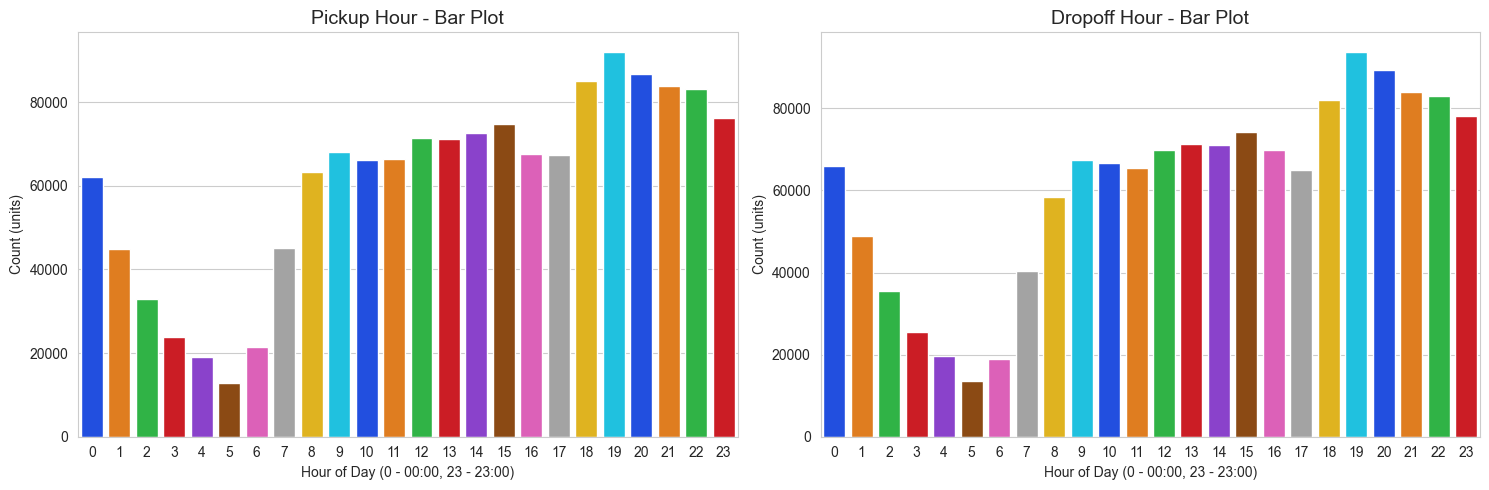

In [53]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

for i, col in enumerate(['pickup_hour', 'dropoff_hour']):
    counts = taxi_duration_df_copy_transformed_eda[col].value_counts()
    sns.barplot(
        x=counts.index,
        y=counts.values,
        ax=axes[i],
        palette='bright'
    )
    axes[i].set_title(f'{col.replace("_", " ").title()} - Bar Plot', fontsize=14)
    axes[i].set_xlabel('Hour of Day (0 - 00:00, 23 - 23:00)')
    axes[i].set_ylabel('Count (units)')

plt.tight_layout()
plt.show()

As it may be seen, most of the trips are done in the Evening, close to Night period of the day, which is logically supporting the above conclusion and observations, that the change in the night trips between dropoff and pickup is supported by the fact that most of the taxi trips are done during the end of the Evening time and start of the Night time.

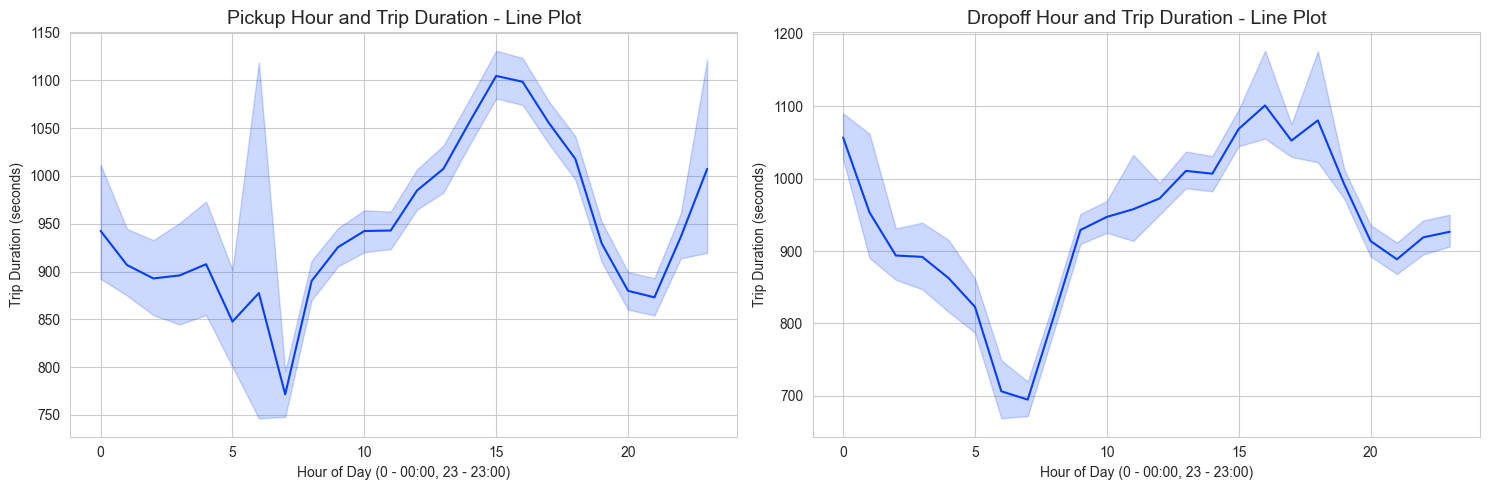

In [54]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

for i, col in enumerate(['pickup_hour', 'dropoff_hour']):
    sns.lineplot(
        x=taxi_duration_df_copy_transformed_eda[col],
        y=taxi_duration_df_copy_transformed_eda['trip_duration'],
        ax=axes[i]
    )
    axes[i].set_title(f'{col.replace("_", " ").title()} and Trip Duration - Line Plot', fontsize=14)
    axes[i].set_xlabel('Hour of Day (0 - 00:00, 23 - 23:00)')
    axes[i].set_ylabel('Trip Duration (seconds)')

plt.tight_layout()
plt.show()

As it may be noticed, based on specific hour of the day when the taxi trip was done, a relationship between it and trip duration is visible. Highest duration is noticed at $\approx$ 14-19, which is in Afternoon, close to Evening period of the day, which is, again, correlated to the flux of road traffic and end of the work day. At the same time, a slight increase during first night hours is visible - $\approx$ 0 - 3, specifically in dropoff period, which is caused by night style of life of people that solicits cabs, since no public transport is available at that hour.

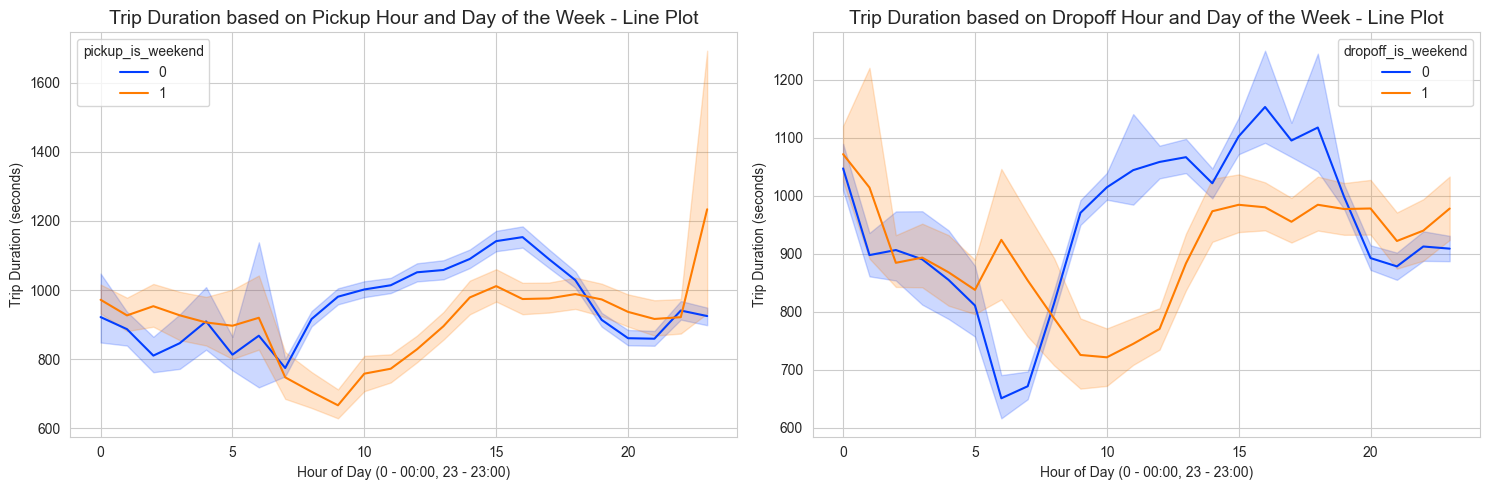

In [55]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

for i, col in enumerate(['pickup_hour', 'dropoff_hour']):
    sns.lineplot(
        x=taxi_duration_df_copy_transformed_eda[col],
        y=taxi_duration_df_copy_transformed_eda['trip_duration'],
        ax=axes[i],
        hue=taxi_duration_df_copy_transformed_eda[f'{col.split(sep='_')[0]}_is_weekend'],
        palette='bright'
    )
    axes[i].set_title(f'Trip Duration based on {col.replace("_", " ").title()} and Day of the Week - Line Plot', fontsize=14)
    axes[i].set_xlabel('Hour of Day (0 - 00:00, 23 - 23:00)')
    axes[i].set_ylabel('Trip Duration (seconds)')

plt.tight_layout()
plt.show()

Judging by the `is_weekend` columns, may be seen that, most of the day, specifically, Afternoon and Evening, the trip duration of taxi trips is lower than in working day, justified by the fact that most people are not working during weekends and traffic is easier. At the same time, slightly higher trip duration is noticed in the morning and night, probably caused by increased activity during nights on weekends - entertainment and so on, as well as higher traffic of people that are going out of town for these days.

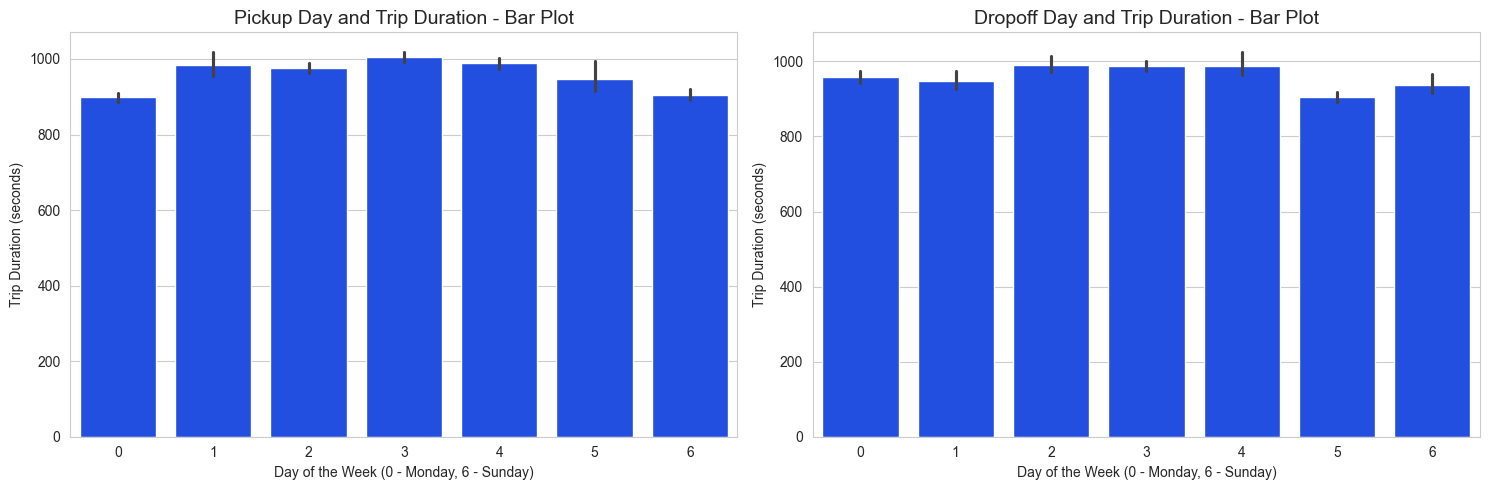

In [56]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

for i, col in enumerate(['pickup_day', 'dropoff_day']):
    sns.barplot(
        x=taxi_duration_df_copy_transformed_eda[col],
        y=taxi_duration_df_copy_transformed_eda['trip_duration'],
        ax=axes[i]
    )
    axes[i].set_title(f'{col.replace("_", " ").title()} and Trip Duration - Bar Plot', fontsize=14)
    axes[i].set_xlabel('Day of the Week (0 - Monday, 6 - Sunday)')
    axes[i].set_ylabel('Trip Duration (seconds)')

plt.tight_layout()
plt.show()

No significant difference based on specific days of the week and trip duration. Slightly higher trip duration during working days of the week compared to the weekends, unsignificant however. 

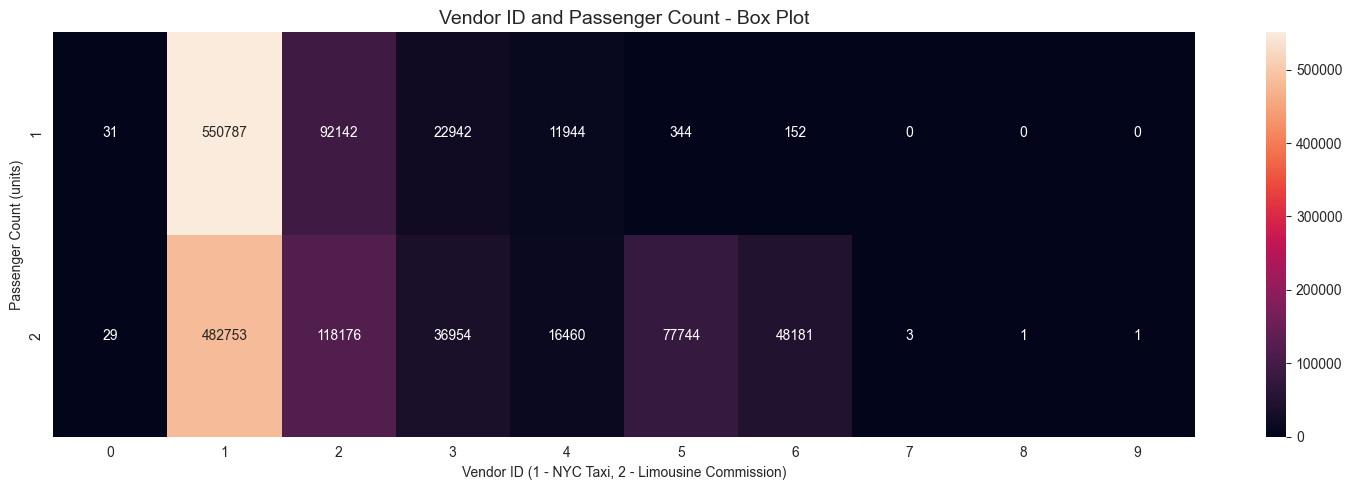

In [57]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))

sns.heatmap(
    pd.crosstab(taxi_duration_df_copy_transformed_eda['vendor_id'], taxi_duration_df_copy_transformed_eda['passenger_count']),
    annot=True,
    fmt='d',
    ax=ax
)
ax.set_title(f'Vendor ID and Passenger Count - Box Plot', fontsize=14)
ax.set_xlabel('Vendor ID (1 - NYC Taxi, 2 - Limousine Commission)')
ax.set_ylabel('Passenger Count (units)')

plt.tight_layout()
plt.show()

As it may be seen, Limousine Commission offers solutions and trips for higher number of passengers ($\ge 2 \text{ passengers}$), since it has cars with higher number of seats and for purposes, such as official meetings and other events.

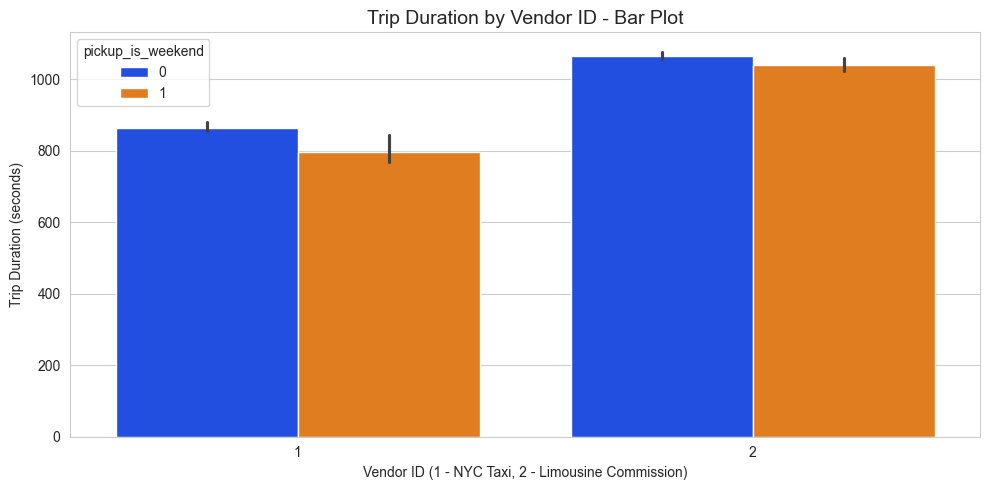

In [58]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

sns.barplot(
    data=taxi_duration_df_copy_transformed_eda,
    x='vendor_id',
    y='trip_duration',
    hue='pickup_is_weekend',
    ax=ax,
)
ax.set_title(f'Trip Duration by Vendor ID - Bar Plot', fontsize=14)
ax.set_xlabel('Vendor ID (1 - NYC Taxi, 2 - Limousine Commission)')
ax.set_ylabel('Trip Duration (seconds)')

plt.tight_layout()
plt.show()

No significant difference between trip duration based on Vendor ID And weekend status. Slightly faster trips are noticed on weekends, which is an observation made even in previous cases, with little correlation between Vendor ID and Weekend Status of the day. However, higher trip duration is noticed for Limousine Commission compared to NYC Taxi.

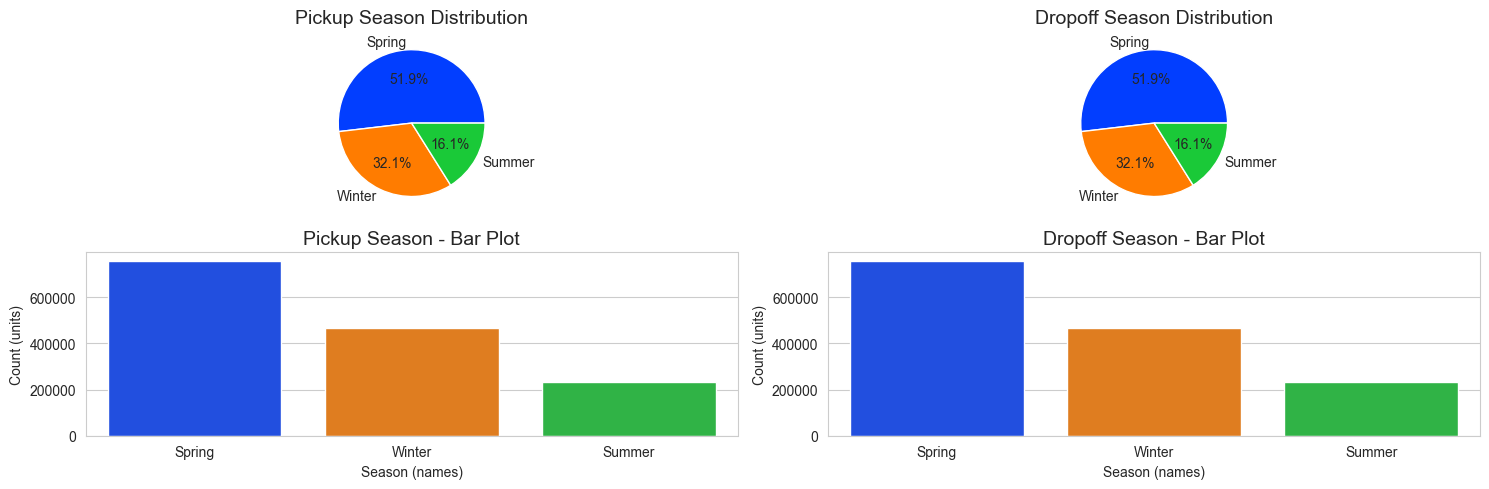

In [59]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 5))
axes = axes.flatten()

for i, col in enumerate(['pickup_season', 'dropoff_season']):
    counts = taxi_duration_df_copy_transformed_eda[col].value_counts()
    axes[i].pie(
        counts,
        labels=counts.index,
        autopct='%1.1f%%',
        colors=sns.color_palette('bright', n_colors=len(counts))
    )
    axes[i].set_title(f'{col.replace("_", " ").title()} Distribution', fontsize=14)

    sns.barplot(
        x=counts.index,
        y=counts.values,
        ax=axes[i + 2],
        palette='bright'
    )
    axes[i + 2].set_title(f'{col.replace("_", " ").title()} - Bar Plot', fontsize=14)
    axes[i + 2].set_xlabel('Season (names)')
    axes[i + 2].set_ylabel('Count (units)')

plt.tight_layout()
plt.show()

No records of taxi trips from Autumn, which is strange. Most of the observations are from Spring Season, and lowest taxi trips were recorded in Summer. Further investigation is required to understand the relationships between other features and seasons.

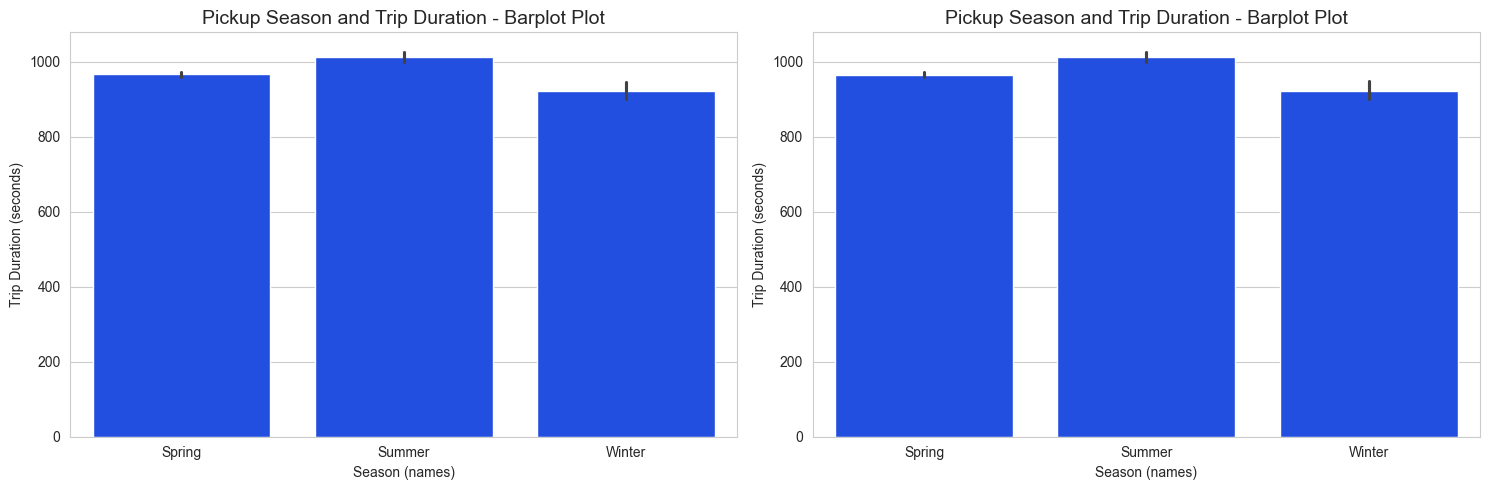

In [60]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

for i, col in enumerate(['pickup_season', 'pickup_season']):
    sns.barplot(
        x=taxi_duration_df_copy_transformed_eda[col],
        y=taxi_duration_df_copy_transformed_eda['trip_duration'],
        ax=axes[i]
    )
    axes[i].set_title(f'{col.replace("_", " ").title()} and Trip Duration - Barplot Plot', fontsize=14)
    axes[i].set_xlabel('Season (names)')
    axes[i].set_ylabel('Trip Duration (seconds)')

plt.tight_layout()
plt.show()

Although lowest number of taxi trips are registered in Summer, this season is the one with the highest average trip duration, probably due to the highest number of people in traffic. On Winter, however, is the lowest trid duration of the taxi trips.

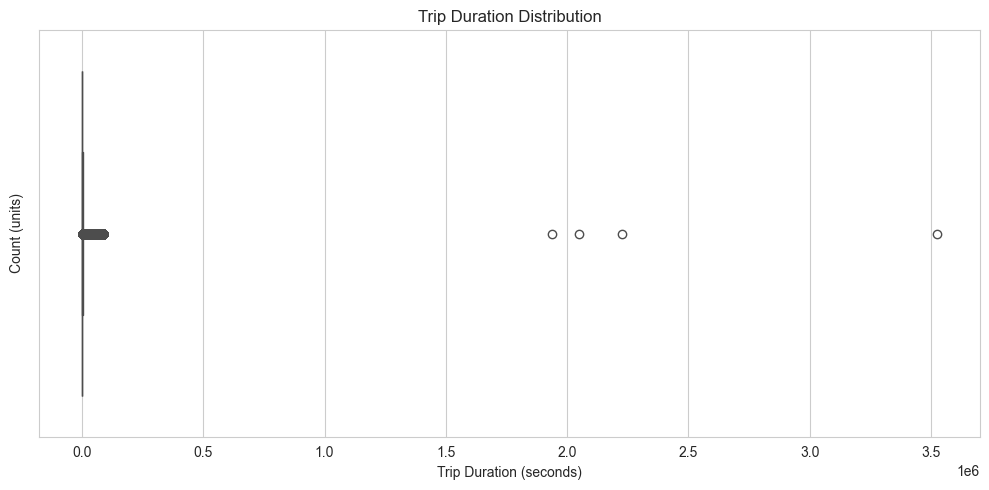

In [61]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
sns.boxplot(data=taxi_duration_df_copy_transformed_eda, x='trip_duration', ax=ax)

ax.set_title('Trip Duration Distribution')
ax.set_xlabel('Trip Duration (seconds)')
ax.set_ylabel('Count (units)')

plt.tight_layout()
plt.show()

Besides records with trip duration equal to zero, there are samples with incredibly high trip durations, which might show anomalies in the dataset, serving as outliers. For the purpose of EDA, was decided to use available Scikit-Learn Outlier Detection Methods and try to get rid of those sample points. But, for the beginning, a simple implementation of boxplot quartiles outlier detection method was done in order to have a basic representation of the data distribution of the target variable.

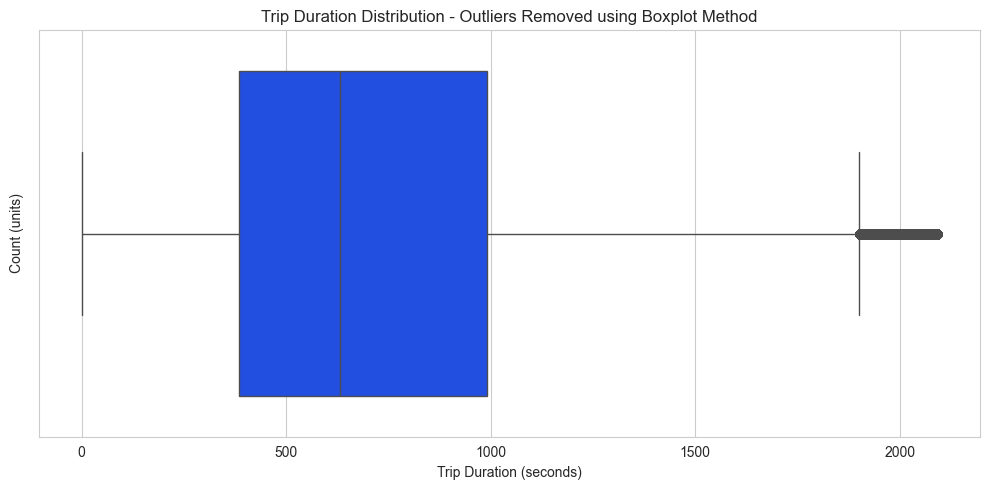

In [62]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

sns.boxplot(data=get_outliers_by_boxplot(df=taxi_duration_df_copy_transformed_eda, col='trip_duration'), x='trip_duration', ax=ax)

ax.set_title('Trip Duration Distribution - Outliers Removed using Boxplot Method')
ax.set_xlabel('Trip Duration (seconds)')
ax.set_ylabel('Count (units)')

plt.tight_layout()
plt.show()

In [63]:
print(f"Number of Outliers removed using BoxPlot Method: {taxi_duration_df_copy_transformed_eda.shape[0] - get_outliers_by_boxplot(df=taxi_duration_df_copy_transformed_eda, col='trip_duration').shape[0]}")
print(f"Total Number of Taxi Trips: {taxi_duration_df_copy_transformed_eda.shape[0]}")
print(f"Number of Non-Outlier Taxi Trips found using BoxPlot Method: {get_outliers_by_boxplot(df=taxi_duration_df_copy_transformed_eda, col='trip_duration').shape[0]}")
print(f"Percentage of Outliers removed using BoxPlot Method: {(taxi_duration_df_copy_transformed_eda.shape[0] - get_outliers_by_boxplot(df=taxi_duration_df_copy_transformed_eda, col='trip_duration').shape[0]) / taxi_duration_df_copy_transformed_eda.shape[0] * 100:.5f}%")
print(f"Percentage of Non-Outliers found using BoxPlot Method: {(get_outliers_by_boxplot(df=taxi_duration_df_copy_transformed_eda, col='trip_duration').shape[0] / taxi_duration_df_copy_transformed_eda.shape[0] * 100):.5f}%")

Number of Outliers removed using BoxPlot Method: 74220
Total Number of Taxi Trips: 1458644
Number of Non-Outlier Taxi Trips found using BoxPlot Method: 1384424
Percentage of Outliers removed using BoxPlot Method: 5.08829%
Percentage of Non-Outliers found using BoxPlot Method: 94.91171%


Now, the distribution is more clear, it is slightly skewed to low values. Median value is close to the center of the Interquartile Box. There are still outliers, but, hopefully, using advanced methods of outlier detection, it will be easier to get the appropriate amount of non-outlier data samples.

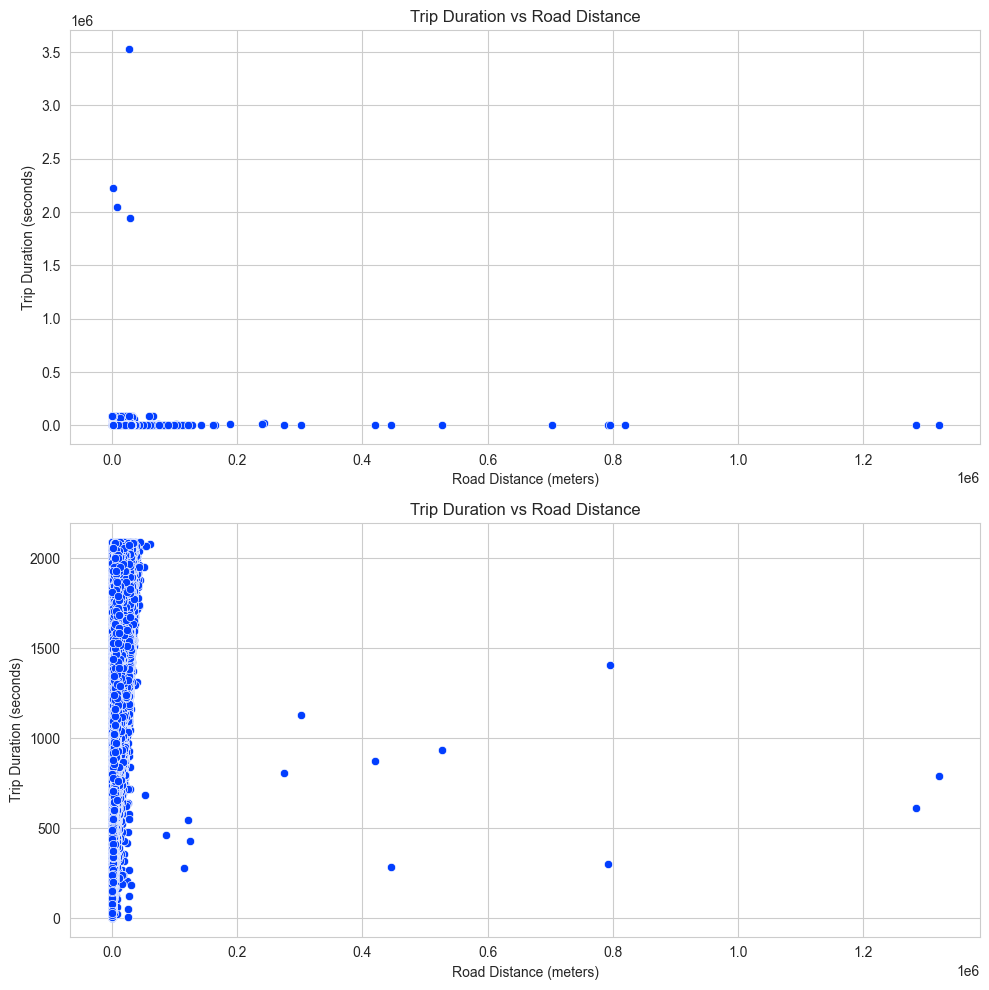

In [64]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
axes = axes.flatten()
for i, ax in enumerate(axes):
    if i == 0:
        sns.scatterplot(data=taxi_duration_df_copy_transformed_eda, x='road_distance', y='trip_duration', ax=ax)
    else:
        sns.scatterplot(data=get_outliers_by_boxplot(df=taxi_duration_df_copy_transformed_eda, col='trip_duration'), x='road_distance', y='trip_duration', ax=ax)

    ax.set_title('Trip Duration vs Road Distance')
    ax.set_xlabel('Road Distance (meters)')
    ax.set_ylabel('Trip Duration (seconds)')

plt.tight_layout()
plt.show()

As it may be noticed, there are samples that have very high Road Distance but Trip Duration, as well as inverse case - high Trip Duration, but very low Road Distance, which should be treated as anomalies. Most probably some passengers, during their trip, cancelled their ride, which could result in those problems, or driver forgot to disengage or engage their meter, which resulted in such anomalies. Per general, higher the road distance, higher the Trip Duration, which is quite logic, but there are still several factors that may come into play, such as: traffic load and so on.

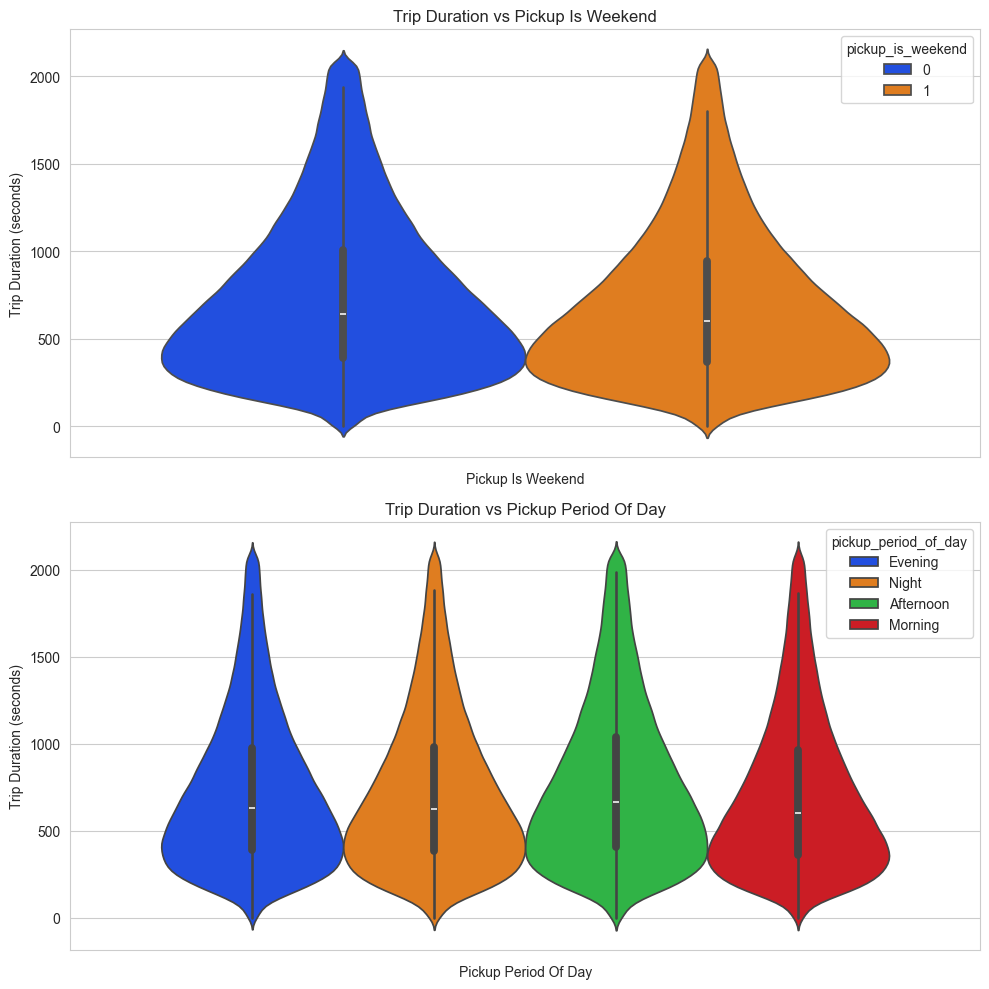

In [65]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
axes = axes.flatten()
for i, ax in enumerate(axes):
    if i == 0:
        sns.violinplot(data=get_outliers_by_boxplot(df=taxi_duration_df_copy_transformed_eda, col='trip_duration'), hue='pickup_is_weekend', y='trip_duration', ax=ax)
    else:
        sns.violinplot(data=get_outliers_by_boxplot(df=taxi_duration_df_copy_transformed_eda, col='trip_duration'), hue='pickup_period_of_day', y='trip_duration', ax=ax)

    ax.set_title(f'Trip Duration vs {' '.join(word.title() for word in 'pickup_is_weekend'.split('_')) if i == 0 else ' '.join(word.title() for word in 'pickup_period_of_day'.split('_'))}')
    ax.set_xlabel(f'{' '.join(word.title() for word in 'pickup_is_weekend'.split('_')) if i == 0 else ' '.join(word.title() for word in 'pickup_period_of_day'.split('_'))}')
    ax.set_ylabel('Trip Duration (seconds)')

plt.tight_layout()
plt.show()

These boxplots confirm the observation from above, on weekdays - traffic trip duration is higher and Afternoon and Night are the most overloaded and result in higher trip duration.

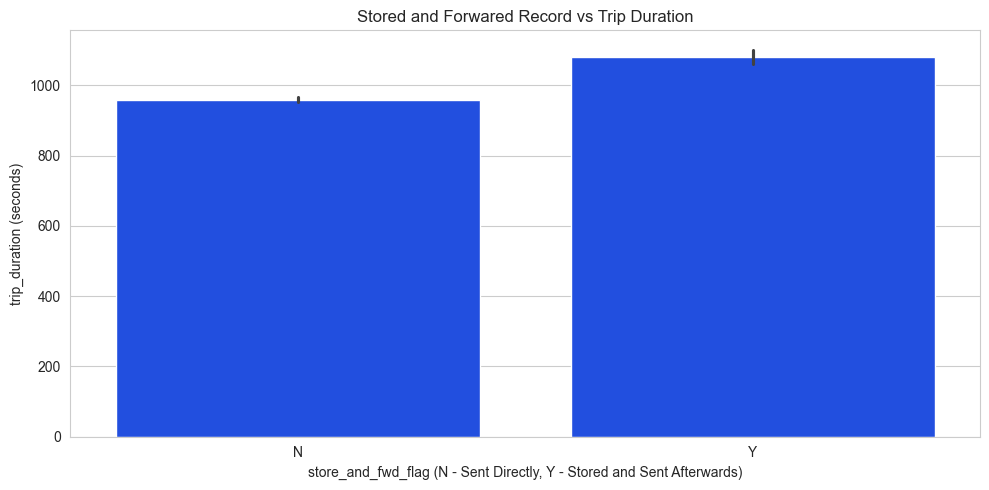

In [66]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
sns.barplot(data=taxi_duration_df_copy_transformed_eda, 
            x='store_and_fwd_flag', 
            y='trip_duration', 
            ax=ax)

ax.set_title('Stored and Forwared Record vs Trip Duration')
ax.set_xlabel('store_and_fwd_flag (N - Sent Directly, Y - Stored and Sent Afterwards)')
ax.set_ylabel('trip_duration (seconds)')

plt.tight_layout()
plt.show()

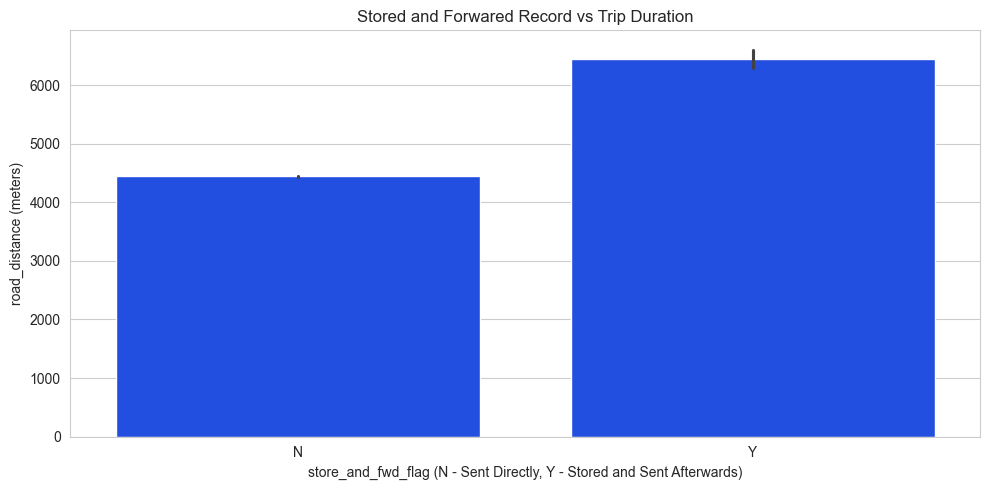

In [67]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
sns.barplot(data=taxi_duration_df_copy_transformed_eda, 
            x='store_and_fwd_flag', 
            y='road_distance',
            ax=ax)

ax.set_title('Stored and Forwared Record vs Trip Duration')
ax.set_xlabel('store_and_fwd_flag (N - Sent Directly, Y - Stored and Sent Afterwards)')
ax.set_ylabel('road_distance (meters)')

plt.tight_layout()
plt.show()

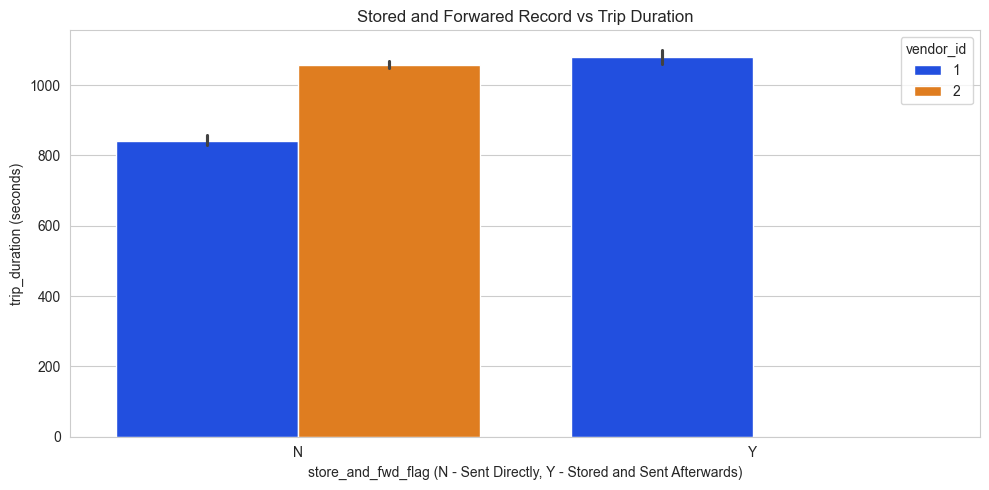

In [68]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
sns.barplot(data=taxi_duration_df_copy_transformed_eda, 
            x='store_and_fwd_flag', 
            y='trip_duration',
            hue='vendor_id', 
            palette='bright',
            ax=ax)

ax.set_title('Stored and Forwared Record vs Trip Duration')
ax.set_xlabel('store_and_fwd_flag (N - Sent Directly, Y - Stored and Sent Afterwards)')
ax.set_ylabel('trip_duration (seconds)')

plt.tight_layout()
plt.show()


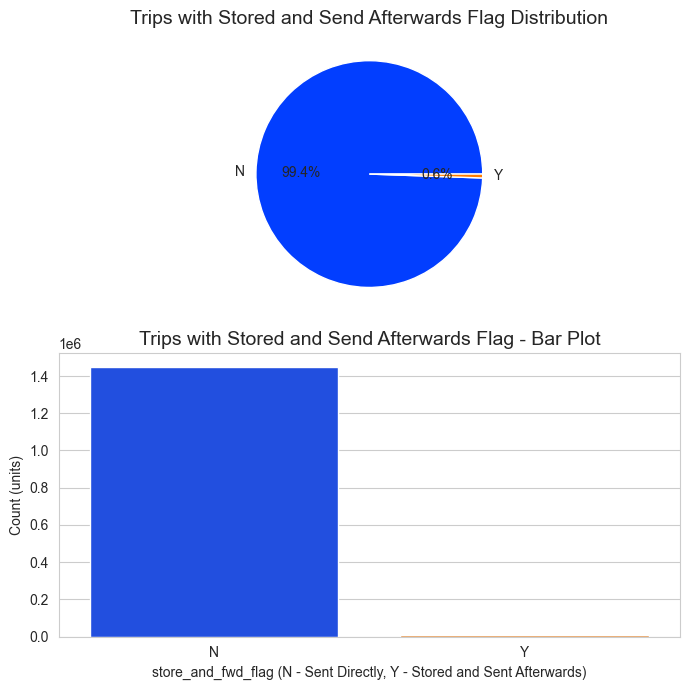

In [69]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(7, 7))
axes = axes.flatten()

counts = taxi_duration_df_copy_transformed_eda['store_and_fwd_flag'].value_counts()
axes[0].pie(
    counts,
    labels=counts.index,
    autopct='%1.1f%%',
    colors=sns.color_palette('bright', n_colors=len(counts))
)
axes[0].set_title(f'Trips with Stored and Send Afterwards Flag Distribution', fontsize=14)

sns.barplot(
    x=counts.index,
    y=counts.values,
    ax=axes[1],
    palette='bright'
)
axes[1].set_title(f'Trips with Stored and Send Afterwards Flag - Bar Plot', fontsize=14)
axes[1].set_xlabel('store_and_fwd_flag (N - Sent Directly, Y - Stored and Sent Afterwards)')
axes[1].set_ylabel('Count (units)')

plt.tight_layout()
plt.show()

In [70]:
print(f"Number of Taxi Trips with Store and Forward Flag: {taxi_duration_df_copy_transformed_eda[taxi_duration_df_copy_transformed_eda['store_and_fwd_flag'] == 'Y'].shape[0]}")
print(f"Total Number of Taxi Trips: {taxi_duration_df_copy_transformed_eda.shape[0]}")
print(f"Percentage of Taxi Trips with Store and Forward Flag: {(taxi_duration_df_copy_transformed_eda[taxi_duration_df_copy_transformed_eda['store_and_fwd_flag'] == 'Y'].shape[0] / taxi_duration_df_copy_transformed_eda.shape[0] * 100):.5f}%")
print(f"Number of Taxi Trips that were sent directly: {taxi_duration_df_copy_transformed_eda[taxi_duration_df_copy_transformed_eda['store_and_fwd_flag'] == 'N'].shape[0]}")
print(f"Percentage of Taxi Trips that were sent directly: {(taxi_duration_df_copy_transformed_eda[taxi_duration_df_copy_transformed_eda['store_and_fwd_flag'] == 'N'].shape[0] / taxi_duration_df_copy_transformed_eda.shape[0] * 100):.5f}%")

Number of Taxi Trips with Store and Forward Flag: 8045
Total Number of Taxi Trips: 1458644
Percentage of Taxi Trips with Store and Forward Flag: 0.55154%
Number of Taxi Trips that were sent directly: 1450599
Percentage of Taxi Trips that were sent directly: 99.44846%


As it may be seen, most of the taxi trips were sent directly to the company, rather than being stored and sent afterwards. This feature might not hold significant information about trip duration, therefore it might as well be dropped similarly to other columns discussed above. On the other hand, there is slight difference between the trip duration grouped by the status of the flag, however, due to the low amount of samples and imbalanced feature, this might not be the most accurate feature, but taken in consideration that for the records that were stored and sent afterwards, the route distance is significantly higher than for those sent directly to the vendor, the relationship might actually be true - records that were not sent directly but stored first and then sent to the agency might include mostly taxi trips with higher road distance and duration.

In [71]:
same_pickup_dropoff_mask = (
    (taxi_duration_df_copy_transformed_eda['pickup_latitude'] == taxi_duration_df_copy_transformed_eda['dropoff_latitude']) & 
    (taxi_duration_df_copy_transformed_eda['pickup_longitude'] == taxi_duration_df_copy_transformed_eda['dropoff_longitude'])
)

In [72]:
num_same_pickup_dropoff = same_pickup_dropoff_mask.sum()
print(f"Number of Taxi Trips with Same Pickup and Dropoff Location: {num_same_pickup_dropoff}")
print(f"Total Number of Taxi Trips: {taxi_duration_df_copy_transformed_eda.shape[0]}")
print(f"Percentage of Taxi Trips with Same Pickup and Dropoff Location: {(num_same_pickup_dropoff / taxi_duration_df_copy_transformed_eda.shape[0] * 100):.5f}%")

Number of Taxi Trips with Same Pickup and Dropoff Location: 5897
Total Number of Taxi Trips: 1458644
Percentage of Taxi Trips with Same Pickup and Dropoff Location: 0.40428%


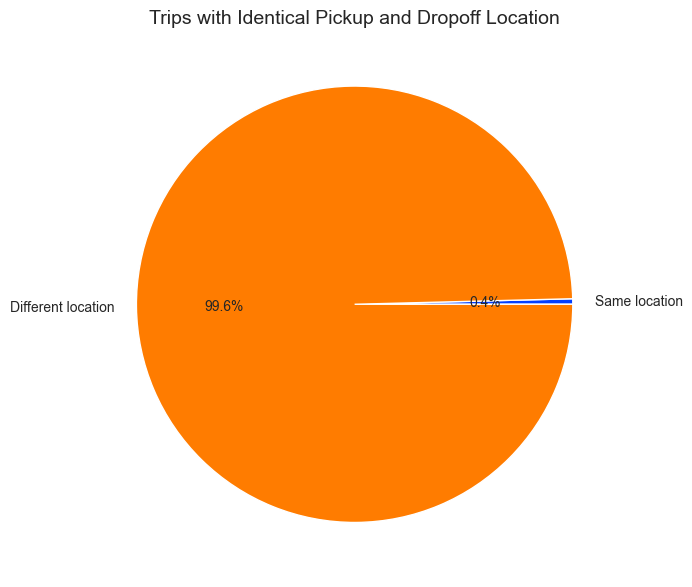

In [73]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 7))

labels  = ['Same location', 'Different location']
sizes   = [num_same_pickup_dropoff, taxi_duration_df_copy_transformed_eda.shape[0] - num_same_pickup_dropoff]

ax.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    colors=sns.color_palette('bright', n_colors=len(counts))
)
ax.set_title(f'Trips with Identical Pickup and Dropoff Location', fontsize=14)

plt.tight_layout()
plt.show()

Since there are records with same pickup and dropoff latitude and longitude, these records should be either dropped or their trip duration set to 0, in order to make model predict more accurate this case. However, there is a small percentage of this kind of trips, therefore they might be dropped.

## Missing Values
In order to understand better the dataset and be able to train a successful model, a missing values analysis should be done. This will help see if there are missing values in the dataset.

In [74]:
print(taxi_duration_df.isnull().sum())

id                       0
vendor_id                0
pickup_datetime          0
dropoff_datetime         0
passenger_count          0
pickup_longitude         0
pickup_latitude          0
dropoff_longitude        0
dropoff_latitude         0
store_and_fwd_flag       0
trip_duration            0
road_distance            0
pickup_month             0
pickup_day               0
pickup_hour              0
pickup_period_of_day     0
pickup_is_weekend        0
pickup_season            0
dropoff_month            0
dropoff_day              0
dropoff_hour             0
dropoff_period_of_day    0
dropoff_is_weekend       0
dropoff_season           0
dtype: int64


No missing values were found in the dataset, therefore no imputation of null values should be done.

## Post-EDA Feature Enginering
Since EDA gave several useful insights into the dataset nature and variable distribution, a post-EDA Feature Engineering should be done. This includes manipulations with existing features, that might include the conversion from string categories to numerical values, in order to be used at model training step.

In [75]:
datetime_transformer_model_fe = FunctionTransformer(extract_datetime_features_fe, kw_args={'dt_cols': ['pickup_datetime']}, validate=False)
datetime_transformer_model_bp = FunctionTransformer(extract_datetime_features_bp, kw_args={'dt_cols': ['pickup_datetime']}, validate=False)

In [76]:
def remove_same_location_rows(X: pd.DataFrame, y: pd.Series = None) -> pd.DataFrame | tuple[pd.DataFrame, pd.Series]:
    same_pickup_dropoff_mask = (
        (X['pickup_latitude'] == X['dropoff_latitude']) & 
        (X['pickup_longitude'] == X['dropoff_longitude'])
    )
    if y is not None:
        return X[~same_pickup_dropoff_mask], y[~same_pickup_dropoff_mask]
    else:
        return X[~same_pickup_dropoff_mask]

In [77]:
drop_same_location_transformer = FunctionTransformer(remove_same_location_rows, validate=False)

In [78]:
transformer_dropper_first = ColumnTransformer([
    ('drop', 'drop', ['dropoff_datetime', 'id'])
], 
remainder='passthrough', 
verbose_feature_names_out=False
).set_output(transform='pandas')

In [79]:
transformer_convertor = ColumnTransformer([
    ('datetime', datetime_transformer_model_fe, ['pickup_datetime']),
    ('distance', distance_transformer, location_columns),
], 
remainder='passthrough', 
verbose_feature_names_out=False
).set_output(transform='pandas')

In [80]:
transformer_dropper = ColumnTransformer([
    ('drop', 'drop', ['pickup_datetime'])
], 
remainder='passthrough', 
verbose_feature_names_out=False
).set_output(transform='pandas')

In [81]:
# encoder_transformer = ColumnTransformer(
#     transformers=[
#         ('binary encode with drop', OneHotEncoder(sparse_output=False, drop='first'), ['store_and_fwd_flag', 'pickup_period_of_day']),
#         ('binary encode without drop', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), ['pickup_season']),
#         # ('multiclass encode', TargetEncoder(), ['pickup_season', 'pickup_period_of_day'])
#     ],
#     remainder='passthrough',
#     verbose_feature_names_out=False
# ).set_output(transform='pandas')

encoder_transformer = ColumnTransformer([
    ('binary encode with drop', OneHotEncoder(sparse_output=False, drop='first'), ['store_and_fwd_flag']),
    ('encode', OrdinalEncoder(), ['pickup_season', 'pickup_period_of_day']),
], 
remainder='passthrough', 
verbose_feature_names_out=False
).set_output(transform='pandas')

In [82]:
pipeline = Pipeline(
    steps=[
        ('drop_first', transformer_dropper_first),
        ('remove_same_location', drop_same_location_transformer),
        ('feature_engineering', transformer_convertor),
        ('drop_columns', transformer_dropper),
        ('encoder', encoder_transformer),
    ]
).set_output(transform='pandas')

In [83]:
taxi_duration_df_copy_transformed = pipeline.fit_transform(taxi_duration_df_copy)

Convert pickup_datetime to DateTime:   0%|          | 0/1452747 [00:00<?, ?it/s]

Convert pickup_datetime to DateTime:   0%|          | 0/1452747 [00:00<?, ?it/s]

Convert pickup_datetime to DateTime:   0%|          | 0/1452747 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/33 [00:00<?, ?it/s]

In [84]:
taxi_duration_df_copy_transformed

,store_and_fwd_flag_Y,pickup_season,pickup_period_of_day,pickup_month,pickup_day,pickup_hour,pickup_is_weekend,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,road_distance,vendor_id,passenger_count,trip_duration
0,0.0,0.0,1.0,3,0,17,0,40.767937,-73.982155,40.765602,-73.964630,1737.385329,2,1,455
1,0.0,1.0,3.0,6,6,1,1,40.738564,-73.980415,40.731152,-73.999481,2433.239937,1,1,663
2,0.0,2.0,0.0,1,1,12,0,40.763939,-73.979027,40.710087,-74.005333,8212.802551,2,1,2124
3,0.0,0.0,1.0,4,2,20,0,40.719971,-74.010040,40.706718,-74.012268,1663.199924,2,1,429
4,0.0,0.0,0.0,3,5,14,1,40.793209,-73.973053,40.782520,-73.972923,1200.805926,2,1,435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,0.0,0.0,0.0,4,4,14,0,40.745522,-73.982201,40.740170,-73.994911,1667.768688,2,4,778
1458640,0.0,2.0,2.0,1,6,8,1,40.747379,-74.000946,40.796547,-73.970184,8067.644541,1,1,655
1458641,0.0,0.0,2.0,4,4,7,0,40.768799,-73.959129,40.707371,-74.004433,10657.620193,2,1,764
1458642,0.0,2.0,0.0,1,1,16,0,40.749062,-73.982079,40.757107,-73.974632,1523.561588,1,1,373


## Feature Selection
In order to avoid multicollinearity and high-dimensionality of the dataset, Feature Selection may be used. For example, there are several methods of detecting the most important features, avoiding 'useless' features.

### P-Value Based Selector


In [85]:
pvalue_selector = PValueSelector()
selected_columns_pvalue = pvalue_selector.select(dataframe=taxi_duration_df_copy_transformed, y_column='trip_duration')
selected_columns_pvalue

['pickup_period_of_day',
 'pickup_month',
 'pickup_day',
 'pickup_hour',
 'pickup_is_weekend',
 'pickup_longitude',
 'dropoff_latitude',
 'road_distance',
 'vendor_id',
 'passenger_count']

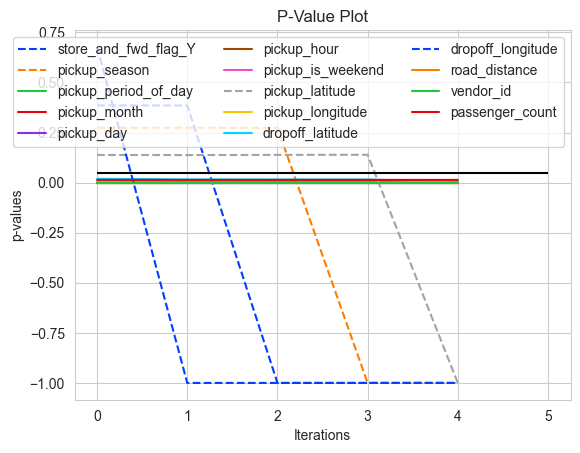

In [86]:
pvalue_selector.plot_process()

### Correlation Matrix

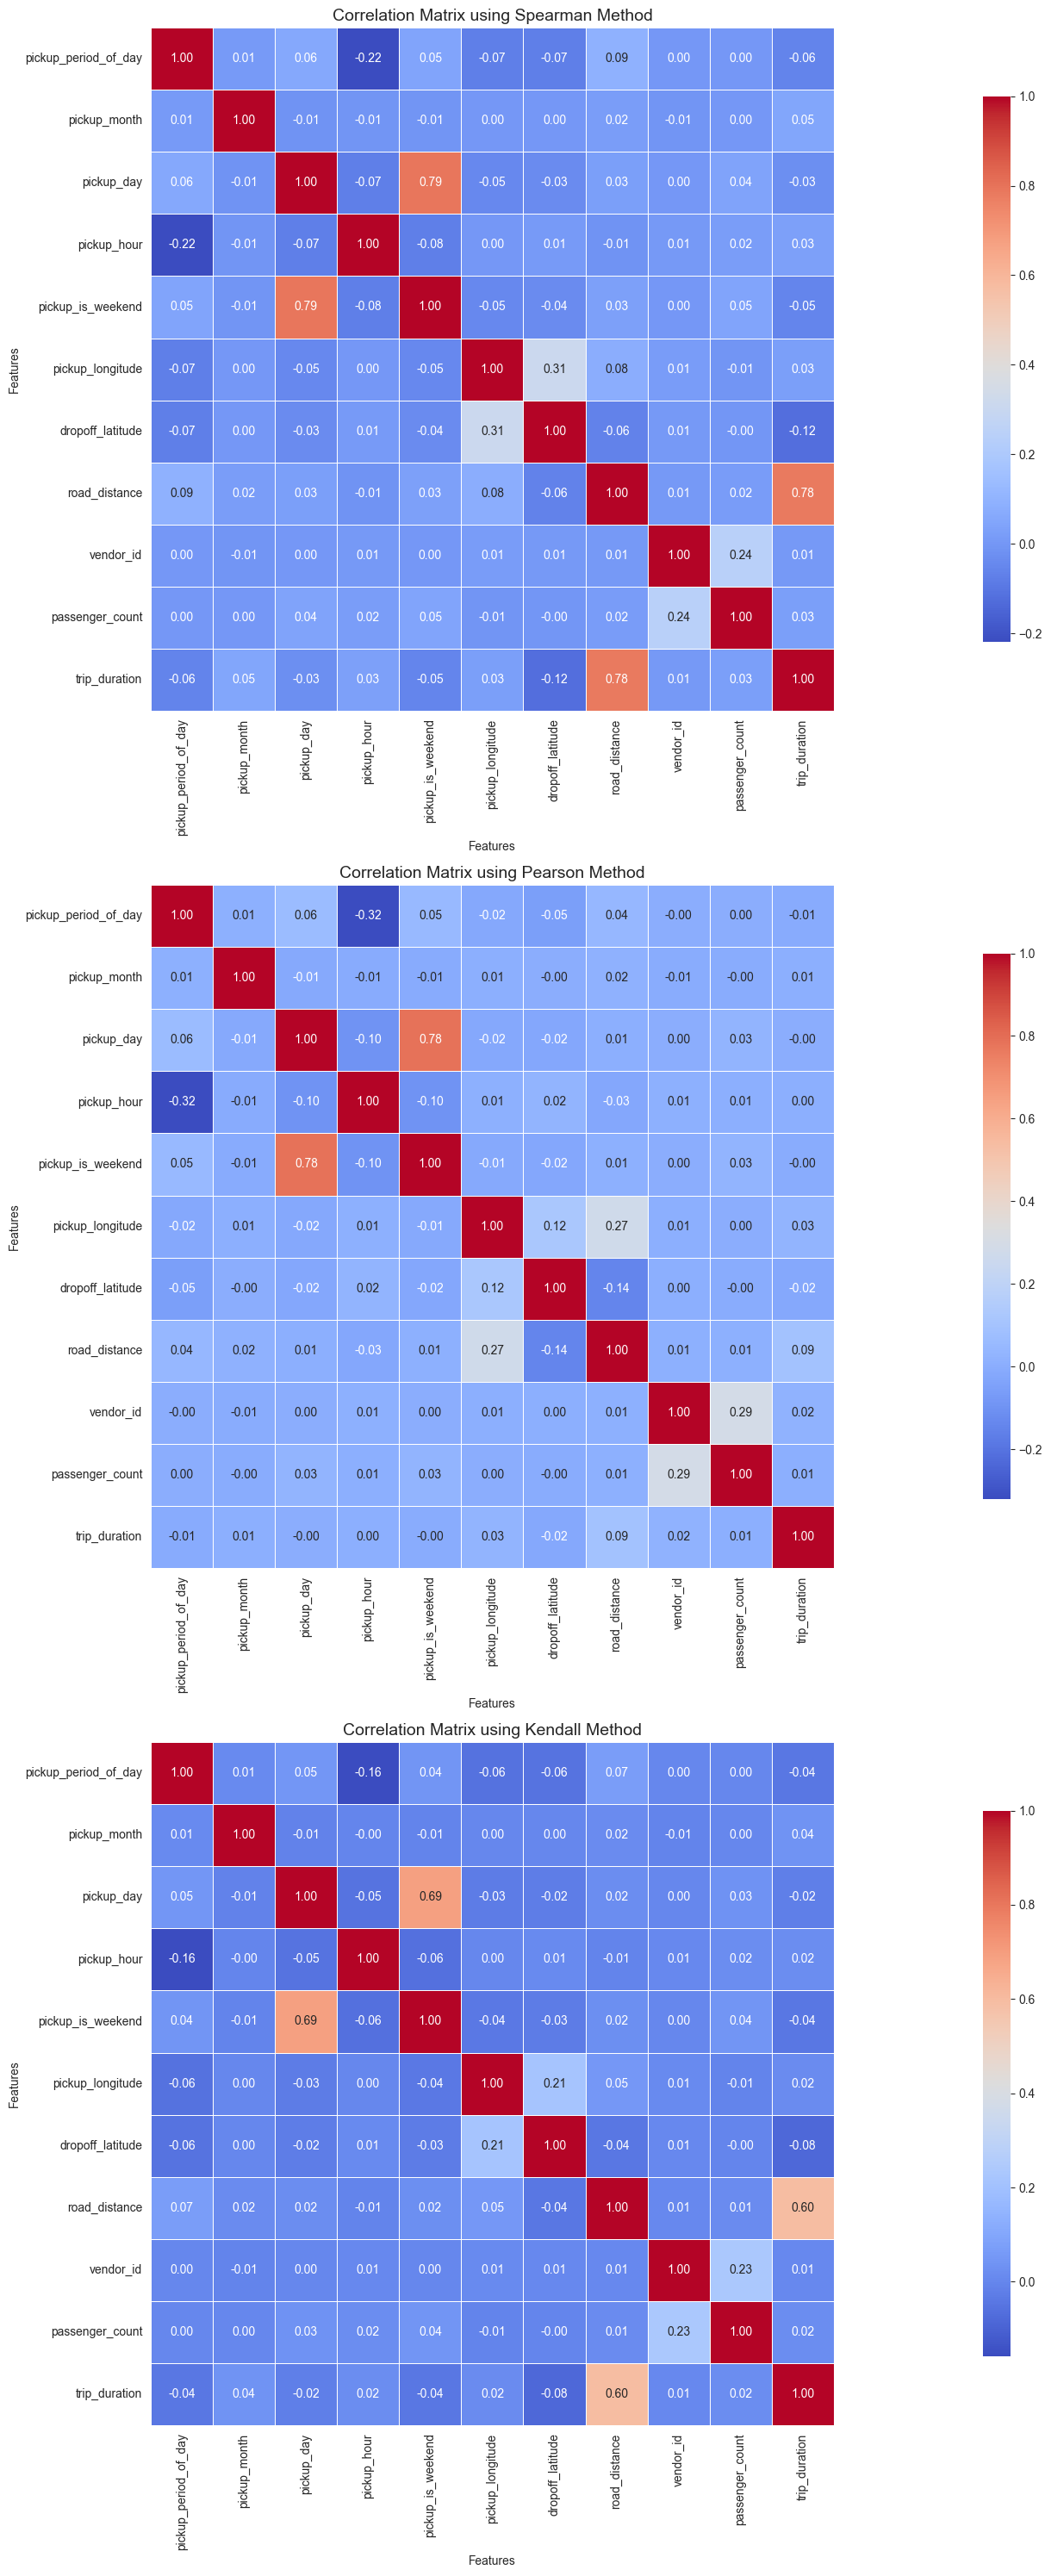

In [87]:
methods = ['spearman', 'pearson', 'kendall']
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(35, 30))
axes = axes.flatten()

for i, method in enumerate(methods):
    corr_matrix = taxi_duration_df_copy_transformed[selected_columns_pvalue + ['trip_duration']].corr(method=method)

    sns.heatmap(
        corr_matrix,
        annot=True,
        fmt='.2f',
        cmap='coolwarm',
        square=True,
        cbar_kws={'shrink': 0.8},
        linewidths=0.5,
        ax=axes[i]
    )
    axes[i].set_title(f'Correlation Matrix using {method.capitalize()} Method', fontsize=14)
    axes[i].set_xlabel('Features')
    axes[i].set_ylabel('Features')

plt.tight_layout()
plt.show()

## Model Selection

For the models, were analyzed the following options:
1. **Random Forest Regressor**, since it is robust to outliers and does not require scaling of the features to be done;
2. **XGBoost**, similar concept as Random Forest, but different implementation. It builds sequentially Decision Trees and each new tree corrects errors made by the previous ones. It is suitable when the dataset is large, as it is a fast algorithm, again - robust to outliers and feature scale;
3. **LightGBM**, similar to XGBoost, with slightly different tree building mechanism, faster training time, but less likely to find a generalized model and is less robust to outliers and noise in dataset.
3. **Linear Regression** - the most basic regressor, find the best fit line, offers fast computations and straight-forward interpretation of the results;
4. **Support Vector Machine** - powerful ML Model, but it requires data be standardized, which expects the data adhere to Gaussian Distribution. However, as it was described above, not all features are following this distribution. At the same time, SVMs are not the best suitable solution for large datasets, since it is computationally intensive and its training may take a lot of time;
5. **K-Nearest Neighbors Regressor** - again, very computational intensive algorithm, that requires constant calculations of the distances between points. Thus, it is not the best option suitable for this task.

Were selected the following models due to their fast training speed and handling of large datasets, as well as, specifically for LightGBM and XGBoost, which are built upon Random Forest Regressor Model, with addition of different logic behind prediction making and optimized handling of tabular data:
1. **LightGBM**;
2. **XGBoost**;
3. **Linear Regression**.

## Model Training - Baseline Performance

In order to observe the efficiency of planned manipulations with dataset and model training and to compare it with the default model behavior on the minimally edited dataset, that will ensure compatibility with model fit and predict methods, a training a model with default parameters is used, which is known as baseline performance.

In [88]:
def create_pipeline(steps: list[tuple[str, BaseEstimator]]) -> Pipeline:
    return Pipeline(steps=steps).set_output(transform='pandas')

In [89]:
# def create_pipeline_fe_bp() -> Pipeline:
#     transformer_dropper_first = ColumnTransformer([
#         ('drop', 'drop', ['dropoff_datetime', 'id'])
#     ], 
#     remainder='passthrough', 
#     verbose_feature_names_out=False
#     ).set_output(transform='pandas')

#     transformer_convertor = ColumnTransformer([
#         ('datetime', datetime_transformer_model_bp, ['pickup_datetime'])
#     ], 
#     remainder='passthrough', 
#     verbose_feature_names_out=False
#     ).set_output(transform='pandas')

#     transformer_dropper = ColumnTransformer([
#         ('drop', 'drop', ['pickup_datetime'])
#     ], 
#     remainder='passthrough', 
#     verbose_feature_names_out=False
#     ).set_output(transform='pandas')

#     encoder_transformer = ColumnTransformer([
#         ('binary encode with drop', OneHotEncoder(sparse_output=False, drop='first'), ['store_and_fwd_flag']),
#     ], 
#     remainder='passthrough', 
#     verbose_feature_names_out=False
#     ).set_output(transform='pandas')

#     pipeline_steps = [
#         ('drop_first', transformer_dropper_first),
#         ('datetime_transformation', transformer_convertor),
#         ('drop_pickup_datetime', transformer_dropper),
#         ('encode_flag', encoder_transformer)
#     ]

#     return Pipeline(steps=pipeline_steps)

#### Preparation of the subsets

1. `_zip` - only `train.csv` is used, for local score determination, model is trained on a subset of the Kaggle training set;
2. `_sub` - both `train.csv` and `test.csv` are used, for Kaggle submission of the predictions.

In [90]:
taxi_training_df = pd.read_csv('dataset/train.csv')
taxi_test_df = pd.read_csv('dataset/test.csv')

In [91]:
taxi_subset_training_df, taxi_subset_test_df = train_test_split(taxi_training_df, test_size=0.2, random_state=42)

In [92]:
X_train_zip, X_test_zip, y_train_zip, y_test_zip = train_test_split(
    taxi_subset_training_df.drop(columns=['trip_duration']),
    taxi_subset_training_df['trip_duration'],
    test_size=0.2,
    random_state=42
)

In [93]:
X_train_sub = taxi_training_df.drop(columns=['trip_duration'])
y_train_sub = taxi_training_df['trip_duration']
X_test_sub = taxi_test_df

##### Log Transformation
Since `trip_duration` column is very skewed, was suggested to perfom log transformation in order to compensate this and bring to more normal distribution

In [94]:
y_train_zip_log = pd.Series(np.log1p(y_train_zip), 
                               index=X_train_zip.index, 
                               name='trip_duration'
                               )
y_test_zip_log = pd.Series(np.log1p(y_test_zip), 
                               index=X_test_zip.index, 
                               name='trip_duration'
                               )

In [95]:
y_train_sub_log = pd.Series(np.log1p(y_train_sub), 
                               index=X_train_sub.index, 
                               name='trip_duration'
                               )

##### Basic Transformations
Below are Transformers that are slightly changing the dataset in order to make model training possible (`DateTime` conversion and extraction of hour, day and month, encoding `store_and_fwd_flag` binary feature, dropping original `DateTime` columns)

In [96]:
transformer_dropper_first = ColumnTransformer([
    ('drop', 'drop', ['id', 'dropoff_datetime'])
], 
remainder='passthrough', 
verbose_feature_names_out=False
).set_output(transform='pandas')

transformer_convertor = ColumnTransformer([
    ('datetime', datetime_transformer_model_bp, ['pickup_datetime'])
], 
remainder='passthrough', 
verbose_feature_names_out=False
).set_output(transform='pandas')

transformer_dropper = ColumnTransformer([
    ('drop', 'drop', ['pickup_datetime'])
], 
remainder='passthrough', 
verbose_feature_names_out=False
).set_output(transform='pandas')

encoder_transformer = ColumnTransformer([
    ('binary encode with drop', OneHotEncoder(sparse_output=False, drop='first'), ['store_and_fwd_flag']),
], 
remainder='passthrough', 
verbose_feature_names_out=False
).set_output(transform='pandas')

In [97]:
pipeline_steps = [
    ('drop_first', transformer_dropper_first),
    ('datetime_transformation', transformer_convertor),
    ('drop_pickup_datetime', transformer_dropper),
    ('encode_flag', encoder_transformer)
]

In [98]:
baseline_engineering_pipeline = create_pipeline(steps=pipeline_steps)

In [99]:
X_train_zip_bp = baseline_engineering_pipeline.fit_transform(X=X_train_zip, y=y_train_zip_log)
X_test_zip_bp = baseline_engineering_pipeline.transform(X=X_test_zip)

In [100]:
baseline_engineering_pipeline = create_pipeline(steps=pipeline_steps)

In [101]:
X_train_sub_bp = baseline_engineering_pipeline.fit_transform(X=X_train_sub, y=y_train_sub_log)
X_test_sub_bp = baseline_engineering_pipeline.transform(X=X_test_sub)

### Light Gradient Boost Model (LightGBM)

In [102]:
lightgbm_regressor = LGBMRegressor(objective='regression', 
                                   metric = 'rmse', 
                                   n_jobs=-1, 
                                   random_state=42, 
                                   device='gpu', 
                                   verbose=2)

#### Local Scoring Training

In [103]:
lightgbm_regressor.fit(X=X_train_zip_bp, y=y_train_zip_log)

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.851873
[LightGBM] [Info] Total Bins 1071
[LightGBM] [Info] Number of data points in the train set: 933532, number of used features: 10
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 Ti Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (7.12 MB) transferred to GPU in 0.012448 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 6.466696
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 

LGBMRegressor(device='gpu', metric='rmse', n_jobs=-1, objective='regression',
              random_state=42, verbose=2)

In [104]:
y_hat_zip_bp_log = lightgbm_regressor.predict(X=X_test_zip_bp)
y_hat_zip_bp = pd.Series(np.expm1(y_hat_zip_bp_log),
                         index=X_test_zip_bp.index,
                         name='trip_duration'
                         )

In [105]:
y_hat_zip_bp[y_hat_zip_bp < 0]

Series([], Name: trip_duration, dtype: float64)

In [106]:
print(f"MAE: {mean_absolute_error(y_true=y_test_zip, y_pred=y_hat_zip_bp):.2f}")
print(f"MSE: {mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_bp):.2f}")
print(f"RMSE: {root_mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_bp):.2f}")
print(f"R2: {r2_score(y_true=y_test_zip, y_pred=y_hat_zip_bp):.2f}")
print(f"RMSLE: {root_mean_squared_log_error(y_true=y_test_zip, y_pred=y_hat_zip_bp):.2f}")

MAE: 344.14
MSE: 10190101.11
RMSE: 3192.19
R2: 0.03
RMSLE: 0.49


In [107]:
pd.concat([y_test_zip, y_hat_zip_bp], axis=1).rename(columns={'trip_duration': 'y_true', 'trip_duration': 'y_pred'})

,y_pred,y_pred
1298895,363,491.868617
702763,524,661.921174
1094869,256,382.501930
348453,528,669.012392
445599,1164,824.016199
...,...,...
762043,1036,597.471907
731741,1097,797.783216
285926,374,357.642808
887221,545,463.164389


#### Kaggle Submission Training

In [108]:
lightgbm_regressor = LGBMRegressor(objective='regression', 
                                   metric = 'rmse', 
                                   n_jobs=-1, 
                                   random_state=42, 
                                   device='gpu', 
                                   verbose=2)

In [109]:
lightgbm_regressor.fit(X=X_train_sub_bp, y=y_train_sub_log)

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.851738
[LightGBM] [Info] Total Bins 1072
[LightGBM] [Info] Number of data points in the train set: 1458644, number of used features: 10
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 Ti Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (11.13 MB) transferred to GPU in 0.020394 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 6.466978
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth

LGBMRegressor(device='gpu', metric='rmse', n_jobs=-1, objective='regression',
              random_state=42, verbose=2)

In [110]:
y_hat_sub_bp_log = lightgbm_regressor.predict(X=X_test_sub_bp)
y_hat_sub_bp = pd.Series(np.expm1(y_hat_sub_bp_log),
                         index=X_test_sub_bp.index,
                         name='trip_duration'
                         )

In [111]:
y_hat_sub_bp[y_hat_sub_bp < 0]

Series([], Name: trip_duration, dtype: float64)

In [112]:
df_test_raw = pd.read_csv('dataset/test.csv')
df_submission = pd.DataFrame({'id': df_test_raw['id'], 'trip_duration': y_hat_sub_bp})

df_submission.to_csv(f'dataset/submission_default_bp_lightgbm.csv', index=False)

Kaggle Score: `0.49362 | 0.49384`

### eXtreme Gradient Boosting (XGBoost)

In [113]:
xgboost_regressor = XGBRegressor(n_jobs=-1, 
                                 random_state=42, 
                                 device='gpu', 
                                 verbosity=2)

#### Local Scoring Training

In [114]:
xgboost_regressor.fit(X=X_train_zip_bp, y=y_train_zip_log)

[23:59:31] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (933532, 10, 9335320).
[23:59:31] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\ellpack_page.cu:167: Ellpack is dense.


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='gpu', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=-1, num_parallel_tree=None, ...)

In [115]:
y_hat_zip_bp_log = xgboost_regressor.predict(X=X_test_zip_bp)
y_hat_zip_bp = pd.Series(np.expm1(y_hat_zip_bp_log),
                         index=X_test_zip_bp.index,
                         name='trip_duration'
                         )

d:\Programming\Projects\Sigmoid\.venv\Lib\site-packages\xgboost\core.py:729: UserWarning: [23:59:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


In [116]:
y_hat_zip_bp[y_hat_zip_bp < 0]

Series([], Name: trip_duration, dtype: float32)

In [117]:
print(f"MAE: {mean_absolute_error(y_true=y_test_zip, y_pred=y_hat_zip_bp):.2f}")
print(f"MSE: {mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_bp):.2f}")
print(f"RMSE: {root_mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_bp):.2f}")
print(f"R2: {r2_score(y_true=y_test_zip, y_pred=y_hat_zip_bp):.2f}")
print(f"RMSLE: {root_mean_squared_log_error(y_true=y_test_zip, y_pred=y_hat_zip_bp):.2f}")

MAE: 319.81
MSE: 10161021.00
RMSE: 3187.64
R2: 0.03
RMSLE: 0.44


In [118]:
pd.concat([y_test_zip, y_hat_zip_bp], axis=1).rename(columns={'trip_duration': 'y_true', 'trip_duration': 'y_pred'})

,y_pred,y_pred
1298895,363,495.946686
702763,524,599.166016
1094869,256,447.078125
348453,528,674.909302
445599,1164,1067.107056
...,...,...
762043,1036,811.168640
731741,1097,1315.331909
285926,374,325.218719
887221,545,502.147736


#### Kaggle Submission Training

In [119]:
xgboost_regressor = XGBRegressor(n_jobs=-1, 
                                 random_state=42, 
                                 device='gpu', 
                                 verbosity=2)

In [120]:
xgboost_regressor.fit(X=X_train_sub_bp, y=y_train_sub_log)

[23:59:32] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (1458644, 10, 14586440).
[23:59:32] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\ellpack_page.cu:167: Ellpack is dense.


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='gpu', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=-1, num_parallel_tree=None, ...)

In [121]:
y_hat_sub_bp_log = xgboost_regressor.predict(X=X_test_sub_bp)
y_hat_sub_bp = pd.Series(np.expm1(y_hat_sub_bp_log),
                         index=X_test_sub_bp.index,
                         name='trip_duration'
                         )

In [122]:
y_hat_sub_bp[y_hat_sub_bp < 0]

Series([], Name: trip_duration, dtype: float32)

In [123]:
df_test_raw = pd.read_csv('dataset/test.csv')
df_submission = pd.DataFrame({'id': df_test_raw['id'], 'trip_duration': y_hat_sub_bp})

df_submission.to_csv(f'dataset/submission_default_bp_xgboost.csv', index=False)

Kaggle Score: `0.44603 | 0.44743`

### Linear Regression

In [124]:
linear_regressor = LinearRegression(n_jobs=-1)

#### Local Scoring Training

In [125]:
linear_regressor.fit(X=X_train_zip_bp, y=y_train_zip_log)

LinearRegression(n_jobs=-1)

In [126]:
y_hat_zip_bp_log = linear_regressor.predict(X=X_test_zip_bp)
y_hat_zip_bp = pd.Series(np.expm1(y_hat_zip_bp_log),
                         index=X_test_zip_bp.index,
                         name='trip_duration'
                         )

In [127]:
y_hat_zip_bp[y_hat_zip_bp < 0]

Series([], Name: trip_duration, dtype: float64)

In [128]:
print(f"MAE: {mean_absolute_error(y_true=y_test_zip, y_pred=y_hat_zip_bp):.2f}")
print(f"MSE: {mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_bp):.2f}")
print(f"RMSE: {root_mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_bp):.2f}")
print(f"R2: {r2_score(y_true=y_test_zip, y_pred=y_hat_zip_bp):.2f}")
print(f"RMSLE: {root_mean_squared_log_error(y_true=y_test_zip, y_pred=y_hat_zip_bp):.2f}")

MAE: 280992927.38
MSE: 18427154898525291020288.00
RMSE: 135746657043.65
R2: -1755100328676251.50
RMSLE: 0.78


In [129]:
pd.concat([y_test_zip, y_hat_zip_bp], axis=1).rename(columns={'trip_duration': 'y_true', 'trip_duration': 'y_pred'})

,y_pred,y_pred
1298895,363,606.610203
702763,524,626.301930
1094869,256,589.059601
348453,528,723.569871
445599,1164,541.707736
...,...,...
762043,1036,597.012931
731741,1097,648.309009
285926,374,646.754471
887221,545,632.042860


#### Kaggle Submission Training

In [130]:
linear_regressor.fit(X=X_train_sub_bp, y=y_train_sub_log)

LinearRegression(n_jobs=-1)

In [131]:
y_hat_sub_bp_log = linear_regressor.predict(X=X_test_sub_bp)
y_hat_sub_bp = pd.Series(np.expm1(y_hat_sub_bp_log),
                         index=X_test_sub_bp.index,
                         name='trip_duration'
                         )

In [132]:
y_hat_sub_bp[y_hat_sub_bp < 0]

324125   -1.000000
380737   -0.653288
483163   -0.999569
512346   -0.999805
Name: trip_duration, dtype: float64

In [133]:
y_hat_sub_bp[y_hat_sub_bp < 0] = 0

In [134]:
df_test_raw = pd.read_csv('dataset/test.csv')
df_submission = pd.DataFrame({'id': df_test_raw['id'], 'trip_duration': y_hat_sub_bp})

df_submission.to_csv(f'dataset/submission_default_bp_linear.csv', index=False)

Kaggle Score: `0.77683 | 0.77470`

In [135]:
del baseline_engineering_pipeline, X_train_zip_bp, X_test_zip_bp, X_train_sub_bp, X_test_sub_bp, y_hat_sub_bp_log, y_hat_sub_bp, y_hat_zip_bp_log, y_hat_zip_bp

## Model Training - Drop Same Location Trips

Further is presented the models training process with the addition of a new step in the pipeline - removal of same location trips (same pickup and dropoff latitude and longitude).

In [136]:
pipeline_steps = [
    ('drop_first', transformer_dropper_first),
    ('drop_same_location', drop_same_location_transformer),
    ('datetime_transformation', transformer_convertor),
    ('drop_pickup_datetime', transformer_dropper),
    ('encode_flag', encoder_transformer)
]

In [137]:
def match_X_y(X: pd.DataFrame, y: pd.Series) -> tuple[pd.DataFrame, pd.Series]:
    common_index = X.index.intersection(y.index)
    return X.loc[common_index], y.loc[common_index]

In [138]:
def indices_match_rowwise(X: pd.DataFrame, y: pd.Series) -> bool:
    return X.index.equals(y.index)

In [139]:
transformation_pipeline = create_pipeline(steps=pipeline_steps)

In [140]:
X_train_zip_tf = transformation_pipeline.fit_transform(X=X_train_zip, y=y_train_zip_log)
X_test_zip_tf = transformation_pipeline[0].transform(X=X_test_zip)  # Avoid dropping same location rows in test set

In [141]:
X_test_zip_tf.shape[0]

233383

In [142]:
X_test_zip_tf = transformation_pipeline[2:].transform(X=X_test_zip_tf)  # Avoid dropping same location rows in test set

In [143]:
X_test_zip_tf.shape[0]

233383

In [144]:
transformation_pipeline = create_pipeline(steps=pipeline_steps)

In [145]:
X_train_sub_tf = transformation_pipeline.fit_transform(X=X_train_sub, y=y_train_sub_log)
X_test_sub_tf = transformation_pipeline[0].transform(X=X_test_sub)  # Avoid dropping same location rows in test set

In [146]:
X_test_sub_tf.shape[0]

625134

In [147]:
X_test_sub_tf = transformation_pipeline[2:].transform(X=X_test_sub_tf)  # Avoid dropping same location rows in test set

In [148]:
X_test_sub_tf.shape[0] 

625134

##### Match target variable indices and shape with features

In [149]:
y_train_zip_tf_log = match_X_y(X=X_train_zip_tf, y=y_train_zip_log)[1]
# y_test_zip_tf_log = match_X_y(X=X_test_zip_tf, y=y_test_zip_log)[1]

In [150]:
y_train_zip_tf = pd.Series(np.expm1(y_train_zip_tf_log),
                          index=X_train_zip_tf.index,
                          name='trip_duration'
                          )
# y_test_zip_tf = pd.Series(np.expm1(y_test_zip_tf_log),
#                           index=X_test_zip_tf.index,
#                           name='trip_duration'
#                           )

In [151]:
y_train_sub_tf_log = match_X_y(X=X_train_sub_tf, y=y_train_sub_log)[1]

In [152]:
y_train_sub_tf = pd.Series(np.expm1(y_train_sub_tf_log),
                          index=X_train_sub_tf.index,
                          name='trip_duration'
                          )

In [153]:
print(f"Train zip X, y match: {indices_match_rowwise(X=X_train_zip_tf, y=y_train_zip_tf_log)}")
# print(f"Test zip X, y match: {indices_match_rowwise(X=X_test_zip_tf, y=y_test_zip_tf_log)}")
print(f"Train sub X, y match: {indices_match_rowwise(X=X_train_sub_tf, y=y_train_sub_tf_log)}")

Train zip X, y match: True
Train sub X, y match: True


### Light Gradient Boost Model (LightGBM)

In [154]:
lightgbm_regressor = LGBMRegressor(objective='regression', 
                                   metric = 'rmse', 
                                   n_jobs=-1, 
                                   random_state=42, 
                                   device='gpu', 
                                   verbose=2)

#### Local Scoring Training

In [155]:
lightgbm_regressor.fit(X=X_train_zip_tf, y=y_train_zip_tf_log)

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.851047
[LightGBM] [Info] Total Bins 1071
[LightGBM] [Info] Number of data points in the train set: 929782, number of used features: 10
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 Ti Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (7.09 MB) transferred to GPU in 0.013895 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 6.471898
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth =

LGBMRegressor(device='gpu', metric='rmse', n_jobs=-1, objective='regression',
              random_state=42, verbose=2)

In [156]:
y_hat_zip_tf_log = lightgbm_regressor.predict(X=X_test_zip_tf)
y_hat_zip_tf = pd.Series(np.expm1(y_hat_zip_tf_log),
                         index=X_test_zip_tf.index,
                         name='trip_duration'
                         )

In [157]:
y_hat_zip_tf[y_hat_zip_tf < 0]

Series([], Name: trip_duration, dtype: float64)

In [158]:
# print(f"MAE: {mean_absolute_error(y_true=y_test_zip_tf, y_pred=y_hat_zip_tf):.2f}")
# print(f"MSE: {mean_squared_error(y_true=y_test_zip_tf, y_pred=y_hat_zip_tf):.2f}")
# print(f"RMSE: {root_mean_squared_error(y_true=y_test_zip_tf, y_pred=y_hat_zip_tf):.2f}")
# print(f"R2: {r2_score(y_true=y_test_zip_tf, y_pred=y_hat_zip_tf):.2f}")
# print(f"RMSLE: {root_mean_squared_log_error(y_true=y_test_zip_tf, y_pred=y_hat_zip_tf):.2f}")

print(f"MAE: {mean_absolute_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"MSE: {mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSE: {root_mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"R2: {r2_score(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSLE: {root_mean_squared_log_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")

MAE: 342.80
MSE: 10187564.65
RMSE: 3191.80
R2: 0.03
RMSLE: 0.49


In [159]:
# pd.concat([y_test_zip_tf, y_hat_zip_tf], axis=1).rename(columns={'trip_duration': 'y_true', 'trip_duration': 'y_pred'})

pd.concat([y_test_zip, y_hat_zip_tf], axis=1).rename(columns={'trip_duration': 'y_true', 'trip_duration': 'y_pred'})

,y_pred,y_pred
1298895,363,495.652992
702763,524,624.766553
1094869,256,445.055758
348453,528,612.691990
445599,1164,890.351951
...,...,...
762043,1036,651.432192
731741,1097,787.139353
285926,374,344.440898
887221,545,457.802122


#### Kaggle Submission Training

In [160]:
lightgbm_regressor = LGBMRegressor(objective='regression', 
                                   metric = 'rmse', 
                                   n_jobs=-1, 
                                   random_state=42, 
                                   device='gpu', 
                                   verbose=2)

In [161]:
lightgbm_regressor.fit(X=X_train_sub_tf, y=y_train_sub_tf_log)

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.851252
[LightGBM] [Info] Total Bins 1072
[LightGBM] [Info] Number of data points in the train set: 1452747, number of used features: 10
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 Ti Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (11.08 MB) transferred to GPU in 0.021844 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 6.472101
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth

LGBMRegressor(device='gpu', metric='rmse', n_jobs=-1, objective='regression',
              random_state=42, verbose=2)

In [162]:
y_hat_sub_tf_log = lightgbm_regressor.predict(X=X_test_sub_tf)
y_hat_sub_tf = pd.Series(np.expm1(y_hat_sub_tf_log),
                         index=X_test_sub_tf.index,
                         name='trip_duration'
                         )

In [163]:
y_hat_sub_tf[y_hat_sub_tf < 0]

Series([], Name: trip_duration, dtype: float64)

In [164]:
df_test_raw = pd.read_csv('dataset/test.csv')
df_submission = pd.DataFrame({'id': df_test_raw['id'], 'trip_duration': y_hat_sub_tf})

df_submission.to_csv(f'dataset/submission_dropSameLoc_default_lightgbm.csv', index=False)

Kaggle Score: `0.49864 | 0.49911`

### eXtreme Gradient Boosting (XGBoost)

In [165]:
xgboost_regressor = XGBRegressor(n_jobs=-1, 
                                 random_state=42, 
                                 device='gpu', 
                                 verbosity=2)

#### Local Scoring Training

In [166]:
xgboost_regressor.fit(X=X_train_zip_tf, y=y_train_zip_tf_log)

[00:05:46] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (929782, 10, 9297820).
[00:05:46] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\ellpack_page.cu:167: Ellpack is dense.


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='gpu', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=-1, num_parallel_tree=None, ...)

In [167]:
y_hat_zip_tf_log = xgboost_regressor.predict(X=X_test_zip_tf)
y_hat_zip_tf = pd.Series(np.expm1(y_hat_zip_tf_log),
                         index=X_test_zip_tf.index,
                         name='trip_duration'
                         )

In [168]:
y_hat_zip_tf[y_hat_zip_tf < 0]

Series([], Name: trip_duration, dtype: float32)

In [169]:
print(f"MAE: {mean_absolute_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"MSE: {mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSE: {root_mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"R2: {r2_score(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSLE: {root_mean_squared_log_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")

MAE: 319.80
MSE: 10161124.00
RMSE: 3187.65
R2: 0.03
RMSLE: 0.44


In [170]:
pd.concat([y_test_zip, y_hat_zip_tf], axis=1).rename(columns={'trip_duration': 'y_true', 'trip_duration': 'y_pred'})

,y_pred,y_pred
1298895,363,460.976624
702763,524,693.773438
1094869,256,344.455017
348453,528,725.375488
445599,1164,1250.504883
...,...,...
762043,1036,720.241211
731741,1097,1241.421265
285926,374,348.335358
887221,545,571.366577


#### Kaggle Submission Training

In [171]:
xgboost_regressor = XGBRegressor(n_jobs=-1, 
                                 random_state=42, 
                                 device='gpu', 
                                 verbosity=2)

In [172]:
xgboost_regressor.fit(X=X_train_sub_tf, y=y_train_sub_tf_log)

[00:05:48] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (1452747, 10, 14527470).
[00:05:48] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\ellpack_page.cu:167: Ellpack is dense.


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='gpu', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=-1, num_parallel_tree=None, ...)

In [173]:
y_hat_sub_tf_log = xgboost_regressor.predict(X=X_test_sub_tf)
y_hat_sub_tf = pd.Series(np.expm1(y_hat_sub_tf_log),
                         index=X_test_sub_tf.index,
                         name='trip_duration'
                         )

In [174]:
y_hat_sub_tf[y_hat_sub_tf < 0]

Series([], Name: trip_duration, dtype: float32)

In [175]:
df_test_raw = pd.read_csv('dataset/test.csv')
df_submission = pd.DataFrame({'id': df_test_raw['id'], 'trip_duration': y_hat_sub_tf})

df_submission.to_csv(f'dataset/submission_dropSameLoc_default_xgboost.csv', index=False)

Kaggle Score: `0.44859 | 0.45007`

### Linear Regression

In [176]:
linear_regressor = LinearRegression(n_jobs=-1)

#### Local Scoring Training

In [177]:
linear_regressor.fit(X=X_train_zip_tf, y=y_train_zip_tf_log)

LinearRegression(n_jobs=-1)

In [178]:
y_hat_zip_tf_log = linear_regressor.predict(X=X_test_zip_tf)
y_hat_zip_tf = pd.Series(np.expm1(y_hat_zip_tf_log),
                         index=X_test_zip_tf.index,
                         name='trip_duration'
                         )

In [179]:
y_hat_zip_tf[y_hat_zip_tf < 0]

1100676   -0.540551
Name: trip_duration, dtype: float64

In [180]:
y_hat_zip_tf[y_hat_zip_tf < 0] = 0

In [181]:
print(f"MAE: {mean_absolute_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"MSE: {mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSE: {root_mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"R2: {r2_score(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSLE: {root_mean_squared_log_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")

MAE: 65606826676.03
MSE: 1004540092651525900723027968.00
RMSE: 31694480476125.90
R2: -95677746048700284928.00
RMSLE: 0.78


In [182]:
pd.concat([y_test_zip, y_hat_zip_tf], axis=1).rename(columns={'trip_duration': 'y_true', 'trip_duration': 'y_pred'})

,y_pred,y_pred
1298895,363,605.310522
702763,524,632.435524
1094869,256,568.073816
348453,528,738.845965
445599,1164,534.830731
...,...,...
762043,1036,588.586303
731741,1097,667.776165
285926,374,657.347029
887221,545,632.266101


#### Kaggle Submission Training

In [183]:
linear_regressor = LinearRegression(n_jobs=-1)

In [184]:
linear_regressor.fit(X=X_train_sub_tf, y=y_train_sub_tf_log)

LinearRegression(n_jobs=-1)

In [185]:
y_hat_sub_tf_log = linear_regressor.predict(X=X_test_sub_tf)
y_hat_sub_tf = pd.Series(np.expm1(y_hat_sub_tf_log),
                         index=X_test_sub_tf.index,
                         name='trip_duration'
                         )

In [186]:
y_hat_sub_tf[y_hat_sub_tf < 0]

324125   -1.000000
380737   -0.902688
483163   -0.999971
512346   -0.999974
Name: trip_duration, dtype: float64

In [187]:
y_hat_sub_tf[y_hat_sub_tf < 0] = 0

In [188]:
df_test_raw = pd.read_csv('dataset/test.csv')
df_submission = pd.DataFrame({'id': df_test_raw['id'], 'trip_duration': y_hat_sub_tf})

df_submission.to_csv(f'dataset/submission_dropSameLoc_default_linearRegr.csv', index=False)

Kaggle Score: `0.77546 | 0.77320`

## Model Training - Same Location = Zero trip duration

Also, another approach to handle trips with same location of pickup and dropoff is to set their trip duration to 0, such that will make model pick up relationships more accurate to this logic assumption.

In [189]:
def zero_same_location_rows(X: pd.DataFrame, y: pd.Series) -> tuple[pd.DataFrame, pd.Series]:
    same_pickup_dropoff_mask = (
        (X['pickup_latitude'] == X['dropoff_latitude']) & 
        (X['pickup_longitude'] == X['dropoff_longitude'])
    )
    indices = X[same_pickup_dropoff_mask].index
    y_copy = y.copy()
    y_copy.loc[indices] = 0
    return y_copy

In [190]:
pipeline_steps = [
    ('drop_first', transformer_dropper_first),
    ('datetime_transformation', transformer_convertor),
    ('drop_pickup_datetime', transformer_dropper),
    ('encode_flag', encoder_transformer)
]

In [191]:
transformation_pipeline = create_pipeline(steps=pipeline_steps)

In [192]:
X_train_zip_tf = transformation_pipeline.fit_transform(X=X_train_zip, y=y_train_zip_log)
X_test_zip_tf = transformation_pipeline.transform(X=X_test_zip)

In [193]:
transformation_pipeline = create_pipeline(steps=pipeline_steps)

In [194]:
X_train_sub_tf = transformation_pipeline.fit_transform(X=X_train_sub, y=y_train_sub_log)
X_test_sub_tf = transformation_pipeline.transform(X=X_test_sub)

##### Zero `trip_duration` for Same Location Trips

In [195]:
zip_same_location_indices_mask = X_train_zip_tf[
    (
        (X_train_zip_tf['pickup_latitude'] == X_train_zip_tf['dropoff_latitude']) & 
        (X_train_zip_tf['pickup_longitude'] == X_train_zip_tf['dropoff_longitude'])
    )
].index

In [196]:
sub_same_location_indices_mask = X_train_sub_tf[
    (
        (X_train_sub_tf['pickup_latitude'] == X_train_sub_tf['dropoff_latitude']) & 
        (X_train_sub_tf['pickup_longitude'] == X_train_sub_tf['dropoff_longitude'])
    )
].index

In [197]:
y_train_zip_log.loc[zip_same_location_indices_mask]

1367006    7.145984
362772     5.713733
445120     7.247793
363515     5.988961
472816     5.347108
             ...   
930022     6.411818
855635     3.178054
1039453    1.386294
1205566    3.583519
626487     5.686975
Name: trip_duration, Length: 3750, dtype: float64

In [198]:
y_train_zip_tf_log = zero_same_location_rows(X=X_train_zip_tf, y=y_train_zip_log)

In [199]:
y_train_zip_tf_log.loc[zip_same_location_indices_mask]

1367006    0.0
362772     0.0
445120     0.0
363515     0.0
472816     0.0
          ... 
930022     0.0
855635     0.0
1039453    0.0
1205566    0.0
626487     0.0
Name: trip_duration, Length: 3750, dtype: float64

In [200]:
y_train_sub_tf_log = zero_same_location_rows(X=X_train_sub_tf, y=y_train_sub_log)

### Light Gradient Boost Model (LightGBM)

In [201]:
lightgbm_regressor = LGBMRegressor(objective='regression', 
                                   metric = 'rmse', 
                                   n_jobs=-1, 
                                   random_state=42, 
                                   device='gpu', 
                                   verbose=2)

#### Local Scoring Training

In [202]:
lightgbm_regressor.fit(X=X_train_zip_tf, y=y_train_zip_tf_log)

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.851873
[LightGBM] [Info] Total Bins 1071
[LightGBM] [Info] Number of data points in the train set: 933532, number of used features: 10
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 Ti Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (7.12 MB) transferred to GPU in 0.013506 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 6.445900
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 

LGBMRegressor(device='gpu', metric='rmse', n_jobs=-1, objective='regression',
              random_state=42, verbose=2)

In [203]:
y_hat_zip_tf_log = lightgbm_regressor.predict(X=X_test_zip_tf)
y_hat_zip_tf = pd.Series(np.expm1(y_hat_zip_tf_log),
                         index=X_test_zip_tf.index,
                         name='trip_duration'
                         )

In [204]:
y_hat_zip_tf[y_hat_zip_tf < 0]

Series([], Name: trip_duration, dtype: float64)

In [205]:
print(f"MAE: {mean_absolute_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"MSE: {mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSE: {root_mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"R2: {r2_score(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSLE: {root_mean_squared_log_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")

MAE: 344.84
MSE: 10193038.90
RMSE: 3192.65
R2: 0.03
RMSLE: 0.49


In [206]:
pd.concat([y_test_zip, y_hat_zip_tf], axis=1).rename(columns={'trip_duration': 'y_true', 'trip_duration': 'y_pred'})

,y_pred,y_pred
1298895,363,488.563879
702763,524,595.384460
1094869,256,397.991702
348453,528,645.531674
445599,1164,997.725678
...,...,...
762043,1036,597.200995
731741,1097,855.566805
285926,374,332.768992
887221,545,436.043106


#### Kaggle Submission Training

In [207]:
lightgbm_regressor.fit(X=X_train_sub_tf, y=y_train_sub_tf_log)

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.851738
[LightGBM] [Info] Total Bins 1072
[LightGBM] [Info] Number of data points in the train set: 1458644, number of used features: 10
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 Ti Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (11.13 MB) transferred to GPU in 0.019855 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 6.445936
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth 

LGBMRegressor(device='gpu', metric='rmse', n_jobs=-1, objective='regression',
              random_state=42, verbose=2)

In [208]:
y_hat_sub_tf_log = lightgbm_regressor.predict(X=X_test_sub_tf)
y_hat_sub_tf = pd.Series(np.expm1(y_hat_sub_tf_log),
                         index=X_test_sub_tf.index,
                         name='trip_duration'
                         )

In [209]:
y_hat_sub_tf[y_hat_sub_tf < 0]

Series([], Name: trip_duration, dtype: float64)

In [210]:
df_test_raw = pd.read_csv('dataset/test.csv')
df_submission = pd.DataFrame({'id': df_test_raw['id'], 'trip_duration': y_hat_sub_tf})

df_submission.to_csv(f'dataset/submission_zeroSameLoc_default_lightgbm.csv', index=False)

Kaggle Score: `0.49918 | 0.49919`

### eXtreme Gradient Boosting (XGBoost)

In [211]:
xgboost_regressor = XGBRegressor(n_jobs=-1, 
                                 random_state=42, 
                                 device='gpu', 
                                 verbosity=2)

#### Local Scoring Training

In [212]:
xgboost_regressor.fit(X=X_train_zip_tf, y=y_train_zip_tf_log)

[00:08:55] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (933532, 10, 9335320).
[00:08:55] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\ellpack_page.cu:167: Ellpack is dense.


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='gpu', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=-1, num_parallel_tree=None, ...)

In [213]:
y_hat_zip_tf_log = xgboost_regressor.predict(X=X_test_zip_tf)
y_hat_zip_tf = pd.Series(np.expm1(y_hat_zip_tf_log),
                         index=X_test_zip_tf.index,
                         name='trip_duration'
                         )

In [214]:
y_hat_zip_tf[y_hat_zip_tf < 0]

292356    -0.522732
258670    -0.158526
315344    -0.023798
1166964   -0.405960
821097    -0.355904
Name: trip_duration, dtype: float32

In [215]:
y_hat_zip_tf[y_hat_zip_tf < 0] = 0

In [216]:
print(f"MAE: {mean_absolute_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"MSE: {mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSE: {root_mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"R2: {r2_score(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSLE: {root_mean_squared_log_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")

MAE: 325.04
MSE: 10169921.00
RMSE: 3189.03
R2: 0.03
RMSLE: 0.46


In [217]:
pd.concat([y_test_zip, y_hat_zip_tf], axis=1).rename(columns={'trip_duration': 'y_true', 'trip_duration': 'y_pred'})

,y_pred,y_pred
1298895,363,371.951447
702763,524,597.919861
1094869,256,362.555237
348453,528,654.287781
445599,1164,1120.766357
...,...,...
762043,1036,671.804688
731741,1097,1182.308716
285926,374,291.781799
887221,545,581.743042


#### Kaggle Submission Training

In [218]:
xgboost_regressor = XGBRegressor(n_jobs=-1, 
                                 random_state=42, 
                                 device='gpu', 
                                 verbosity=2)

In [219]:
xgboost_regressor.fit(X=X_train_sub_tf, y=y_train_sub_tf_log)

[00:08:56] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (1458644, 10, 14586440).
[00:08:56] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\ellpack_page.cu:167: Ellpack is dense.


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='gpu', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=-1, num_parallel_tree=None, ...)

In [220]:
y_hat_sub_tf_log = xgboost_regressor.predict(X=X_test_sub_tf)
y_hat_sub_tf = pd.Series(np.expm1(y_hat_sub_tf_log),
                         index=X_test_sub_tf.index,
                         name='trip_duration'
                         )

In [221]:
y_hat_sub_tf[y_hat_sub_tf < 0]

32920    -0.674973
45865    -0.365091
46476    -0.283551
234974   -0.487580
235389   -0.712497
267395   -0.285566
267480   -0.304079
314228   -0.350760
315041   -0.482388
349244   -0.210610
490041   -0.015309
523431   -0.063218
562314   -0.141632
Name: trip_duration, dtype: float32

In [222]:
y_hat_sub_tf[y_hat_sub_tf < 0] = 0

In [223]:
df_test_raw = pd.read_csv('dataset/test.csv')
df_submission = pd.DataFrame({'id': df_test_raw['id'], 'trip_duration': y_hat_sub_tf})

df_submission.to_csv(f'dataset/submission_zeroSameLoc_default_xgboost.csv', index=False)

Kaggle Score: `0.46247 | 0.46305`

### Linear Regression

In [224]:
linear_regressor = LinearRegression(n_jobs=-1)

#### Local Scoring Training

In [225]:
linear_regressor.fit(X=X_train_zip_tf, y=y_train_zip_tf_log)

LinearRegression(n_jobs=-1)

In [226]:
y_hat_zip_tf_log = linear_regressor.predict(X=X_test_zip_tf)
y_hat_zip_tf = pd.Series(np.expm1(y_hat_zip_tf_log),
                         index=X_test_zip_tf.index,
                         name='trip_duration'
                         )

In [227]:
y_hat_zip_tf[y_hat_zip_tf < 0]

Series([], Name: trip_duration, dtype: float64)

In [228]:
print(f"MAE: {mean_absolute_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"MSE: {mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSE: {root_mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"R2: {r2_score(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSLE: {root_mean_squared_log_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")

MAE: 68315301.60
MSE: 1089176217225650110464.00
RMSE: 33002669849.96
R2: -103738941109789.14
RMSLE: 0.78


In [229]:
pd.concat([y_test_zip, y_hat_zip_tf], axis=1).rename(columns={'trip_duration': 'y_true', 'trip_duration': 'y_pred'})

,y_pred,y_pred
1298895,363,599.369158
702763,524,608.832868
1094869,256,577.159340
348453,528,712.708694
445599,1164,537.554418
...,...,...
762043,1036,582.168561
731741,1097,627.645937
285926,374,628.397689
887221,545,615.442208


#### Kaggle Submission Training

In [230]:
linear_regressor = LinearRegression(n_jobs=-1)

In [231]:
linear_regressor.fit(X=X_train_sub_tf, y=y_train_sub_tf_log)

LinearRegression(n_jobs=-1)

In [232]:
y_hat_sub_tf_log = linear_regressor.predict(X=X_test_sub_tf)
y_hat_sub_tf = pd.Series(np.expm1(y_hat_sub_tf_log),
                         index=X_test_sub_tf.index,
                         name='trip_duration'
                         )

In [233]:
y_hat_sub_tf[y_hat_sub_tf < 0]

324125   -1.000000
380737   -0.335303
483163   -0.998921
512346   -0.999678
Name: trip_duration, dtype: float64

In [234]:
y_hat_sub_tf[y_hat_sub_tf < 0] = 0

In [235]:
df_test_raw = pd.read_csv('dataset/test.csv')
df_submission = pd.DataFrame({'id': df_test_raw['id'], 'trip_duration': y_hat_sub_tf})

df_submission.to_csv(f'dataset/submission_zeroSameLoc_default_linearRegr.csv', index=False)

Kaggle Score: `0.77796 | 0.77590`

## Model Training - Outlier Removal

In order to detect outliers (data points that differs extremely from other observations within a dataset), there are different models, such as:
1. **Isolation Forest** - implements Random Forest Model in order to detect anomaly points, by finding points that are "isolated" via shorter paths in the collective Tree Structures.
2. **Local Outlier Factor** - computes the local density deviation of a given data point with respect to its neighbors.

In [236]:
outlier_detectors = [
    IsolationForest(n_jobs=-1, random_state=42, contamination=0.01),
    LocalOutlierFactor(n_jobs=-1, n_neighbors=20, novelty=False, contamination=0.01),
]

In [237]:
pipeline_steps = [
    ('drop_first', transformer_dropper_first),
    ('datetime_transformation', transformer_convertor),
    ('drop_pickup_datetime', transformer_dropper),
    ('encode_flag', encoder_transformer)
]

In [238]:
transformation_pipeline = create_pipeline(steps=pipeline_steps)

In [239]:
X_train_zip_tf = transformation_pipeline.fit_transform(X=X_train_zip, y=y_train_zip_log)
X_test_zip_tf = transformation_pipeline.transform(X=X_test_zip)

In [240]:
transformation_pipeline = create_pipeline(steps=pipeline_steps)

In [241]:
X_train_sub_tf = transformation_pipeline.fit_transform(X=X_train_sub, y=y_train_sub_log)
X_test_sub_tf = transformation_pipeline.transform(X=X_test_sub)

#### Outlier Detection - Isolation Forest

In [242]:
isolation_forest_detector = outlier_detectors[0]

In [243]:
X_train_zip_tf_outliers = isolation_forest_detector.fit_predict(X=X_train_zip_tf, y=y_train_zip_log)
X_train_zip_tf_outliers = pd.Series(X_train_zip_tf_outliers, index=X_train_zip_tf.index, name='outlier')

In [244]:
X_train_zip_tf_outliers.value_counts()

outlier
 1    924196
-1      9336
Name: count, dtype: int64

In [245]:
print(f"Number of Outliers removed using Isolation Forest: {X_train_zip_tf_outliers[X_train_zip_tf_outliers == -1].shape[0]}")
print(f"Total Number of Taxi Trips: {X_train_zip_tf.shape[0]}")
print(f"Number of Non-Outlier Taxi Trips found using Isolation Forest: {X_train_zip_tf_outliers[X_train_zip_tf_outliers == 1].shape[0]}")
print(f"Percentage of Outliers removed using Isolation Forest: {(X_train_zip_tf_outliers[X_train_zip_tf_outliers == -1].shape[0] / X_train_zip_tf.shape[0] * 100):.5f}%")
print(f"Percentage of Non-Outliers found using Isolation Forest: {(X_train_zip_tf_outliers[X_train_zip_tf_outliers == 1].shape[0] / X_train_zip_tf.shape[0] * 100):.5f}%")

Number of Outliers removed using Isolation Forest: 9336
Total Number of Taxi Trips: 933532
Number of Non-Outlier Taxi Trips found using Isolation Forest: 924196
Percentage of Outliers removed using Isolation Forest: 1.00007%
Percentage of Non-Outliers found using Isolation Forest: 98.99993%


In [246]:
X_train_zip_tf_inliners = X_train_zip_tf[X_train_zip_tf_outliers == 1]

In [247]:
X_train_sub_tf_outliers = isolation_forest_detector.fit_predict(X=X_train_sub_tf, y=y_train_sub_log)
X_train_sub_tf_outliers = pd.Series(X_train_sub_tf_outliers, index=X_train_sub_tf.index, name='outlier')

In [248]:
X_train_sub_tf_outliers.value_counts()

outlier
 1    1444057
-1      14587
Name: count, dtype: int64

In [249]:
print(f"Number of Outliers removed using Isolation Forest: {X_train_sub_tf_outliers[X_train_sub_tf_outliers == -1].shape[0]}")
print(f"Total Number of Taxi Trips: {X_train_sub_tf.shape[0]}")
print(f"Number of Non-Outlier Taxi Trips found using Isolation Forest: {X_train_sub_tf_outliers[X_train_sub_tf_outliers == 1].shape[0]}")
print(f"Percentage of Outliers removed using Isolation Forest: {(X_train_sub_tf_outliers[X_train_sub_tf_outliers == -1].shape[0] / X_train_sub_tf.shape[0] * 100):.5f}%")
print(f"Percentage of Non-Outliers found using Isolation Forest: {(X_train_sub_tf_outliers[X_train_sub_tf_outliers == 1].shape[0] / X_train_sub_tf.shape[0] * 100):.5f}%")

Number of Outliers removed using Isolation Forest: 14587
Total Number of Taxi Trips: 1458644
Number of Non-Outlier Taxi Trips found using Isolation Forest: 1444057
Percentage of Outliers removed using Isolation Forest: 1.00004%
Percentage of Non-Outliers found using Isolation Forest: 98.99996%


In [250]:
X_train_sub_tf_inliners = X_train_sub_tf[X_train_sub_tf_outliers == 1]

In [251]:
y_train_zip_tf_log = match_X_y(X=X_train_zip_tf_inliners, y=y_train_zip_log)[1]

In [252]:
y_train_sub_tf_log = match_X_y(X=X_train_sub_tf_inliners, y=y_train_sub_log)[1]

In [253]:
print(f"Train zip X, y match: {indices_match_rowwise(X=X_train_zip_tf_inliners, y=y_train_zip_tf_log)}")
print(f"Train sub X, y match: {indices_match_rowwise(X=X_train_sub_tf_inliners, y=y_train_sub_tf_log)}")

Train zip X, y match: True
Train sub X, y match: True


### Light Gradient Boost Model (LightGBM)

In [254]:
lightgbm_regressor = LGBMRegressor(objective='regression', 
                                   metric = 'rmse', 
                                   n_jobs=-1, 
                                   random_state=42, 
                                   device='gpu', 
                                   verbose=2)

#### Local Scoring Training

In [255]:
lightgbm_regressor.fit(X=X_train_zip_tf_inliners, y=y_train_zip_tf_log)

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.852180
[LightGBM] [Info] Total Bins 1071
[LightGBM] [Info] Number of data points in the train set: 924196, number of used features: 10
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 Ti Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (7.05 MB) transferred to GPU in 0.012868 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 6.460944
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth =

LGBMRegressor(device='gpu', metric='rmse', n_jobs=-1, objective='regression',
              random_state=42, verbose=2)

In [256]:
y_hat_zip_tf_log = lightgbm_regressor.predict(X=X_test_zip_tf)
y_hat_zip_tf = pd.Series(np.expm1(y_hat_zip_tf_log),
                         index=X_test_zip_tf.index,
                         name='trip_duration'
                         )

In [257]:
y_hat_zip_tf[y_hat_zip_tf < 0]

Series([], Name: trip_duration, dtype: float64)

In [258]:
print(f"MAE: {mean_absolute_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"MSE: {mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSE: {root_mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"R2: {r2_score(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSLE: {root_mean_squared_log_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")

MAE: 344.23
MSE: 10190519.96
RMSE: 3192.26
R2: 0.03
RMSLE: 0.50


In [259]:
pd.concat([y_test_zip, y_hat_zip_tf], axis=1).rename(columns={'trip_duration': 'y_true', 'trip_duration': 'y_pred'})

,y_pred,y_pred
1298895,363,526.542886
702763,524,684.270172
1094869,256,439.404159
348453,528,637.827143
445599,1164,918.393774
...,...,...
762043,1036,611.491818
731741,1097,736.070624
285926,374,320.738967
887221,545,483.407244


#### Kaggle Submission Training

In [260]:
lightgbm_regressor = LGBMRegressor(objective='regression', 
                                   metric = 'rmse', 
                                   n_jobs=-1, 
                                   random_state=42, 
                                   device='gpu', 
                                   verbose=2)

In [261]:
lightgbm_regressor.fit(X=X_train_sub_tf_inliners, y=y_train_sub_tf_log)

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.853190
[LightGBM] [Info] Total Bins 1071
[LightGBM] [Info] Number of data points in the train set: 1444057, number of used features: 10
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 Ti Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (11.02 MB) transferred to GPU in 0.021230 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 6.460998
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth

LGBMRegressor(device='gpu', metric='rmse', n_jobs=-1, objective='regression',
              random_state=42, verbose=2)

In [262]:
y_hat_sub_tf_log = lightgbm_regressor.predict(X=X_test_sub_tf)
y_hat_sub_tf = pd.Series(np.expm1(y_hat_sub_tf_log),
                         index=X_test_sub_tf.index,
                         name='trip_duration'
                         )

In [263]:
y_hat_sub_tf[y_hat_sub_tf < 0]

Series([], Name: trip_duration, dtype: float64)

In [264]:
df_test_raw = pd.read_csv('dataset/test.csv')
df_submission = pd.DataFrame({'id': df_test_raw['id'], 'trip_duration': y_hat_sub_tf})

df_submission.to_csv(f'dataset/submission_outliersIsoFor_default_lightgbm.csv', index=False)

Kaggle Score: `0.50228 | 0.50044`

### eXtreme Gradient Boosting (XGBoost)

In [265]:
xgboost_regressor = XGBRegressor(n_jobs=-1, 
                                 random_state=42, 
                                 device='gpu', 
                                 verbosity=2)

#### Local Scoring Training

In [266]:
xgboost_regressor.fit(X=X_train_zip_tf_inliners, y=y_train_zip_tf_log)

[00:11:20] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (924196, 10, 9241960).
[00:11:20] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\ellpack_page.cu:167: Ellpack is dense.


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='gpu', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=-1, num_parallel_tree=None, ...)

In [267]:
y_hat_zip_tf_log = xgboost_regressor.predict(X=X_test_zip_tf)
y_hat_zip_tf = pd.Series(np.expm1(y_hat_zip_tf_log),
                         index=X_test_zip_tf.index,
                         name='trip_duration'
                         )

In [268]:
y_hat_zip_tf[y_hat_zip_tf < 0]

Series([], Name: trip_duration, dtype: float32)

In [269]:
print(f"MAE: {mean_absolute_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"MSE: {mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSE: {root_mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"R2: {r2_score(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSLE: {root_mean_squared_log_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")

MAE: 320.36
MSE: 10162417.00
RMSE: 3187.85
R2: 0.03
RMSLE: 0.45


In [270]:
pd.concat([y_test_zip, y_hat_zip_tf], axis=1).rename(columns={'trip_duration': 'y_true', 'trip_duration': 'y_pred'})

,y_pred,y_pred
1298895,363,519.016968
702763,524,646.621338
1094869,256,392.889313
348453,528,726.838928
445599,1164,1091.641235
...,...,...
762043,1036,706.761108
731741,1097,1263.783569
285926,374,354.314209
887221,545,550.377625


#### Kaggle Submission Training

In [271]:
xgboost_regressor = XGBRegressor(n_jobs=-1, 
                                 random_state=42, 
                                 device='gpu', 
                                 verbosity=2)

In [272]:
xgboost_regressor.fit(X=X_train_sub_tf_inliners, y=y_train_sub_tf_log)

[00:11:21] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (1444057, 10, 14440570).
[00:11:21] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\ellpack_page.cu:167: Ellpack is dense.


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='gpu', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=-1, num_parallel_tree=None, ...)

In [273]:
y_hat_sub_tf_log = xgboost_regressor.predict(X=X_test_sub_tf)
y_hat_sub_tf = pd.Series(np.expm1(y_hat_sub_tf_log),
                         index=X_test_sub_tf.index,
                         name='trip_duration'
                         )

In [274]:
y_hat_sub_tf[y_hat_sub_tf < 0]

Series([], Name: trip_duration, dtype: float32)

In [275]:
df_test_raw = pd.read_csv('dataset/test.csv')
df_submission = pd.DataFrame({'id': df_test_raw['id'], 'trip_duration': y_hat_sub_tf})

df_submission.to_csv(f'dataset/submission_outliersIsoFor_default_xgboost.csv', index=False)

Kaggle Score: `0.45632 | 0.45567`

### Linear Regression

In [276]:
linear_regressor = LinearRegression(n_jobs=-1)

#### Local Scoring Training

In [277]:
linear_regressor.fit(X=X_train_zip_tf_inliners, y=y_train_zip_tf_log)

LinearRegression(n_jobs=-1)

In [278]:
y_hat_zip_tf_log = linear_regressor.predict(X=X_test_zip_tf)
y_hat_zip_tf = pd.Series(np.expm1(y_hat_zip_tf_log),
                         index=X_test_zip_tf.index,
                         name='trip_duration'
                         )

In [279]:
y_hat_zip_tf[y_hat_zip_tf < 0]

1100676   -0.978433
Name: trip_duration, dtype: float64

In [280]:
y_hat_zip_tf[y_hat_zip_tf < 0] = 0

In [281]:
print(f"MAE: {mean_absolute_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"MSE: {mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSE: {root_mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"R2: {r2_score(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSLE: {root_mean_squared_log_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")

MAE: 1330241167103.38
MSE: 412980918174119361497129811968.00
RMSE: 642635914164559.75
R2: -39334501132479452151808.00
RMSLE: 0.78


In [282]:
pd.concat([y_test_zip, y_hat_zip_tf], axis=1).rename(columns={'trip_duration': 'y_true', 'trip_duration': 'y_pred'})

,y_pred,y_pred
1298895,363,598.632649
702763,524,638.402480
1094869,256,542.359343
348453,528,739.357467
445599,1164,517.327336
...,...,...
762043,1036,584.658501
731741,1097,682.489805
285926,374,653.345449
887221,545,633.172104


#### Kaggle Submission Training

In [283]:
linear_regressor = LinearRegression(n_jobs=-1)

In [284]:
linear_regressor.fit(X=X_train_sub_tf_inliners, y=y_train_sub_tf_log)

LinearRegression(n_jobs=-1)

In [285]:
y_hat_sub_tf_log = linear_regressor.predict(X=X_test_sub_tf)
y_hat_sub_tf = pd.Series(np.expm1(y_hat_sub_tf_log),
                         index=X_test_sub_tf.index,
                         name='trip_duration'
                         )

In [286]:
y_hat_sub_tf[y_hat_sub_tf < 0]

324125   -1.000000
380737   -0.955717
458972   -0.023359
483163   -0.999995
512346   -0.999998
Name: trip_duration, dtype: float64

In [287]:
y_hat_sub_tf[y_hat_sub_tf < 0] = 0

In [288]:
df_test_raw = pd.read_csv('dataset/test.csv')
df_submission = pd.DataFrame({'id': df_test_raw['id'], 'trip_duration': y_hat_sub_tf})

df_submission.to_csv(f'dataset/submission_outliersIsoFor_default_linearRegr.csv', index=False)

Kaggle Score: `0.77505 | 0.77303`

Isolation Forest Impact:
1. LightGBM - Kaggle score is worse than in previous cases;
2. XGBoost - Kaggle score is better than if Same Location has 0 trip duration, worse than if same location trips were dropped, worse than in baseline performance;
3. Linear Regression - Kaggle score is better than in previous cases.

#### Outlier Detection - Local Outlier Factor

In [289]:
local_outflier_factor_detector = outlier_detectors[1]

In [290]:
X_train_zip_tf_outliers = local_outflier_factor_detector.fit_predict(X=X_train_zip_tf, y=y_train_zip_log)
X_train_zip_tf_outliers = pd.Series(X_train_zip_tf_outliers, index=X_train_zip_tf.index, name='outlier')

In [291]:
X_train_zip_tf_outliers.value_counts()

outlier
 1    924196
-1      9336
Name: count, dtype: int64

In [292]:
print(f"Number of Outliers removed using Local Outlier Factor: {X_train_zip_tf_outliers[X_train_zip_tf_outliers == -1].shape[0]}")
print(f"Total Number of Taxi Trips: {X_train_zip_tf.shape[0]}")
print(f"Number of Non-Outlier Taxi Trips found using Local Outlier Factor: {X_train_zip_tf_outliers[X_train_zip_tf_outliers == 1].shape[0]}")
print(f"Percentage of Outliers removed using Local Outlier Factor: {(X_train_zip_tf_outliers[X_train_zip_tf_outliers == -1].shape[0] / X_train_zip_tf.shape[0] * 100):.5f}%")
print(f"Percentage of Non-Outliers found using Local Outlier Factor: {(X_train_zip_tf_outliers[X_train_zip_tf_outliers == 1].shape[0] / X_train_zip_tf.shape[0] * 100):.5f}%")

Number of Outliers removed using Local Outlier Factor: 9336
Total Number of Taxi Trips: 933532
Number of Non-Outlier Taxi Trips found using Local Outlier Factor: 924196
Percentage of Outliers removed using Local Outlier Factor: 1.00007%
Percentage of Non-Outliers found using Local Outlier Factor: 98.99993%


In [293]:
X_train_zip_tf_inliners = X_train_zip_tf[X_train_zip_tf_outliers == 1]

In [294]:
X_train_sub_tf_outliers = local_outflier_factor_detector.fit_predict(X=X_train_sub_tf, y=y_train_sub_log)
X_train_sub_tf_outliers = pd.Series(X_train_sub_tf_outliers, index=X_train_sub_tf.index, name='outlier')

In [295]:
X_train_sub_tf_outliers.value_counts()

outlier
 1    1444057
-1      14587
Name: count, dtype: int64

In [296]:
print(f"Number of Outliers removed using Local Outlier Factor: {X_train_sub_tf_outliers[X_train_sub_tf_outliers == -1].shape[0]}")
print(f"Total Number of Taxi Trips: {X_train_sub_tf.shape[0]}")
print(f"Number of Non-Outlier Taxi Trips found using Local Outlier Factor: {X_train_sub_tf_outliers[X_train_sub_tf_outliers == 1].shape[0]}")
print(f"Percentage of Outliers removed using Local Outlier Factor: {(X_train_sub_tf_outliers[X_train_sub_tf_outliers == -1].shape[0] / X_train_sub_tf.shape[0] * 100):.5f}%")
print(f"Percentage of Non-Outliers found using Local Outlier Factor: {(X_train_sub_tf_outliers[X_train_sub_tf_outliers == 1].shape[0] / X_train_sub_tf.shape[0] * 100):.5f}%")

Number of Outliers removed using Local Outlier Factor: 14587
Total Number of Taxi Trips: 1458644
Number of Non-Outlier Taxi Trips found using Local Outlier Factor: 1444057
Percentage of Outliers removed using Local Outlier Factor: 1.00004%
Percentage of Non-Outliers found using Local Outlier Factor: 98.99996%


In [297]:
X_train_sub_tf_inliners = X_train_sub_tf[X_train_sub_tf_outliers == 1]

In [298]:
y_train_zip_tf_log = match_X_y(X=X_train_zip_tf_inliners, y=y_train_zip_log)[1]

In [299]:
y_train_sub_tf_log = match_X_y(X=X_train_sub_tf_inliners, y=y_train_sub_log)[1]

In [300]:
print(f"Train zip X, y match: {indices_match_rowwise(X=X_train_zip_tf_inliners, y=y_train_zip_tf_log)}")
print(f"Train sub X, y match: {indices_match_rowwise(X=X_train_sub_tf_inliners, y=y_train_sub_tf_log)}")

Train zip X, y match: True
Train sub X, y match: True


### Light Gradient Boost Model (LightGBM)

In [301]:
lightgbm_regressor = LGBMRegressor(objective='regression', 
                                   metric = 'rmse', 
                                   n_jobs=-1, 
                                   random_state=42, 
                                   device='gpu', 
                                   verbose=2)

#### Local Scoring Training

In [302]:
lightgbm_regressor.fit(X=X_train_zip_tf_inliners, y=y_train_zip_tf_log)

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.854665
[LightGBM] [Info] Total Bins 1071
[LightGBM] [Info] Number of data points in the train set: 924196, number of used features: 10
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 Ti Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (7.05 MB) transferred to GPU in 0.013183 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 6.466456
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth =

LGBMRegressor(device='gpu', metric='rmse', n_jobs=-1, objective='regression',
              random_state=42, verbose=2)

In [303]:
y_hat_zip_tf_log = lightgbm_regressor.predict(X=X_test_zip_tf)
y_hat_zip_tf = pd.Series(np.expm1(y_hat_zip_tf_log),
                         index=X_test_zip_tf.index,
                         name='trip_duration'
                         )

In [304]:
y_hat_zip_tf[y_hat_zip_tf < 0]

Series([], Name: trip_duration, dtype: float64)

In [305]:
print(f"MAE: {mean_absolute_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"MSE: {mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSE: {root_mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"R2: {r2_score(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSLE: {root_mean_squared_log_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")

MAE: 343.58
MSE: 10187698.19
RMSE: 3191.82
R2: 0.03
RMSLE: 0.49


In [306]:
pd.concat([y_test_zip, y_hat_zip_tf], axis=1).rename(columns={'trip_duration': 'y_true', 'trip_duration': 'y_pred'})

,y_pred,y_pred
1298895,363,478.515231
702763,524,623.760730
1094869,256,402.312371
348453,528,633.584913
445599,1164,977.338282
...,...,...
762043,1036,614.870265
731741,1097,777.527974
285926,374,335.552922
887221,545,444.920660


#### Kaggle Submission Training

In [307]:
lightgbm_regressor = LGBMRegressor(objective='regression', 
                                   metric = 'rmse', 
                                   n_jobs=-1, 
                                   random_state=42, 
                                   device='gpu', 
                                   verbose=2)

In [308]:
lightgbm_regressor.fit(X=X_train_sub_tf_inliners, y=y_train_sub_tf_log)

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.854510
[LightGBM] [Info] Total Bins 1071
[LightGBM] [Info] Number of data points in the train set: 1444057, number of used features: 10
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 Ti Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (11.02 MB) transferred to GPU in 0.020118 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 6.465120
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth

LGBMRegressor(device='gpu', metric='rmse', n_jobs=-1, objective='regression',
              random_state=42, verbose=2)

In [309]:
y_hat_sub_tf_log = lightgbm_regressor.predict(X=X_test_sub_tf)
y_hat_sub_tf = pd.Series(np.expm1(y_hat_sub_tf_log),
                         index=X_test_sub_tf.index,
                         name='trip_duration'
                         )

In [310]:
y_hat_sub_tf[y_hat_sub_tf < 0]

Series([], Name: trip_duration, dtype: float64)

In [311]:
df_test_raw = pd.read_csv('dataset/test.csv')
df_submission = pd.DataFrame({'id': df_test_raw['id'], 'trip_duration': y_hat_sub_tf})

df_submission.to_csv(f'dataset/submission_outliersLocOutFac_default_lightgbm.csv', index=False)

Kaggle Score: `0.49790 | 0.49822`

### eXtreme Gradient Boosting (XGBoost)

In [312]:
xgboost_regressor = XGBRegressor(n_jobs=-1, 
                                 random_state=42, 
                                 device='gpu', 
                                 verbosity=2)

#### Local Scoring Training

In [313]:
xgboost_regressor.fit(X=X_train_zip_tf_inliners, y=y_train_zip_tf_log)

[00:14:37] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (924196, 10, 9241960).
[00:14:37] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\ellpack_page.cu:167: Ellpack is dense.


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='gpu', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=-1, num_parallel_tree=None, ...)

In [314]:
y_hat_zip_tf_log = xgboost_regressor.predict(X=X_test_zip_tf)
y_hat_zip_tf = pd.Series(np.expm1(y_hat_zip_tf_log),
                         index=X_test_zip_tf.index,
                         name='trip_duration'
                         )

In [315]:
y_hat_zip_tf[y_hat_zip_tf < 0]

Series([], Name: trip_duration, dtype: float32)

In [316]:
print(f"MAE: {mean_absolute_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"MSE: {mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSE: {root_mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"R2: {r2_score(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSLE: {root_mean_squared_log_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")

MAE: 318.21
MSE: 10160041.00
RMSE: 3187.48
R2: 0.03
RMSLE: 0.44


In [317]:
pd.concat([y_test_zip, y_hat_zip_tf], axis=1).rename(columns={'trip_duration': 'y_true', 'trip_duration': 'y_pred'})

,y_pred,y_pred
1298895,363,512.027161
702763,524,524.855530
1094869,256,300.841003
348453,528,721.004395
445599,1164,1263.857788
...,...,...
762043,1036,667.021362
731741,1097,1266.020630
285926,374,343.312073
887221,545,509.259796


#### Kaggle Submission Training

In [318]:
xgboost_regressor = XGBRegressor(n_jobs=-1, 
                                 random_state=42, 
                                 device='gpu', 
                                 verbosity=2)

In [319]:
xgboost_regressor.fit(X=X_train_sub_tf_inliners, y=y_train_sub_tf_log)

[00:14:38] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (1444057, 10, 14440570).
[00:14:38] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\ellpack_page.cu:167: Ellpack is dense.


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='gpu', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=-1, num_parallel_tree=None, ...)

In [320]:
y_hat_sub_tf_log = xgboost_regressor.predict(X=X_test_sub_tf)
y_hat_sub_tf = pd.Series(np.expm1(y_hat_sub_tf_log),
                         index=X_test_sub_tf.index,
                         name='trip_duration'
                         )

In [321]:
y_hat_sub_tf[y_hat_sub_tf < 0]

Series([], Name: trip_duration, dtype: float32)

In [322]:
df_test_raw = pd.read_csv('dataset/test.csv')
df_submission = pd.DataFrame({'id': df_test_raw['id'], 'trip_duration': y_hat_sub_tf})

df_submission.to_csv(f'dataset/submission_outliersLocOutFac_default_xgboost.csv', index=False)

Kaggle Score: `0.44699 | 0.44876`

### Linear Regression

In [323]:
linear_regressor = LinearRegression(n_jobs=-1)

#### Local Scoring Training

In [324]:
linear_regressor.fit(X=X_train_zip_tf_inliners, y=y_train_zip_tf_log)

LinearRegression(n_jobs=-1)

In [325]:
y_hat_zip_tf_log = linear_regressor.predict(X=X_test_zip_tf)
y_hat_zip_tf = pd.Series(np.expm1(y_hat_zip_tf_log),
                         index=X_test_zip_tf.index,
                         name='trip_duration'
                         )

In [326]:
y_hat_zip_tf[y_hat_zip_tf < 0]

1100676   -1.000000
1427116   -0.548034
Name: trip_duration, dtype: float64

In [327]:
y_hat_zip_tf[y_hat_zip_tf < 0] = 0

In [328]:
print(f"MAE: {mean_absolute_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"MSE: {mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSE: {root_mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"R2: {r2_score(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSLE: {root_mean_squared_log_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")

MAE: 36593954261390994702336.00
MSE: 312527256815042489989959014479748374513985085505536.00
RMSE: 17678440452003747642474496.00
R2: -29766759664036141159631118501789642019307520.00
RMSLE: 0.77


In [329]:
pd.concat([y_test_zip, y_hat_zip_tf], axis=1).rename(columns={'trip_duration': 'y_true', 'trip_duration': 'y_pred'})

,y_pred,y_pred
1298895,363,637.214750
702763,524,607.417234
1094869,256,575.878682
348453,528,704.398870
445599,1164,516.318138
...,...,...
762043,1036,634.349991
731741,1097,646.183148
285926,374,589.966882
887221,545,613.825288


#### Kaggle Submission Training

In [330]:
linear_regressor = LinearRegression(n_jobs=-1)

In [331]:
linear_regressor.fit(X=X_train_sub_tf_inliners, y=y_train_sub_tf_log)

LinearRegression(n_jobs=-1)

In [332]:
y_hat_sub_tf_log = linear_regressor.predict(X=X_test_sub_tf)
y_hat_sub_tf = pd.Series(np.expm1(y_hat_sub_tf_log),
                         index=X_test_sub_tf.index,
                         name='trip_duration'
                         )

In [333]:
y_hat_sub_tf[y_hat_sub_tf < 0]

152325   -0.770129
203685   -0.775120
262912   -0.785532
308069   -0.732232
324125   -1.000000
336944   -0.639852
344754   -0.646289
380737   -1.000000
483163   -1.000000
Name: trip_duration, dtype: float64

In [334]:
y_hat_sub_tf[y_hat_sub_tf < 0] = 0

In [335]:
df_test_raw = pd.read_csv('dataset/test.csv')
df_submission = pd.DataFrame({'id': df_test_raw['id'], 'trip_duration': y_hat_sub_tf})

df_submission.to_csv(f'dataset/submission_outliersLocOutFac_default_linearRegr.csv', index=False)

Kaggle Score: `0.76635 | 0.76334`

Local Outlier Factor Impact:
1. LightGBM - Kaggle score is better than in previous cases, worse than in baseline performance;
2. XGBoost - Kaggle score is better than in previous cases, worse than in baseline performance;
3. Linear Regression - Kaggle score is better than in previous cases.

Local Outlier Factor had a better performance on the Kaggle Test Set, therefore it might be a good implementation for the model training.

## Model Training - Complex Feature Engineering

Since pre-EDA and post-EDA steps gave a better insight into the dataset information, it also led to several feature engineering that could provide more information about the trips. As a summary of the above sections regarding FE and EDA, was found that some parts of the day (Evening, Afternoon) manifested longer durations of trips, as well as the type of the weekday, and so on.

### Road Distance

In [336]:
def extract_distance_features(df: pd.DataFrame) -> pd.DataFrame:
    df['road_distance'] = df[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']].swifter.progress_bar(enable=True, desc='Distance Calculation').apply(
        lambda rec: get_distance_manhattan(row=rec), axis=1
    )
    return df

In [337]:
distance_transformer = FunctionTransformer(extract_distance_features, validate=False)

In [338]:
pipeline_steps = [
    ('drop_first', transformer_dropper_first),
    ('datetime_transformation', transformer_convertor),
    ('calculate_distance', distance_transformer),
    ('drop_pickup_datetime', transformer_dropper),
    ('encode_flag', encoder_transformer)
]

In [339]:
transformation_pipeline = create_pipeline(steps=pipeline_steps)

In [340]:
X_train_zip_tf = transformation_pipeline.fit_transform(X=X_train_zip, y=y_train_zip_log)
X_test_zip_tf = transformation_pipeline.transform(X=X_test_zip)

Distance Calculation:   0%|          | 0/933532 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/233383 [00:00<?, ?it/s]

In [341]:
transformation_pipeline = create_pipeline(steps=pipeline_steps)

In [342]:
X_train_sub_tf = transformation_pipeline.fit_transform(X=X_train_sub, y=y_train_sub_log)
X_test_sub_tf = transformation_pipeline.transform(X=X_test_sub)

Distance Calculation:   0%|          | 0/33 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/33 [00:00<?, ?it/s]

In [343]:
# TODO: HANDLE FEATURE CORRELATION
# X_train_zip_tf = X_train_zip_tf.drop(columns=['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'])
# X_test_zip_tf = X_test_zip_tf.drop(columns=['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'])
# X_train_sub_tf = X_train_sub_tf.drop(columns=['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'])

### Light Gradient Boost Model (LightGBM)

In [344]:
lightgbm_regressor = LGBMRegressor(objective='regression', 
                                   metric = 'rmse', 
                                   n_jobs=-1, 
                                   random_state=42, 
                                   device='gpu', 
                                   verbose=2)

#### Local Scoring Training

In [345]:
lightgbm_regressor.fit(X=X_train_zip_tf, y=y_train_zip_log)

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.851873
[LightGBM] [Info] Total Bins 1326
[LightGBM] [Info] Number of data points in the train set: 933532, number of used features: 11
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 Ti Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 9 dense feature groups (10.68 MB) transferred to GPU in 0.014463 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 6.466696
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8


LGBMRegressor(device='gpu', metric='rmse', n_jobs=-1, objective='regression',
              random_state=42, verbose=2)

In [346]:
y_hat_zip_tf_log = lightgbm_regressor.predict(X=X_test_zip_tf)
y_hat_zip_tf = pd.Series(np.expm1(y_hat_zip_tf_log),
                         index=X_test_zip_tf.index,
                         name='trip_duration'
                         )

In [347]:
print(f"MAE: {mean_absolute_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"MSE: {mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSE: {root_mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"R2: {r2_score(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSLE: {root_mean_squared_log_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")

MAE: 321.28
MSE: 10169948.18
RMSE: 3189.04
R2: 0.03
RMSLE: 0.43


In [348]:
pd.concat([y_test_zip, y_hat_zip_tf], axis=1).rename(columns={'trip_duration': 'y_true', 'trip_duration': 'y_pred'})

,y_pred,y_pred
1298895,363,642.367892
702763,524,686.680058
1094869,256,375.553421
348453,528,727.799460
445599,1164,1003.013672
...,...,...
762043,1036,698.728117
731741,1097,985.661205
285926,374,367.058685
887221,545,606.581086


#### Kaggle Submission Training

In [349]:
lightgbm_regressor = LGBMRegressor(objective='regression', 
                                   metric = 'rmse', 
                                   n_jobs=-1, 
                                   random_state=42, 
                                   device='gpu', 
                                   verbose=2)

In [350]:
lightgbm_regressor.fit(X=X_train_sub_tf, y=y_train_sub_log)

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.851738
[LightGBM] [Info] Total Bins 1327
[LightGBM] [Info] Number of data points in the train set: 1458644, number of used features: 11
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 Ti Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 9 dense feature groups (16.69 MB) transferred to GPU in 0.021780 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 6.466978
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7

LGBMRegressor(device='gpu', metric='rmse', n_jobs=-1, objective='regression',
              random_state=42, verbose=2)

In [351]:
y_hat_sub_tf_log = lightgbm_regressor.predict(X=X_test_sub_tf)
y_hat_sub_tf = pd.Series(np.expm1(y_hat_sub_tf_log),
                         index=X_test_sub_tf.index,
                         name='trip_duration'
                         )

In [352]:
y_hat_sub_tf[y_hat_sub_tf < 0]

Series([], Name: trip_duration, dtype: float64)

In [353]:
df_test_raw = pd.read_csv('dataset/test.csv')
df_submission = pd.DataFrame({'id': df_test_raw['id'], 'trip_duration': y_hat_sub_tf})

df_submission.to_csv(f'dataset/submission_fe(roadDistance)_default_lightgbm.csv', index=False)

Kaggle Score: `0.43714 | 0.43915`

### eXtreme Gradient Boosting (XGBoost)

In [354]:
xgboost_regressor = XGBRegressor(n_jobs=-1, 
                                 random_state=42, 
                                 device='gpu', 
                                 verbosity=2)

#### Local Scoring Training

In [355]:
xgboost_regressor.fit(X=X_train_zip_tf, y=y_train_zip_log)

[00:21:32] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (933532, 11, 10268852).
[00:21:32] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\ellpack_page.cu:167: Ellpack is dense.


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='gpu', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=-1, num_parallel_tree=None, ...)

In [356]:
y_hat_zip_tf_log = xgboost_regressor.predict(X=X_test_zip_tf)
y_hat_zip_tf = pd.Series(np.expm1(y_hat_zip_tf_log),
                         index=X_test_zip_tf.index,
                         name='trip_duration'
                         )

In [357]:
y_hat_zip_tf[y_hat_zip_tf < 0]

Series([], Name: trip_duration, dtype: float32)

In [358]:
print(f"MAE: {mean_absolute_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"MSE: {mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSE: {root_mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"R2: {r2_score(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSLE: {root_mean_squared_log_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")

MAE: 307.90
MSE: 10153227.00
RMSE: 3186.41
R2: 0.03
RMSLE: 0.42


In [359]:
pd.concat([y_test_zip, y_hat_zip_tf], axis=1).rename(columns={'trip_duration': 'y_true', 'trip_duration': 'y_pred'})

,y_pred,y_pred
1298895,363,587.132446
702763,524,539.664001
1094869,256,368.337463
348453,528,662.404602
445599,1164,1165.054810
...,...,...
762043,1036,753.488831
731741,1097,1156.137207
285926,374,370.687042
887221,545,555.926331


#### Kaggle Submission Training

In [360]:
xgboost_regressor = XGBRegressor(n_jobs=-1, 
                                 random_state=42, 
                                 device='gpu', 
                                 verbosity=2)

In [361]:
xgboost_regressor.fit(X=X_train_sub_tf, y=y_train_sub_log)

[00:21:33] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (1458644, 11, 16045084).
[00:21:33] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\ellpack_page.cu:167: Ellpack is dense.


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='gpu', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=-1, num_parallel_tree=None, ...)

In [362]:
y_hat_sub_tf_log = xgboost_regressor.predict(X=X_test_sub_tf)
y_hat_sub_tf = pd.Series(np.expm1(y_hat_sub_tf_log),
                         index=X_test_sub_tf.index,
                         name='trip_duration'
                         )

In [363]:
y_hat_sub_tf[y_hat_sub_tf < 0]

Series([], Name: trip_duration, dtype: float32)

In [364]:
df_test_raw = pd.read_csv('dataset/test.csv')
df_submission = pd.DataFrame({'id': df_test_raw['id'], 'trip_duration': y_hat_sub_tf})

df_submission.to_csv(f'dataset/submission_fe(roadDistance)_default_xgboost.csv', index=False)

Kaggle Score: `0.42267 | 0.42404`

### Linear Regression

In [365]:
linear_regressor = LinearRegression(n_jobs=-1)

#### Local Scoring Training

In [366]:
# # TODO: HANDLE FEATURE CORRELATION
# X_train_zip_tf = X_train_zip_tf.drop(columns=['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'])
# X_test_zip_tf = X_test_zip_tf.drop(columns=['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'])
# X_train_sub_tf = X_train_sub_tf.drop(columns=['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'])

In [367]:
linear_regressor.fit(X=X_train_zip_tf, y=y_train_zip_log)

LinearRegression(n_jobs=-1)

In [368]:
y_hat_zip_tf_log = linear_regressor.predict(X=X_test_zip_tf)
y_hat_zip_tf = pd.Series(np.expm1(y_hat_zip_tf_log),
                         index=X_test_zip_tf.index,
                         name='trip_duration'
                         )

In [369]:
y_hat_zip_tf[y_hat_zip_tf < 0]

Series([], Name: trip_duration, dtype: float64)

In [370]:
print(f"MAE: {mean_absolute_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"MSE: {mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSE: {root_mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"R2: {r2_score(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSLE: {root_mean_squared_log_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")

MAE: 3340086359472691216384.00
MSE: 2603662030823765629361074610391059174246576029696.00
RMSE: 1613586697647128603262976.00
R2: -247986632294841051403648063554521300729856.00
RMSLE: 0.64


In [371]:
pd.concat([y_test_zip, y_hat_zip_tf], axis=1).rename(columns={'trip_duration': 'y_true', 'trip_duration': 'y_pred'})

,y_pred,y_pred
1298895,363,603.800887
702763,524,558.248095
1094869,256,530.654702
348453,528,664.902775
445599,1164,726.194836
...,...,...
762043,1036,530.859150
731741,1097,635.536938
285926,374,474.864187
887221,545,530.585282


#### Kaggle Submission Training

In [372]:
linear_regressor = LinearRegression(n_jobs=-1)

In [373]:
linear_regressor.fit(X=X_train_sub_tf, y=y_train_sub_log)

LinearRegression(n_jobs=-1)

In [374]:
y_hat_sub_tf_log = linear_regressor.predict(X=X_test_sub_tf)
y_hat_sub_tf = pd.Series(np.expm1(y_hat_sub_tf_log),
                         index=X_test_sub_tf.index,
                         name='trip_duration'
                         )

In [375]:
y_hat_sub_tf[y_hat_sub_tf < 0]

Series([], Name: trip_duration, dtype: float64)

In [376]:
df_test_raw = pd.read_csv('dataset/test.csv')
df_submission = pd.DataFrame({'id': df_test_raw['id'], 'trip_duration': y_hat_sub_tf})

df_submission.to_csv(f'dataset/submission_fe(roadDistance)_default_linearRegr.csv', index=False)

Kaggle Score: `0.66473 | 0.64663`

#### Is Weekend

In [377]:
def derive_is_weekend_feature(df: pd.DataFrame) -> pd.DataFrame:
    df['is_weekend'] = df['pickup_datetime'].dt.dayofweek.swifter.progress_bar(enable=True, desc=f'Is Weekend').apply(lambda x: 1 if x >= 5 else 0)
    return df

In [378]:
weekend_transformer = FunctionTransformer(derive_is_weekend_feature, validate=False)

In [379]:
pipeline_steps = [
    ('drop_first', transformer_dropper_first),
    ('datetime_transformation', transformer_convertor),
    ('calculate_distance', distance_transformer),
    ('derive_is_weekend', weekend_transformer),
    ('drop_pickup_datetime', transformer_dropper),
    ('encode_flag', encoder_transformer)
]

In [380]:
transformation_pipeline = create_pipeline(steps=pipeline_steps)

In [381]:
X_train_zip_tf = transformation_pipeline.fit_transform(X=X_train_zip, y=y_train_zip_log)
X_test_zip_tf = transformation_pipeline.transform(X=X_test_zip)

Distance Calculation:   0%|          | 0/933532 [00:00<?, ?it/s]

Is Weekend:   0%|          | 0/933532 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/233383 [00:00<?, ?it/s]

Is Weekend:   0%|          | 0/233383 [00:00<?, ?it/s]

In [382]:
transformation_pipeline = create_pipeline(steps=pipeline_steps)

In [383]:
X_train_sub_tf = transformation_pipeline.fit_transform(X=X_train_sub, y=y_train_sub_log)
X_test_sub_tf = transformation_pipeline.transform(X=X_test_sub)

Distance Calculation:   0%|          | 0/33 [00:00<?, ?it/s]

Is Weekend:   0%|          | 0/1458644 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/33 [00:00<?, ?it/s]

Is Weekend:   0%|          | 0/625134 [00:00<?, ?it/s]

In [384]:
# TODO: HANDLE FEATURE CORRELATION
# X_train_zip_tf = X_train_zip_tf.drop(columns=['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'])
# X_test_zip_tf = X_test_zip_tf.drop(columns=['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'])
# X_train_sub_tf = X_train_sub_tf.drop(columns=['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'])

# # TODO: HANDLE FEATURE CORRELATION
# X_train_zip_tf = X_train_zip_tf.drop(columns=['pickup_day'])
# X_test_zip_tf = X_test_zip_tf.drop(columns=['pickup_day'])
# X_train_sub_tf = X_train_sub_tf.drop(columns=['pickup_day'])



### Light Gradient Boost Model (LightGBM)

In [385]:
lightgbm_regressor = LGBMRegressor(objective='regression', 
                                   metric = 'rmse', 
                                   n_jobs=-1, 
                                   random_state=42, 
                                   device='gpu', 
                                   verbose=2)

#### Local Scoring Training

In [386]:
lightgbm_regressor.fit(X=X_train_zip_tf, y=y_train_zip_log)

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.806085
[LightGBM] [Info] Total Bins 1328
[LightGBM] [Info] Number of data points in the train set: 933532, number of used features: 12
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 Ti Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 9 dense feature groups (10.68 MB) transferred to GPU in 0.014589 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 6.466696
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8


LGBMRegressor(device='gpu', metric='rmse', n_jobs=-1, objective='regression',
              random_state=42, verbose=2)

In [387]:
y_hat_zip_tf_log = lightgbm_regressor.predict(X=X_test_zip_tf)
y_hat_zip_tf = pd.Series(np.expm1(y_hat_zip_tf_log),
                         index=X_test_zip_tf.index,
                         name='trip_duration'
                         )

In [388]:
print(f"MAE: {mean_absolute_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"MSE: {mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSE: {root_mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"R2: {r2_score(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSLE: {root_mean_squared_log_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")

MAE: 321.13
MSE: 10170591.25
RMSE: 3189.14
R2: 0.03
RMSLE: 0.43


In [389]:
pd.concat([y_test_zip, y_hat_zip_tf], axis=1).rename(columns={'trip_duration': 'y_true', 'trip_duration': 'y_pred'})

,y_pred,y_pred
1298895,363,631.467099
702763,524,679.881022
1094869,256,361.896745
348453,528,728.027344
445599,1164,958.572739
...,...,...
762043,1036,674.331340
731741,1097,979.139588
285926,374,360.974481
887221,545,587.660252


#### Kaggle Submission Training

In [390]:
lightgbm_regressor = LGBMRegressor(objective='regression', 
                                   metric = 'rmse', 
                                   n_jobs=-1, 
                                   random_state=42, 
                                   device='gpu', 
                                   verbose=2)

In [391]:
lightgbm_regressor.fit(X=X_train_sub_tf, y=y_train_sub_log)

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.806385
[LightGBM] [Info] Total Bins 1329
[LightGBM] [Info] Number of data points in the train set: 1458644, number of used features: 12
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 Ti Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 9 dense feature groups (16.69 MB) transferred to GPU in 0.021870 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 6.466978
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7

LGBMRegressor(device='gpu', metric='rmse', n_jobs=-1, objective='regression',
              random_state=42, verbose=2)

In [392]:
y_hat_sub_tf_log = lightgbm_regressor.predict(X=X_test_sub_tf)
y_hat_sub_tf = pd.Series(np.expm1(y_hat_sub_tf_log),
                         index=X_test_sub_tf.index,
                         name='trip_duration'
                         )

In [393]:
df_test_raw = pd.read_csv('dataset/test.csv')
df_submission = pd.DataFrame({'id': df_test_raw['id'], 'trip_duration': y_hat_sub_tf})

df_submission.to_csv(f'dataset/submission_fe(roadDistance_isWeekend)_default_lightgbm.csv', index=False)

Kaggle Score: `0.43758 | 0.43949`

### eXtreme Gradient Boosting (XGBoost)

In [394]:
xgboost_regressor = XGBRegressor(n_jobs=-1, 
                                 random_state=42, 
                                 device='gpu', 
                                 verbosity=2)

#### Local Scoring Training

In [395]:
xgboost_regressor.fit(X=X_train_zip_tf, y=y_train_zip_log)

[00:27:02] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (933532, 12, 11202384).
[00:27:02] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\ellpack_page.cu:167: Ellpack is dense.


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='gpu', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=-1, num_parallel_tree=None, ...)

In [396]:
y_hat_zip_tf_log = xgboost_regressor.predict(X=X_test_zip_tf)
y_hat_zip_tf = pd.Series(np.expm1(y_hat_zip_tf_log),
                         index=X_test_zip_tf.index,
                         name='trip_duration'
                         )

In [397]:
y_hat_zip_tf[y_hat_zip_tf < 0]

Series([], Name: trip_duration, dtype: float32)

In [398]:
print(f"MAE: {mean_absolute_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"MSE: {mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSE: {root_mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"R2: {r2_score(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSLE: {root_mean_squared_log_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")

MAE: 306.70
MSE: 10152623.00
RMSE: 3186.32
R2: 0.03
RMSLE: 0.42


In [399]:
pd.concat([y_test_zip, y_hat_zip_tf], axis=1).rename(columns={'trip_duration': 'y_true', 'trip_duration': 'y_pred'})

,y_pred,y_pred
1298895,363,490.646790
702763,524,591.900146
1094869,256,394.888641
348453,528,672.511780
445599,1164,1136.498413
...,...,...
762043,1036,673.457642
731741,1097,1230.767212
285926,374,360.665894
887221,545,599.137390


#### Kaggle Submission Training

In [400]:
xgboost_regressor = XGBRegressor(n_jobs=-1, 
                                 random_state=42, 
                                 device='gpu', 
                                 verbosity=2)

In [401]:
xgboost_regressor.fit(X=X_train_sub_tf, y=y_train_sub_log)

[00:27:04] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (1458644, 12, 17503728).
[00:27:04] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\ellpack_page.cu:167: Ellpack is dense.


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='gpu', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=-1, num_parallel_tree=None, ...)

In [402]:
y_hat_sub_tf_log = xgboost_regressor.predict(X=X_test_sub_tf)
y_hat_sub_tf = pd.Series(np.expm1(y_hat_sub_tf_log),
                         index=X_test_sub_tf.index,
                         name='trip_duration'
                         )

In [403]:
df_test_raw = pd.read_csv('dataset/test.csv')
df_submission = pd.DataFrame({'id': df_test_raw['id'], 'trip_duration': y_hat_sub_tf})

df_submission.to_csv(f'dataset/submission_fe(roadDistance_isWeekend)_default_xgboost.csv', index=False)

Kaggle Score: `0.42207 | 0.42343`

### Linear Regression

In [404]:
linear_regressor = LinearRegression(n_jobs=-1)

In [405]:
linear_regressor.fit(X=X_train_zip_tf, y=y_train_zip_log)

LinearRegression(n_jobs=-1)

In [406]:
y_hat_zip_tf_log = linear_regressor.predict(X=X_test_zip_tf)
y_hat_zip_tf = pd.Series(np.expm1(y_hat_zip_tf_log),
                         index=X_test_zip_tf.index,
                         name='trip_duration'
                         )

In [407]:
y_hat_zip_tf[y_hat_zip_tf < 0]

Series([], Name: trip_duration, dtype: float64)

In [408]:
print(f"MAE: {mean_absolute_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"MSE: {mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSE: {root_mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"R2: {r2_score(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSLE: {root_mean_squared_log_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")

MAE: 3400094871728077930496.00
MSE: 2698058043950492438969154857457612126183929937920.00
RMSE: 1642576647816013705904128.00
R2: -256977411098013999203829480355884833964032.00
RMSLE: 0.64


In [409]:
pd.concat([y_test_zip, y_hat_zip_tf], axis=1).rename(columns={'trip_duration': 'y_true', 'trip_duration': 'y_pred'})

,y_pred,y_pred
1298895,363,630.207874
702763,524,541.133371
1094869,256,525.987314
348453,528,674.452037
445599,1164,687.002329
...,...,...
762043,1036,538.277802
731741,1097,601.264609
285926,374,462.452918
887221,545,567.876001


#### Kaggle Submission Training

In [410]:
linear_regressor = LinearRegression(n_jobs=-1)

In [411]:
linear_regressor.fit(X=X_train_sub_tf, y=y_train_sub_log)

LinearRegression(n_jobs=-1)

In [412]:
y_hat_sub_tf_log = linear_regressor.predict(X=X_test_sub_tf)
y_hat_sub_tf = pd.Series(np.expm1(y_hat_sub_tf_log),
                         index=X_test_sub_tf.index,
                         name='trip_duration'
                         )

In [413]:
y_hat_sub_tf[y_hat_sub_tf < 0]

Series([], Name: trip_duration, dtype: float64)

In [414]:
df_test_raw = pd.read_csv('dataset/test.csv')
df_submission = pd.DataFrame({'id': df_test_raw['id'], 'trip_duration': y_hat_sub_tf})

df_submission.to_csv(f'dataset/submission_fe(roadDistance_isWeekend)_default_linearRegr.csv', index=False)

Kaggle Score: `0.66327 | 0.64496`

#### Period of the Day

In [415]:
def derive_day_period_feature(df: pd.DataFrame) -> pd.DataFrame:
    df['pickup_period_of_day'] = taxi_duration_df['pickup_hour'].swifter.progress_bar(enable=True, desc=f'Period of Day').apply(
            lambda x: 'Morning' if 5 <= x < 12 else
                      'Afternoon' if 12 <= x < 17 else
                      'Evening' if 17 <= x < 22 else
                      'Night'
        )
    return df

In [416]:
day_period_transformer = FunctionTransformer(derive_day_period_feature, validate=False)

In [417]:
feature_encoder_transformer = ColumnTransformer([
    ('binary encode with drop', OneHotEncoder(sparse_output=False, drop='first'), ['store_and_fwd_flag']),
    ('encode_day_period', OneHotEncoder(sparse_output=False), ['pickup_period_of_day'])
], 
remainder='passthrough', 
verbose_feature_names_out=False
).set_output(transform='pandas')

In [418]:
pipeline_steps = [
    ('drop_first', transformer_dropper_first),
    ('datetime_transformation', transformer_convertor),
    ('calculate_distance', distance_transformer),
    ('derive_is_weekend', weekend_transformer),
    ('derive_day_period', day_period_transformer),
    ('drop_pickup_datetime', transformer_dropper),
    ('encode_features', feature_encoder_transformer)
]

In [419]:
transformation_pipeline = create_pipeline(steps=pipeline_steps)

In [420]:
X_train_zip_tf = transformation_pipeline.fit_transform(X=X_train_zip, y=y_train_zip_log)
X_test_zip_tf = transformation_pipeline.transform(X=X_test_zip)

Distance Calculation:   0%|          | 0/933532 [00:00<?, ?it/s]

Is Weekend:   0%|          | 0/933532 [00:00<?, ?it/s]

Period of Day:   0%|          | 0/1458644 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/233383 [00:00<?, ?it/s]

Is Weekend:   0%|          | 0/233383 [00:00<?, ?it/s]

Period of Day:   0%|          | 0/33 [00:00<?, ?it/s]

In [421]:
transformation_pipeline = create_pipeline(steps=pipeline_steps)

In [422]:
X_train_sub_tf = transformation_pipeline.fit_transform(X=X_train_sub, y=y_train_sub_log)
X_test_sub_tf = transformation_pipeline.transform(X=X_test_sub)

Distance Calculation:   0%|          | 0/33 [00:00<?, ?it/s]

Is Weekend:   0%|          | 0/1458644 [00:00<?, ?it/s]

Period of Day:   0%|          | 0/1458644 [00:00<?, ?it/s]

Distance Calculation:   0%|          | 0/33 [00:00<?, ?it/s]

Is Weekend:   0%|          | 0/625134 [00:00<?, ?it/s]

Period of Day:   0%|          | 0/1458644 [00:00<?, ?it/s]

### Light Gradient Boost Model (LightGBM)

In [423]:
lightgbm_regressor = LGBMRegressor(objective='regression', 
                                   metric = 'rmse', 
                                   n_jobs=-1, 
                                   random_state=42, 
                                   device='gpu', 
                                   verbose=2)

#### Local Scoring Training

In [424]:
lightgbm_regressor.fit(X=X_train_zip_tf, y=y_train_zip_log)

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.806085
[LightGBM] [Info] Total Bins 1336
[LightGBM] [Info] Number of data points in the train set: 933532, number of used features: 16
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 Ti Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 10 dense feature groups (10.68 MB) transferred to GPU in 0.014782 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 6.466696
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8

LGBMRegressor(device='gpu', metric='rmse', n_jobs=-1, objective='regression',
              random_state=42, verbose=2)

In [425]:
y_hat_zip_tf_log = lightgbm_regressor.predict(X=X_test_zip_tf)
y_hat_zip_tf = pd.Series(np.expm1(y_hat_zip_tf_log),
                         index=X_test_zip_tf.index,
                         name='trip_duration'
                         )

In [426]:
print(f"MAE: {mean_absolute_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"MSE: {mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSE: {root_mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"R2: {r2_score(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSLE: {root_mean_squared_log_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")

MAE: 320.81
MSE: 10170012.52
RMSE: 3189.05
R2: 0.03
RMSLE: 0.43


In [427]:
pd.concat([y_test_zip, y_hat_zip_tf], axis=1).rename(columns={'trip_duration': 'y_true', 'trip_duration': 'y_pred'})

,y_pred,y_pred
1298895,363,646.036054
702763,524,694.758670
1094869,256,350.941852
348453,528,739.973526
445599,1164,961.035268
...,...,...
762043,1036,704.437864
731741,1097,978.222044
285926,374,370.866866
887221,545,542.299364


#### Kaggle Submission Training

In [428]:
lightgbm_regressor = LGBMRegressor(objective='regression', 
                                   metric = 'rmse', 
                                   n_jobs=-1, 
                                   random_state=42, 
                                   device='gpu', 
                                   verbose=2)

In [429]:
lightgbm_regressor.fit(X=X_train_sub_tf, y=y_train_sub_log)

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.806385
[LightGBM] [Info] Total Bins 1337
[LightGBM] [Info] Number of data points in the train set: 1458644, number of used features: 16
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 Ti Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 10 dense feature groups (16.69 MB) transferred to GPU in 0.022514 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 6.466978
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 

LGBMRegressor(device='gpu', metric='rmse', n_jobs=-1, objective='regression',
              random_state=42, verbose=2)

In [430]:
y_hat_sub_tf_log = lightgbm_regressor.predict(X=X_test_sub_tf)
y_hat_sub_tf = pd.Series(np.expm1(y_hat_sub_tf_log),
                         index=X_test_sub_tf.index,
                         name='trip_duration'
                         )

In [431]:
df_test_raw = pd.read_csv('dataset/test.csv')
df_submission = pd.DataFrame({'id': df_test_raw['id'], 'trip_duration': y_hat_sub_tf})

df_submission.to_csv(f'dataset/submission_fe(roadDistance_isWeekend_periodDay)_default_lightgbm.csv', 
                     index=False)

Kaggle Score: `0.43946 | 0.44131`

### eXtreme Gradient Boosting (XGBoost)

In [432]:
xgboost_regressor = XGBRegressor(n_jobs=-1, 
                                 random_state=42, 
                                 device='gpu', 
                                 verbosity=2)

#### Local Scoring Training

In [433]:
xgboost_regressor.fit(X=X_train_zip_tf, y=y_train_zip_log)

[00:32:17] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (933532, 16, 14936512).
[00:32:17] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\ellpack_page.cu:167: Ellpack is dense.


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='gpu', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=-1, num_parallel_tree=None, ...)

In [434]:
y_hat_zip_tf_log = xgboost_regressor.predict(X=X_test_zip_tf)
y_hat_zip_tf = pd.Series(np.expm1(y_hat_zip_tf_log),
                         index=X_test_zip_tf.index,
                         name='trip_duration'
                         )

In [435]:
y_hat_zip_tf[y_hat_zip_tf < 0]

Series([], Name: trip_duration, dtype: float32)

In [436]:
print(f"MAE: {mean_absolute_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"MSE: {mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSE: {root_mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"R2: {r2_score(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSLE: {root_mean_squared_log_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")

MAE: 307.15
MSE: 10153002.00
RMSE: 3186.38
R2: 0.03
RMSLE: 0.42


In [437]:
pd.concat([y_test_zip, y_hat_zip_tf], axis=1).rename(columns={'trip_duration': 'y_true', 'trip_duration': 'y_pred'})

,y_pred,y_pred
1298895,363,527.741516
702763,524,571.872498
1094869,256,404.902924
348453,528,684.905762
445599,1164,1068.456055
...,...,...
762043,1036,853.092163
731741,1097,1226.053345
285926,374,391.666992
887221,545,629.968018


#### Kaggle Submission Training

In [438]:
xgboost_regressor = XGBRegressor(n_jobs=-1, 
                                 random_state=42, 
                                 device='gpu', 
                                 verbosity=2)

In [439]:
xgboost_regressor.fit(X=X_train_sub_tf, y=y_train_sub_log)

[00:32:19] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (1458644, 16, 23338304).
[00:32:19] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\ellpack_page.cu:167: Ellpack is dense.


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='gpu', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=-1, num_parallel_tree=None, ...)

In [440]:
y_hat_sub_tf_log = xgboost_regressor.predict(X=X_test_sub_tf)
y_hat_sub_tf = pd.Series(np.expm1(y_hat_sub_tf_log),
                         index=X_test_sub_tf.index,
                         name='trip_duration'
                         )

In [441]:
df_test_raw = pd.read_csv('dataset/test.csv')
df_submission = pd.DataFrame({'id': df_test_raw['id'], 'trip_duration': y_hat_sub_tf})

df_submission.to_csv(f'dataset/submission_fe(roadDistance_isWeekend_periodDay)_default_xgboost.csv', index=False)

Kaggle Score: `0.42723 | 0.42820`

### Linear Regression

In [442]:
linear_regressor = LinearRegression(n_jobs=-1)

In [443]:
linear_regressor.fit(X=X_train_zip_tf, y=y_train_zip_log)

LinearRegression(n_jobs=-1)

In [444]:
y_hat_zip_tf_log = linear_regressor.predict(X=X_test_zip_tf)
y_hat_zip_tf = pd.Series(np.expm1(y_hat_zip_tf_log),
                         index=X_test_zip_tf.index,
                         name='trip_duration'
                         )

In [445]:
y_hat_zip_tf[y_hat_zip_tf < 0]

Series([], Name: trip_duration, dtype: float64)

In [446]:
print(f"MAE: {mean_absolute_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"MSE: {mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSE: {root_mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"R2: {r2_score(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")
print(f"RMSLE: {root_mean_squared_log_error(y_true=y_test_zip, y_pred=y_hat_zip_tf):.2f}")

MAE: 3138011075886433959936.00
MSE: 2298148892861166671814961337185775495125208662016.00
RMSE: 1515964674014921453731840.00
R2: -218887934649661796525874911267476404699136.00
RMSLE: 0.64


In [447]:
pd.concat([y_test_zip, y_hat_zip_tf], axis=1).rename(columns={'trip_duration': 'y_true', 'trip_duration': 'y_pred'})

,y_pred,y_pred
1298895,363,623.730957
702763,524,535.975675
1094869,256,487.540297
348453,528,615.088501
445599,1164,645.597448
...,...,...
762043,1036,592.162875
731741,1097,567.582478
285926,374,434.015618
887221,545,558.993689


#### Kaggle Submission Training

In [448]:
linear_regressor = LinearRegression(n_jobs=-1)

In [449]:
linear_regressor.fit(X=X_train_sub_tf, y=y_train_sub_log)

LinearRegression(n_jobs=-1)

In [450]:
y_hat_sub_tf_log = linear_regressor.predict(X=X_test_sub_tf)
y_hat_sub_tf = pd.Series(np.expm1(y_hat_sub_tf_log),
                         index=X_test_sub_tf.index,
                         name='trip_duration'
                         )

In [451]:
y_hat_sub_tf[y_hat_sub_tf < 0]

Series([], Name: trip_duration, dtype: float64)

In [452]:
df_test_raw = pd.read_csv('dataset/test.csv')
df_submission = pd.DataFrame({'id': df_test_raw['id'], 'trip_duration': y_hat_sub_tf})

df_submission.to_csv(f'dataset/submission_fe(roadDistance_isWeekend_periodDay)_default_linearRegr.csv', index=False)

Kaggle Score: `0.66681 | 0.64843`

#### Travel Speed - TODO: Discuss, since on Kaggle test set there are no targets, therefore can't compute

In [ ]:
# def derive_speed_feature(df: pd.DataFrame) -> pd.DataFrame:
#     df['travel_speed'] = (df['road_distance'] / 1000) / (df['trip_duration'] / 3600)
#     return df

In [ ]:
# travel_speed_transformer = FunctionTransformer(derive_speed_feature, validate=False)

In [ ]:
# pipeline_steps = [
#     ('drop_first', transformer_dropper_first),
#     ('datetime_transformation', transformer_convertor),
#     ('calculate_distance', distance_transformer),
#     ('derive_is_weekend', weekend_transformer),
#     ('derive_day_period', day_period_transformer),
#     ('drop_pickup_datetime', transformer_dropper),
#     ('encode_features', feature_encoder_transformer)
# ]

In [ ]:
X_train_sub_tf

@@@@@@@@@@@@@@@@@@

## Model Training - No Hyperparameter + Cross-Validation Tuning

In [ ]:
def create_pipeline_fe() -> Pipeline:
    transformer_dropper_first = ColumnTransformer([
        ('drop', 'drop', ['dropoff_datetime', 'id'])
    ], 
    remainder='passthrough', 
    verbose_feature_names_out=False
    ).set_output(transform='pandas')

    transformer_convertor = ColumnTransformer([
        ('datetime', datetime_transformer_model_fe, ['pickup_datetime']),
        ('distance', distance_transformer, location_columns),
    ], 
    remainder='passthrough', 
    verbose_feature_names_out=False
    ).set_output(transform='pandas')

    transformer_dropper = ColumnTransformer([
        # ('drop', 'drop', columns_to_drop_model)
        ('drop', 'drop', ['pickup_datetime'])
    ], 
    remainder='passthrough', 
    verbose_feature_names_out=False
    ).set_output(transform='pandas')

    encoder_transformer = ColumnTransformer([
        ('binary encode with drop', OneHotEncoder(sparse_output=False, drop='first'), ['store_and_fwd_flag']),
        ('encode', OrdinalEncoder(), ['pickup_season', 'pickup_period_of_day']),
    ], 
    remainder='passthrough', 
    verbose_feature_names_out=False
    ).set_output(transform='pandas')

    pipeline_steps = [
        ('drop_first', transformer_dropper_first),
        ('feature_engineering', transformer_convertor),
        ('drop_columns', transformer_dropper),
        ('encoder', encoder_transformer),
    ]

    return Pipeline(steps=pipeline_steps)

In [ ]:
def create_pipeline_model(scaler: TransformerMixin=None,
                          feature_selector: FeatureSelectorWrapper=None,
                          pca: bool = False,
                          model=None) -> Pipeline:
    pipeline_steps = []

    if feature_selector is not None:
        pipeline_steps.append(('feature_selector', feature_selector))

    if scaler is not None:
        pipeline_steps.append(('scaler', scaler))

    if pca:
        pipeline_steps.append(('pca', PCA(n_components=3)))

    if model is not None:
        pipeline_steps.append(('model', model))

    return Pipeline(steps=pipeline_steps)

In [ ]:
taxi_training_df = pd.read_csv('dataset/train.csv')
taxi_test_df = pd.read_csv('dataset/test.csv')

In [ ]:
taxi_subset_training_df, taxi_subset_test_df = train_test_split(taxi_training_df, test_size=0.2, random_state=42)

In [ ]:
X_train_zip, X_test_zip, y_train_zip, y_test_zip = train_test_split(
    taxi_subset_training_df.drop(columns=['trip_duration']),
    taxi_subset_training_df['trip_duration'],
    test_size=0.2,
    random_state=42
)

In [ ]:
feature_engineering_pipeline = create_pipeline_fe()

In [ ]:
X_train_zip_fe = feature_engineering_pipeline.fit_transform(X=X_train_zip, y=y_train_zip)
X_test_zip_fe = feature_engineering_pipeline.transform(X=X_test_zip)

In [ ]:
outlier_detector = IsolationForest()

In [ ]:
outliers_train_zip = outlier_detector.fit_predict(X=X_train_zip_fe.values)

In [ ]:
X_train_zip_fe_out = pd.DataFrame(data=X_train_zip_fe[outliers_train_zip == 1], columns=X_train_zip_fe.columns, index=X_train_zip_fe[outliers_train_zip == 1].index)
y_train_zip_fe_out = y_train_zip[outliers_train_zip == 1]

In [ ]:
X_train_sub = taxi_training_df.drop(columns=['trip_duration'])
y_train_sub = taxi_training_df['trip_duration']
X_test_sub = taxi_test_df

In [ ]:
X_train_sub_fe = feature_engineering_pipeline.fit_transform(X=X_train_sub, y=y_train_sub)
X_test_sub_fe = feature_engineering_pipeline.transform(X=X_test_sub)

In [ ]:
outliers_train_sub = outlier_detector.fit_predict(X=X_train_sub_fe.values)

In [ ]:
X_train_sub_fe_out = pd.DataFrame(data=X_train_sub_fe[outliers_train_sub == 1], columns=X_train_sub_fe.columns, index=X_train_sub_fe[outliers_train_sub == 1].index)
y_train_sub_fe_out = y_train_sub[outliers_train_sub == 1]

In [ ]:
scaler = StandardScaler()
feature_selector = FeatureSelectorWrapper(selector=PValueSelector())

### Random Forest Regressor - Default

In [ ]:
random_forest_regressor_pipeline = create_pipeline_model(
    scaler=scaler,
    feature_selector=feature_selector,
    # pca=True,
    model=RandomForestRegressor(verbose=2, n_jobs=-1, random_state=42)
)

#### Local Scoring Training

In [ ]:
random_forest_regressor_pipeline.fit(X=X_train_zip_fe_out, y=y_train_zip_fe_out)

In [ ]:
y_hat_zip = random_forest_regressor_pipeline.predict(X=X_test_zip_fe)

In [ ]:
print(f"MAE: {mean_absolute_error(y_true=y_test_zip, y_pred=y_hat_zip):.2f}")
print(f"MSE: {mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip):.2f}")
print(f"RMSE: {root_mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip):.2f}")
print(f"R2: {r2_score(y_true=y_test_zip, y_pred=y_hat_zip):.2f}")
print(f"RMSLE: {root_mean_squared_log_error(y_true=y_test_zip, y_pred=y_hat_zip):.2f}")

#### Kaggle Submission Training

In [ ]:
random_forest_regressor_pipeline.fit(X=X_train_sub_fe_out, y=y_train_sub_fe_out)

In [ ]:
y_hat_sub = random_forest_regressor_pipeline.predict(X=X_test_sub_fe)

In [ ]:
df_test_raw = pd.read_csv('dataset/test.csv')
df_submission = pd.DataFrame({'id': df_test_raw['id'], 'trip_duration': y_hat_sub})

df_submission.to_csv(f'dataset/submission_default_Random_Forest_No_Bayes_Search_CV.csv', index=False)

### XGBoost Regressor - Default

In [ ]:
xgboost_regressor_pipeline = create_pipeline_model(
    scaler=scaler,
    feature_selector=feature_selector,
    # pca=True,
    model=XGBRegressor(verbosity=2, device='cuda') # TODO: without `objective='reg:squaredlogerror'` it gives negative values for trip duration, 
                                                       # which is not possible and throws error when computing RMSLE, but with it - the predictions are not variate, same 
                                                       # predictions are repeated.
)

#### Local Scoring Training

In [ ]:
xgboost_regressor_pipeline.fit(X=X_train_zip_fe_out, y=y_train_zip_fe_out)

In [ ]:
y_hat_zip = xgboost_regressor_pipeline.predict(X=X_test_zip_fe)

In [ ]:
print(f"MAE: {mean_absolute_error(y_true=y_test_zip, y_pred=y_hat_zip):.2f}")
print(f"MSE: {mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip):.2f}")
print(f"RMSE: {root_mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip):.2f}")
print(f"R2: {r2_score(y_true=y_test_zip, y_pred=y_hat_zip):.2f}")
# print(f"RMSLE: {root_mean_squared_log_error(y_true=y_test_zip, y_pred=y_hat_zip):.2f}")

In [ ]:
# TODO: XGBoost with objective='reg:squaredlogerror' gives negative values for trip duration, but various predictions, while with `objective='reg:squaredlogerror'` it gives same predictions, which is not possible and throws error when computing RMSLE.
y_hat_zip_unique = pd.Series(y_hat_zip).unique()
y_hat_zip_unique

#### Kaggle Submission Training

In [ ]:
xgboost_regressor_pipeline.fit(X=X_train_sub_fe_out, y=y_train_sub_fe_out)

In [ ]:
y_hat_sub = xgboost_regressor_pipeline.predict(X=X_test_sub_fe)

In [ ]:
df_test_raw = pd.read_csv('dataset/test.csv')
df_submission = pd.DataFrame({'id': df_test_raw['id'], 'trip_duration': y_hat_sub})

df_submission.to_csv(f'dataset/submission_default_XGBoost_No_Bayes_Search_CV.csv', index=False)

### Linear Regressor - Default

In [ ]:
linear_regressor_pipeline = create_pipeline_model(
    scaler=scaler,
    feature_selector=feature_selector,
    # pca=True,
    model=LinearRegression(n_jobs=-1, positive=True) # TODO: without `positive=True` it gives negative values for trip duration, which is not possible and throws error when
                                                     # computing RMSLE
)

#### Local Scoring Training

In [ ]:
linear_regressor_pipeline.fit(X=X_train_zip_fe_out, y=y_train_zip_fe_out)

In [ ]:
y_hat_zip = linear_regressor_pipeline.predict(X=X_test_zip_fe)

In [ ]:
print(f"MAE: {mean_absolute_error(y_true=y_test_zip, y_pred=y_hat_zip):.2f}")
print(f"MSE: {mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip):.2f}")
print(f"RMSE: {root_mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip):.2f}")
print(f"R2: {r2_score(y_true=y_test_zip, y_pred=y_hat_zip):.2f}")
print(f"RMSLE: {root_mean_squared_log_error(y_true=y_test_zip, y_pred=y_hat_zip):.2f}")

#### Kaggle Submission Training

In [ ]:
linear_regressor_pipeline.fit(X=X_train_sub_fe_out, y=y_train_sub_fe_out)

In [ ]:
y_hat_sub = linear_regressor_pipeline.predict(X=X_test_sub_fe)

In [ ]:
df_test_raw = pd.read_csv('dataset/test.csv')
df_submission = pd.DataFrame({'id': df_test_raw['id'], 'trip_duration': y_hat_sub})

df_submission.to_csv(f'dataset/submission_default_Linear_Regressor_No_Bayes_Search_CV.csv', index=False)

## Hyperparameter Tuning Involved - separate per Model

### Parameter Grids

In [ ]:
param_space_random_forest = {
    'model__bootstrap': Categorical([True, False]),
    'model__n_estimators': Integer(20, 500),
    'model__max_depth': Categorical([5, 10, 20, 40, 60, None]),
    'model__min_samples_split': Integer(2, 10),
    'model__min_samples_leaf': Integer(1, 4),
    'model__max_features': Categorical(['sqrt', 'log2', None]),
    'model__criterion': Categorical(['squared_error', 'friedman_mse', 'absolute_error', 'poisson'])
}

In [ ]:
param_space_xgboost = {
    'model__eta': Real(0.01, 0.3, prior='log-uniform'),
    'model__n_estimators': Integer(10, 500),
    'model__max_depth': Integer(3, 20),
    'model__subsample': Real(0.5, 1.0, prior='uniform'),
    'model__colsample_bytree': Real(0.5, 1.0, prior='uniform'),
    'model__lambda': Real(0.01, 2, prior='log-uniform'),
    'model__alpha': Real(0.01, 2, prior='log-uniform'),
}

In [ ]:
param_space_linear_regression = {
    'model__fit_intercept': Categorical([True, False]),
}

Since on Kaggle is specified the score metric - Root Mean Squared Log Error, this is the one that should be used for the model evaluation. 

In [ ]:
rmsle_scorer = make_scorer(root_mean_squared_log_error, greater_is_better=False)

### Random Forest Regressor Bayes Search + Cross-Validation

In [ ]:
random_forest_regressor_pipeline = create_pipeline_model(
    # scaler=scaler,
    # feature_selector=feature_selector,
    # pca=True,
    model=RandomForestRegressor(verbose=2, n_jobs=-1, random_state=42)
)

In [ ]:
opt_random_forest = BayesSearchCV(
    estimator=random_forest_regressor_pipeline,
    search_spaces=param_space_random_forest,
    # scoring='root_mean_squared_log_error',
    n_iter=1,
    scoring=rmsle_scorer,
    cv=3,
    n_jobs=-1,
    verbose=2,
    random_state=42
)


#### Local Scoring Training

In [ ]:
opt_random_forest.fit(X=X_train_zip_fe, y=y_train_zip)  # TODO: Model is not training, or is training very slowly compared to the Random Forest Regressor without Bayes Search CV.

In [ ]:
best_model = opt_random_forest.best_estimator_
best_params = opt_random_forest.best_params_
best_score = opt_random_forest.best_score_

In [ ]:
print(f"Best Model: {best_model}")
print(f"Best Parameters: {best_params}")
print(f"Best Score: {best_score:.4f}")

In [ ]:
cv_results_df = pd.DataFrame(opt_random_forest.cv_results_)
cv_results_df = cv_results_df.sort_values(by='rank_test_score')
cv_results_df

In [ ]:
model = best_model
model.set_params(**best_params)

In [ ]:
model.fit(X=X_train_zip_fe, y=y_train_zip)

In [ ]:
y_hat_zip = model.predict(X=X_test_zip_fe)

In [ ]:
print(f"MAE: {mean_absolute_error(y_true=y_test_zip, y_pred=y_hat_zip):.2f}")
print(f"MSE: {mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip):.2f}")
print(f"RMSE: {root_mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip):.2f}")
print(f"R2: {r2_score(y_true=y_test_zip, y_pred=y_hat_zip):.2f}")
print(f"RMSLE: {root_mean_squared_log_error(y_true=y_test_zip, y_pred=y_hat_zip):.2f}")

In [ ]:
y_hat_zip.tolist()

In [ ]:
y_test_zip.tolist()

#### Kaggle Submission Training

In [ ]:
opt_random_forest.fit(X=X_train_sub_fe, y=y_train_sub)

In [ ]:
best_model = opt_random_forest.best_estimator_
best_params = opt_random_forest.best_params_
best_score = opt_random_forest.best_score_

In [ ]:
print(f"Best Model: {best_model}")
print(f"Best Parameters: {best_params}")
print(f"Best Score: {best_score:.4f}")

In [ ]:
cv_results_df = pd.DataFrame(opt_random_forest.cv_results_)
cv_results_df = cv_results_df.sort_values(by='rank_test_score')
cv_results_df

In [ ]:
model = best_model
model.set_params(**best_params)

In [ ]:
model.fit(X=X_train_sub_fe, y=y_train_sub)

In [ ]:
y_hat_sub = model.predict(X=X_test_sub_fe)

In [ ]:
df_test_raw = pd.read_csv('dataset/test.csv')
df_submission = pd.DataFrame({'id': df_test_raw['id'], 'trip_duration': y_hat_sub})

df_submission.to_csv(f'dataset/submission_Random_Forest_Bayes_Search_CV.csv', index=False)

### XGBoost Regressor Bayes Search + Cross-Validation

In [ ]:
xgboost_regressor_pipeline = create_pipeline_model(
    # scaler=scaler,
    # feature_selector=feature_selector,
    # pca=True,
    # model=xgb.XGBRegressor(verbosity=2, objective='reg:squaredlogerror', device='cuda')  # TODO: without `objective='reg:squaredlogerror'` it gives negative values for trip duration,
                                                                                         # which is not possible and throws error when computing RMSLE, but with it - the predictions 
                                                                                         # are not variate, same predictions are repeated.
    model=xgb.XGBRegressor(verbosity=2, device='cuda')
)

In [ ]:
opt_xgboost = BayesSearchCV(
    estimator=xgboost_regressor_pipeline,
    search_spaces=param_space_xgboost,
    # scoring='root_mean_squared_log_error',
    # scoring=rmsle_scorer,
    n_iter=4,
    cv=3,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

#### Local Scoring Training

In [ ]:
opt_xgboost.fit(X=X_train_zip_fe_out, y=y_train_zip_fe_out)

In [ ]:
best_model = opt_xgboost.best_estimator_
best_params = opt_xgboost.best_params_
best_score = opt_xgboost.best_score_

In [ ]:
print(f"Best Model: {best_model}")
print(f"Best Parameters: {best_params}")
print(f"Best Score: {best_score:.4f}")

In [ ]:
cv_results_df = pd.DataFrame(opt_xgboost.cv_results_)
cv_results_df = cv_results_df.sort_values(by='rank_test_score')
cv_results_df

In [ ]:
model = best_model
model.set_params(**best_params)

In [ ]:
model.fit(X=X_train_zip_fe_out, y=y_train_zip_fe_out)

In [ ]:
y_hat_zip = model.predict(X=X_test_zip_fe)

In [ ]:
print(f"MAE: {mean_absolute_error(y_true=y_test_zip, y_pred=y_hat_zip):.2f}")
print(f"MSE: {mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip):.2f}")
print(f"RMSE: {root_mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip):.2f}")
print(f"R2: {r2_score(y_true=y_test_zip, y_pred=y_hat_zip):.2f}")
# print(f"RMSLE: {root_mean_squared_log_error(y_true=y_test_zip, y_pred=y_hat_zip):.2f}")

In [ ]:
# TODO: Somehow model predicts only one value for all samples.
y_hat_zip_unique = set(y_hat_zip) 
y_hat_zip_unique

In [ ]:
y_test_zip.tolist()

#### Kaggle Submission Training

In [ ]:
opt_xgboost.fit(X=X_train_sub_fe, y=y_train_sub)

In [ ]:
best_model = opt_xgboost.best_estimator_
best_params = opt_xgboost.best_params_
best_score = opt_xgboost.best_score_

In [ ]:
print(f"Best Model: {best_model}")
print(f"Best Parameters: {best_params}")
print(f"Best Score: {best_score:.4f}")

In [ ]:
cv_results_df = pd.DataFrame(opt_xgboost.cv_results_)
cv_results_df = cv_results_df.sort_values(by='rank_test_score')
cv_results_df

In [ ]:
model = best_model
model.set_params(**best_params)

In [ ]:
model.fit(X=X_train_sub_fe, y=y_train_sub)

In [ ]:
y_hat_sub = model.predict(X=X_test_sub_fe)

In [ ]:
df_test_raw = pd.read_csv('dataset/test.csv')
df_submission = pd.DataFrame({'id': df_test_raw['id'], 'trip_duration': y_hat_sub})

df_submission.to_csv(f'dataset/submission_XGBoost_Bayes_Search_CV.csv', index=False)

In [ ]:
y_hat_sub

### Linear Regressor Bayes Search + Cross-Validation

In [ ]:
linear_regressor_pipeline = create_pipeline_model(
    # scaler=scaler,
    # feature_selector=feature_selector,
    # pca=True,
    model=LinearRegression(n_jobs=-1, positive=True) # TODO: without `positive=True` it gives negative values for trip duration, which is not possible and throws error when
                                                    # submitting using RMSLE Metric. Here not even this option is not working, it still predicts negative values.
)

In [ ]:
opt_linear_regression = BayesSearchCV(
    estimator=linear_regressor_pipeline,
    search_spaces=param_space_linear_regression,
    # scoring='root_mean_squared_log_error',
    scoring=rmsle_scorer,
    n_iter=5,
    cv=3,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

#### Local Scoring Training

In [ ]:
opt_linear_regression.fit(X=X_train_zip_fe, y=y_train_zip)

In [ ]:
best_model = opt_linear_regression.best_estimator_
best_params = opt_linear_regression.best_params_
best_score = opt_linear_regression.best_score_

In [ ]:
print(f"Best Model: {best_model}")
print(f"Best Parameters: {best_params}")
print(f"Best Score: {best_score:.4f}")

In [ ]:
cv_results_df = pd.DataFrame(opt_linear_regression.cv_results_)
cv_results_df = cv_results_df.sort_values(by='rank_test_score')
cv_results_df

In [ ]:
model = best_model
model.set_params(**best_params)

In [ ]:
model.fit(X=X_train_zip_fe, y=y_train_zip)

In [ ]:
y_hat_zip = model.predict(X=X_test_zip_fe)

In [ ]:
print(f"MAE: {mean_absolute_error(y_true=y_test_zip, y_pred=y_hat_zip):.2f}")
print(f"MSE: {mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip):.2f}")
print(f"RMSE: {root_mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip):.2f}")
print(f"R2: {r2_score(y_true=y_test_zip, y_pred=y_hat_zip):.2f}")
print(f"RMSLE: {root_mean_squared_log_error(y_true=y_test_zip, y_pred=y_hat_zip):.2f}")

In [ ]:
y_hat_zip.tolist()

In [ ]:
y_test_zip.tolist()

#### Kaggle Submission Training

In [ ]:
opt_linear_regression.fit(X=X_train_sub_fe, y=y_train_sub)

In [ ]:
best_model = opt_linear_regression.best_estimator_
best_params = opt_linear_regression.best_params_
best_score = opt_linear_regression.best_score_

In [ ]:
print(f"Best Model: {best_model}")
print(f"Best Parameters: {best_params}")
print(f"Best Score: {best_score:.4f}")

In [ ]:
cv_results_df = pd.DataFrame(opt_linear_regression.cv_results_)
cv_results_df = cv_results_df.sort_values(by='rank_test_score')
cv_results_df

In [ ]:
model = best_model
model.set_params(**best_params)

In [ ]:
model.fit(X=X_train_sub_fe, y=y_train_sub)

In [ ]:
y_hat_sub = model.predict(X=X_test_sub_fe)

In [ ]:
df_test_raw = pd.read_csv('dataset/test.csv')
df_submission = pd.DataFrame({'id': df_test_raw['id'], 'trip_duration': y_hat_sub})

df_submission.to_csv(f'dataset/submission_Linear_Regressor_Bayes_Search_CV.csv', index=False)

### Bayesian Optimization Cross-Validation - Hyperparameter Tuning + Model Selection

In [ ]:
params = [
    {
        'model': xgb.XGBRegressor(verbosity=2, objective='reg:squaredlogerror', device='cuda'),
        'model__eta': Real(0.01, 0.3, prior='log-uniform'),
        'model__booster': Categorical(['gbtree', 'dart']),
        'model__n_estimators': Integer(10, 100),
        'model__max_depth': Integer(3, 20),
        'model__learning_rate': Real(0.01, 0.3, prior='log-uniform'),
        'model__subsample': Real(0.5, 1.0, prior='uniform'),
        'model__lambda': Real(0.01, 2, prior='log-uniform'),
        'model__alpha': Real(0.01, 2, prior='log-uniform'),
        'model__max_leaves': Integer(0, 50)
    },
    {
        'model': RandomForestRegressor(verbose=2, n_jobs=-1, random_state=42),
        'model__bootstrap': Categorical([True, False]),
        'model__n_estimators': Integer(20, 150),
        'model__max_depth': Categorical([5, 10, 20, 40, 60, None]),
        'model__min_samples_split': Integer(2, 10),
        'model__min_samples_leaf': Integer(1, 4),
        'model__max_features': Categorical(['sqrt', 'log2', None]),
        'model__criterion': Categorical(['squared_error', 'friedman_mse', 'absolute_error', 'poisson'])
    },
    {
        'model': LinearRegression(n_jobs=-1),
        'model__fit_intercept': Categorical([True, False]),
    }
]

In [ ]:
pipeline_model = create_pipeline_model(
    # scaler=scaler,
    # feature_selector=feature_selector,
    # pca=True,
    model=xgb.XGBRegressor(verbosity=2, objective='reg:squaredlogerror', device='cuda')
)

In [ ]:
opt = BayesSearchCV(  # TODO: Probably error due to the fact that `BayesSearchCV` does not support pipelines with multiple estimators.
    estimator=pipeline_model,
    search_spaces=params,
    # scoring='root_mean_squared_log_error',
    scoring=rmsle_scorer,
    n_iter=5,
    cv=3,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

#### Local Scoring Training

In [ ]:
opt.fit(X=X_train_zip_fe, y=y_train_zip)

In [ ]:
best_model = opt.best_estimator_
best_params = opt.best_params_
best_score = opt.best_score_

In [ ]:
print(f"Best Model: {best_model}")
print(f"Best Parameters: {best_params}")
print(f"Best Score: {best_score:.4f}")

In [ ]:
cv_results_df = pd.DataFrame(opt.cv_results_)
cv_results_df = cv_results_df.sort_values(by='rank_test_score')
cv_results_df

In [ ]:
model = best_model
model.set_params(**best_params)

In [ ]:
model.fit(X=X_train_zip_fe, y=y_train_zip)

In [ ]:
y_hat_zip = model.predict(X=X_test_zip_fe)

In [ ]:
print(f"MAE: {mean_absolute_error(y_true=y_test_zip, y_pred=y_hat_zip):.2f}")
print(f"MSE: {mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip):.2f}")
print(f"RMSE: {root_mean_squared_error(y_true=y_test_zip, y_pred=y_hat_zip):.2f}")
print(f"R2: {r2_score(y_true=y_test_zip, y_pred=y_hat_zip):.2f}")
print(f"RMSLE: {root_mean_squared_log_error(y_true=y_test_zip, y_pred=y_hat_zip):.2f}")

#### Kaggle Submission Training

In [ ]:
opt.fit(X=X_train_sub_fe, y=y_train_sub)

In [ ]:
best_model = opt.best_estimator_
best_params = opt.best_params_
best_score = opt.best_score_

In [ ]:
print(f"Best Model: {best_model}")
print(f"Best Parameters: {best_params}")
print(f"Best Score: {best_score:.4f}")

In [ ]:
cv_results_df = pd.DataFrame(opt.cv_results_)
cv_results_df = cv_results_df.sort_values(by='rank_test_score')
cv_results_df

In [ ]:
model = best_model
model.set_params(**best_params)

In [ ]:
model.fit(X=X_train_sub_fe, y=y_train_sub)

In [ ]:
y_hat_sub = model.predict(X=X_test_sub_fe)

In [ ]:
df_test_raw = pd.read_csv('dataset/test.csv')
df_submission = pd.DataFrame({'id': df_test_raw['id'], 'trip_duration': y_hat_sub})

df_submission.to_csv(f'dataset/submission_{pipeline_model.named_steps.model.__name__}_Bayes_Search_CV_All_Models.csv', index=False)